In [1]:
import numpy as np
import matplotlib.pylab as plt

import tidy3d as td
from tidy3d.constants import C_0
from tidy3d.plugins.mode import ModeSolver

import tidy3d as td
from tidy3d.constants import C_0

from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")
plt.style.use("plot_style.mplstyle")


# Single wg mode (wg width = 800 nm) at 0C and 120C

In [2]:
def single_wg_mode_data_calculator(wg_width, wg_height, sidewall_angle, n_medium, n_background, freqs, freq0, Lx = 20, Ly=20, Lz=20, dl=0.05, min_steps_per_wvl = 20):
  Lx, Ly, Lz = Lx, Ly, Lz

  wg_medium = td.Medium.from_nk(n=n_medium, k=0, freq=freq0)
  background_medium = td.Medium.from_nk(n=n_background, k=0, freq=freq0)

  wvl_um = C_0/freq0

  vertices = np.array([(-1.0, -wg_width/2.0), (1.0, -wg_width/2.0),
                      (1.0, wg_width/2.0), (-1.0, wg_width/2.0)])
  wg = td.Structure(
      geometry=td.PolySlab(
          vertices=vertices,
          axis=2,
          slab_bounds=(-wg_height/2.0, wg_height/2.0),
          sidewall_angle=sidewall_angle,
          reference_plane="bottom"
      ),
      medium=wg_medium
  )

  # automatic grid specification
  grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wvl_um)
  run_time = 1e-12

  sim = td.Simulation(
      size=(Lx, Ly, Lz),
      grid_spec=grid_spec,
      structures=[wg],
      run_time=run_time,
      medium=background_medium,
      boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic()),
      
  )

  plane = td.Box(
      center=(0, 0, 0),
      size=(0, Ly/2, Lz/2)
  )

  mode_spec = td.ModeSpec(
      num_modes=1,
      target_neff=n_medium,
      group_index_step=True
  )

  mode_solver = ModeSolver(
      simulation=sim,
      plane=plane,
      mode_spec=mode_spec,
      freqs=freqs,
  )

  mode_data = mode_solver.solve()

  n_eff = mode_data.n_eff.sel(mode_index=0, f=freq0).values

  return (mode_solver, mode_data, n_eff)

In [3]:
Lx, Ly, Lz = 10, 10, 10
dl = 0.01

min_steps_per_wvl = 30

single_mode_wg_width = 0.8
single_mode_wg_height = 0.3
wg_n = 1.968
wg_k = 0

wvl_um = 1.31
freq0 = C_0/wvl_um

wg_medium = td.Medium.from_nk(n=1.968, k=0, freq=freq0)

single_mode_wg_sidewall_angle = np.pi/2.0 - 87.0/180.0*np.pi

num_freqs = 3

fwidth = 3200e9  # 3200 Ghz
freqs = np.linspace(freq0-fwidth/2.0, freq0+fwidth/2.0, num_freqs)

thickness_3sigma = 0.03
width_3sigma = 0.02
sidewall_angle_3sigma = 2/90*np.pi/2

num_samples = 1500

n_medium_0C = 1.968
n_background_0C = 1.45
n_medium_120C = 1.968 + 2.5e-5*120
n_background_120C = 1.45 + 1e-5*120

In [4]:
single_mode_solver_0C, single_mode_data_0C, single_mode_n_eff_0C = single_wg_mode_data_calculator(
    single_mode_wg_width, single_mode_wg_height, single_mode_wg_sidewall_angle, n_medium_0C, n_background_0C, freqs, freq0, Lx=Lx, Ly=Ly, Lz=Lz, dl=dl, min_steps_per_wvl=min_steps_per_wvl
    )
single_mode_solver_120C, single_mode_data_120C, single_mode_n_eff_120C = single_wg_mode_data_calculator(
    single_mode_wg_width, single_mode_wg_height, single_mode_wg_sidewall_angle, n_medium_120C, n_background_120C,  freqs, freq0, Lx=Lx, Ly=Ly, Lz=Lz, dl=dl, min_steps_per_wvl=min_steps_per_wvl
    )

[19:43:04] WARNING: Use the remote mode solver with subpixel averaging for      
           better accuracy through 'tidy3d.plugins.mode.web.run(...)'.          

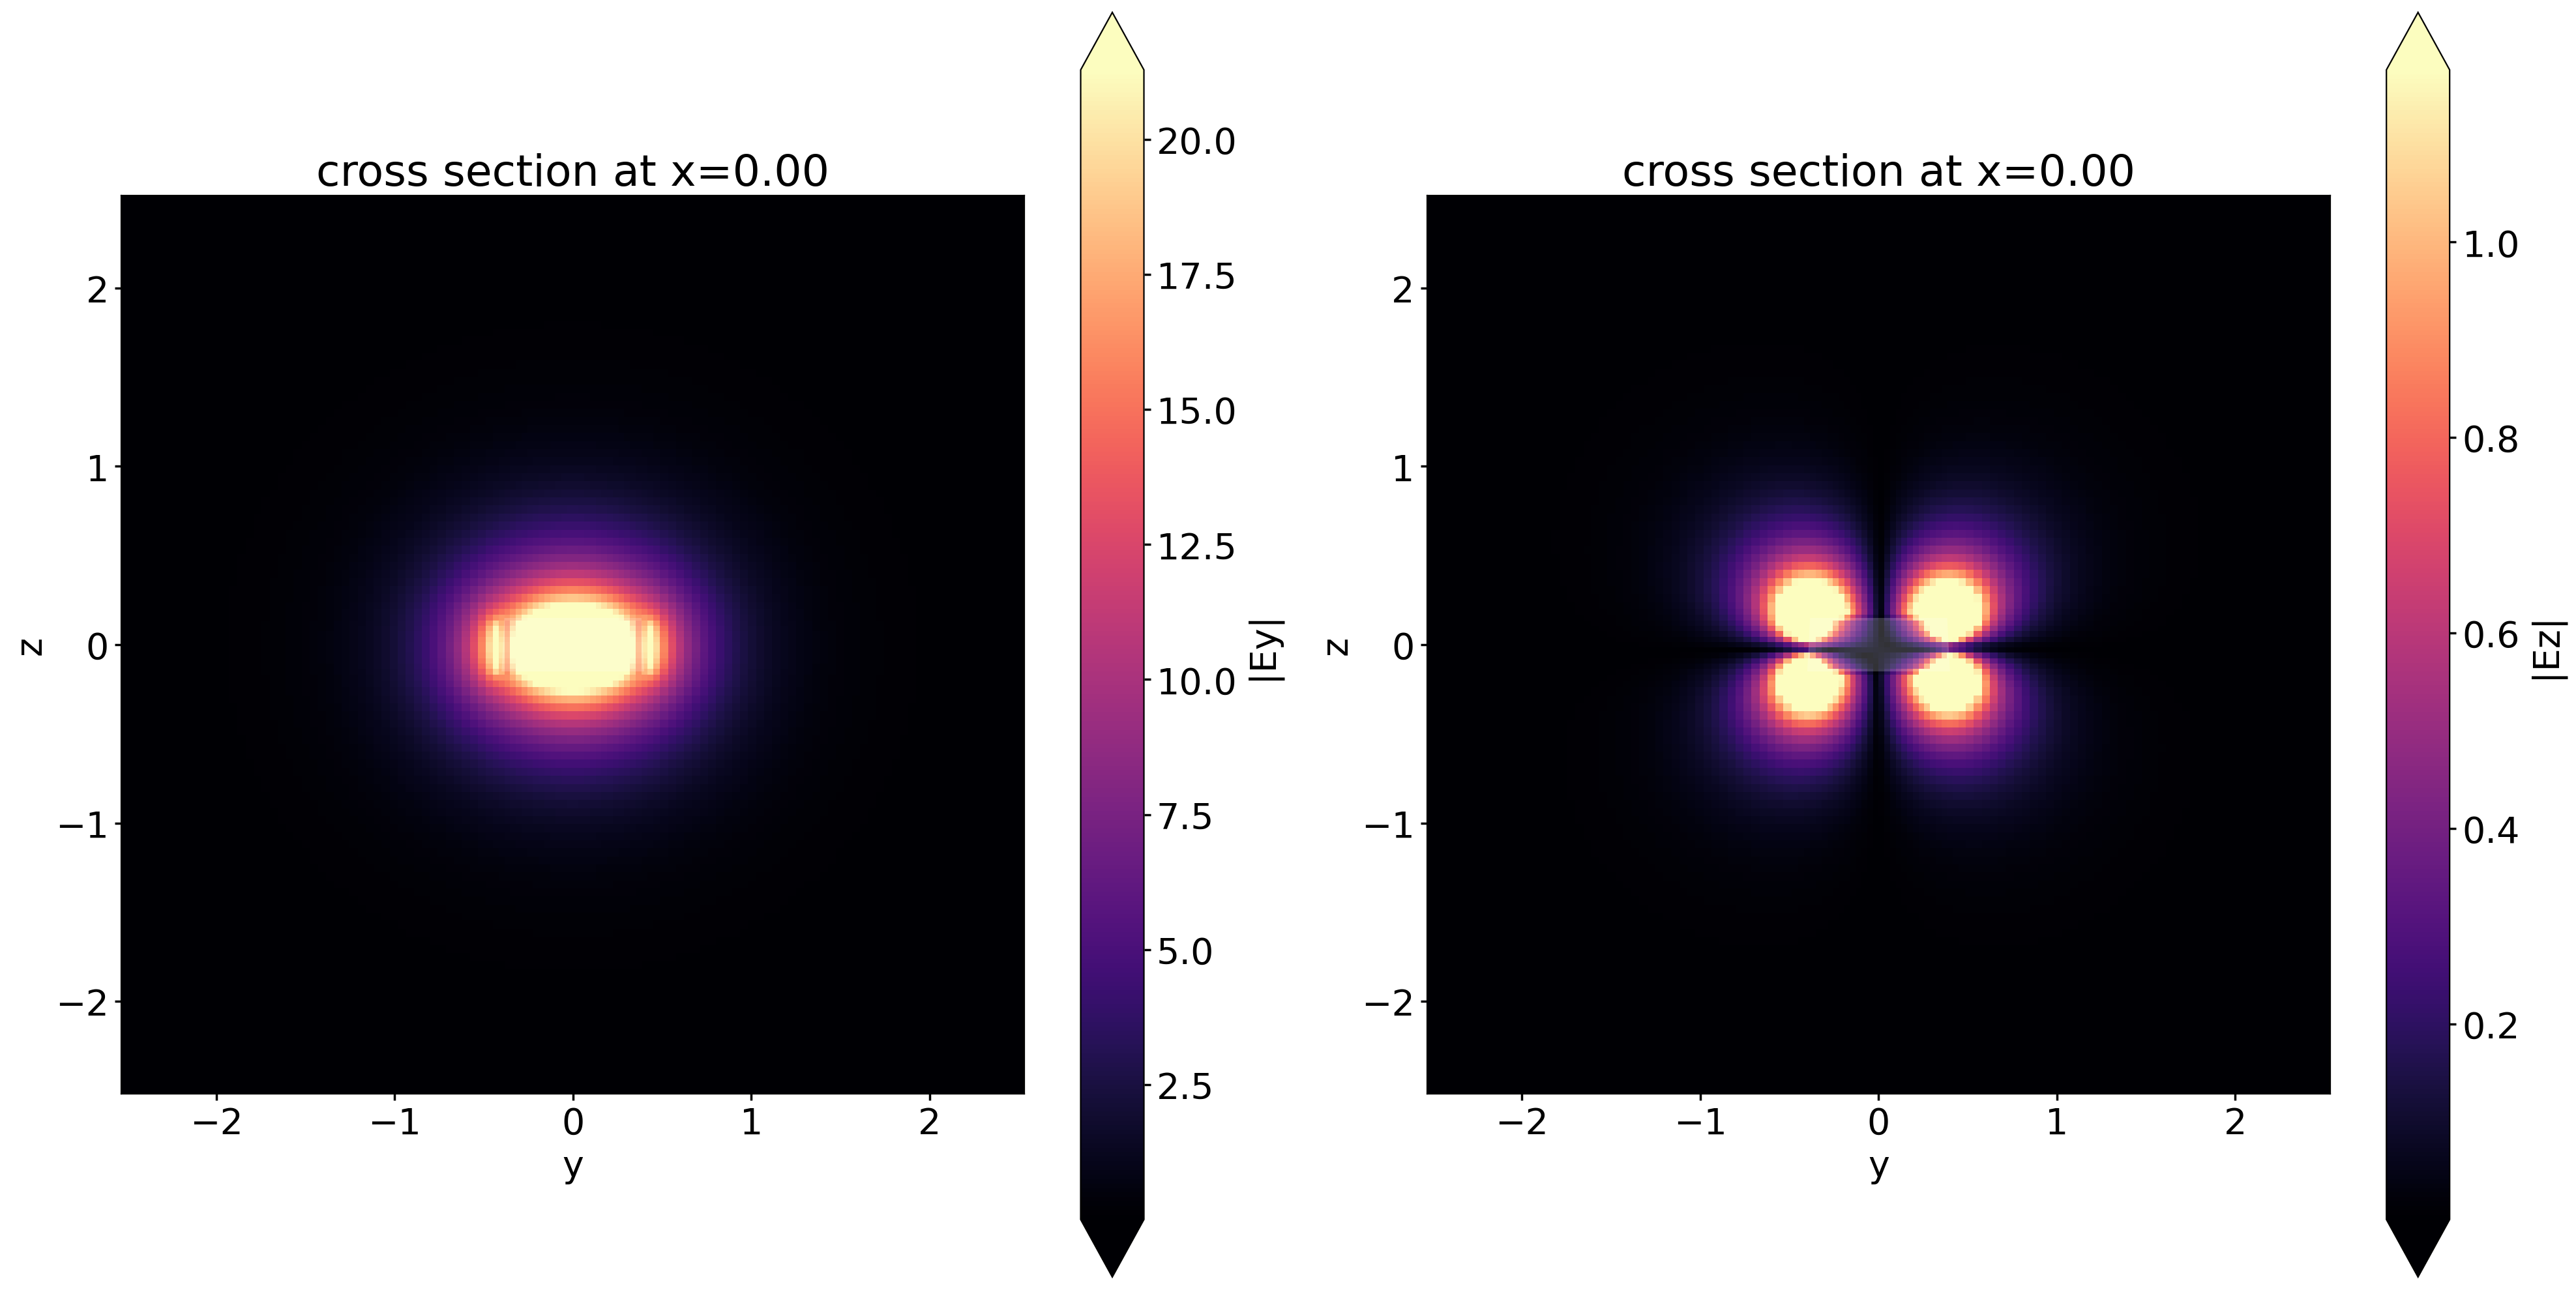

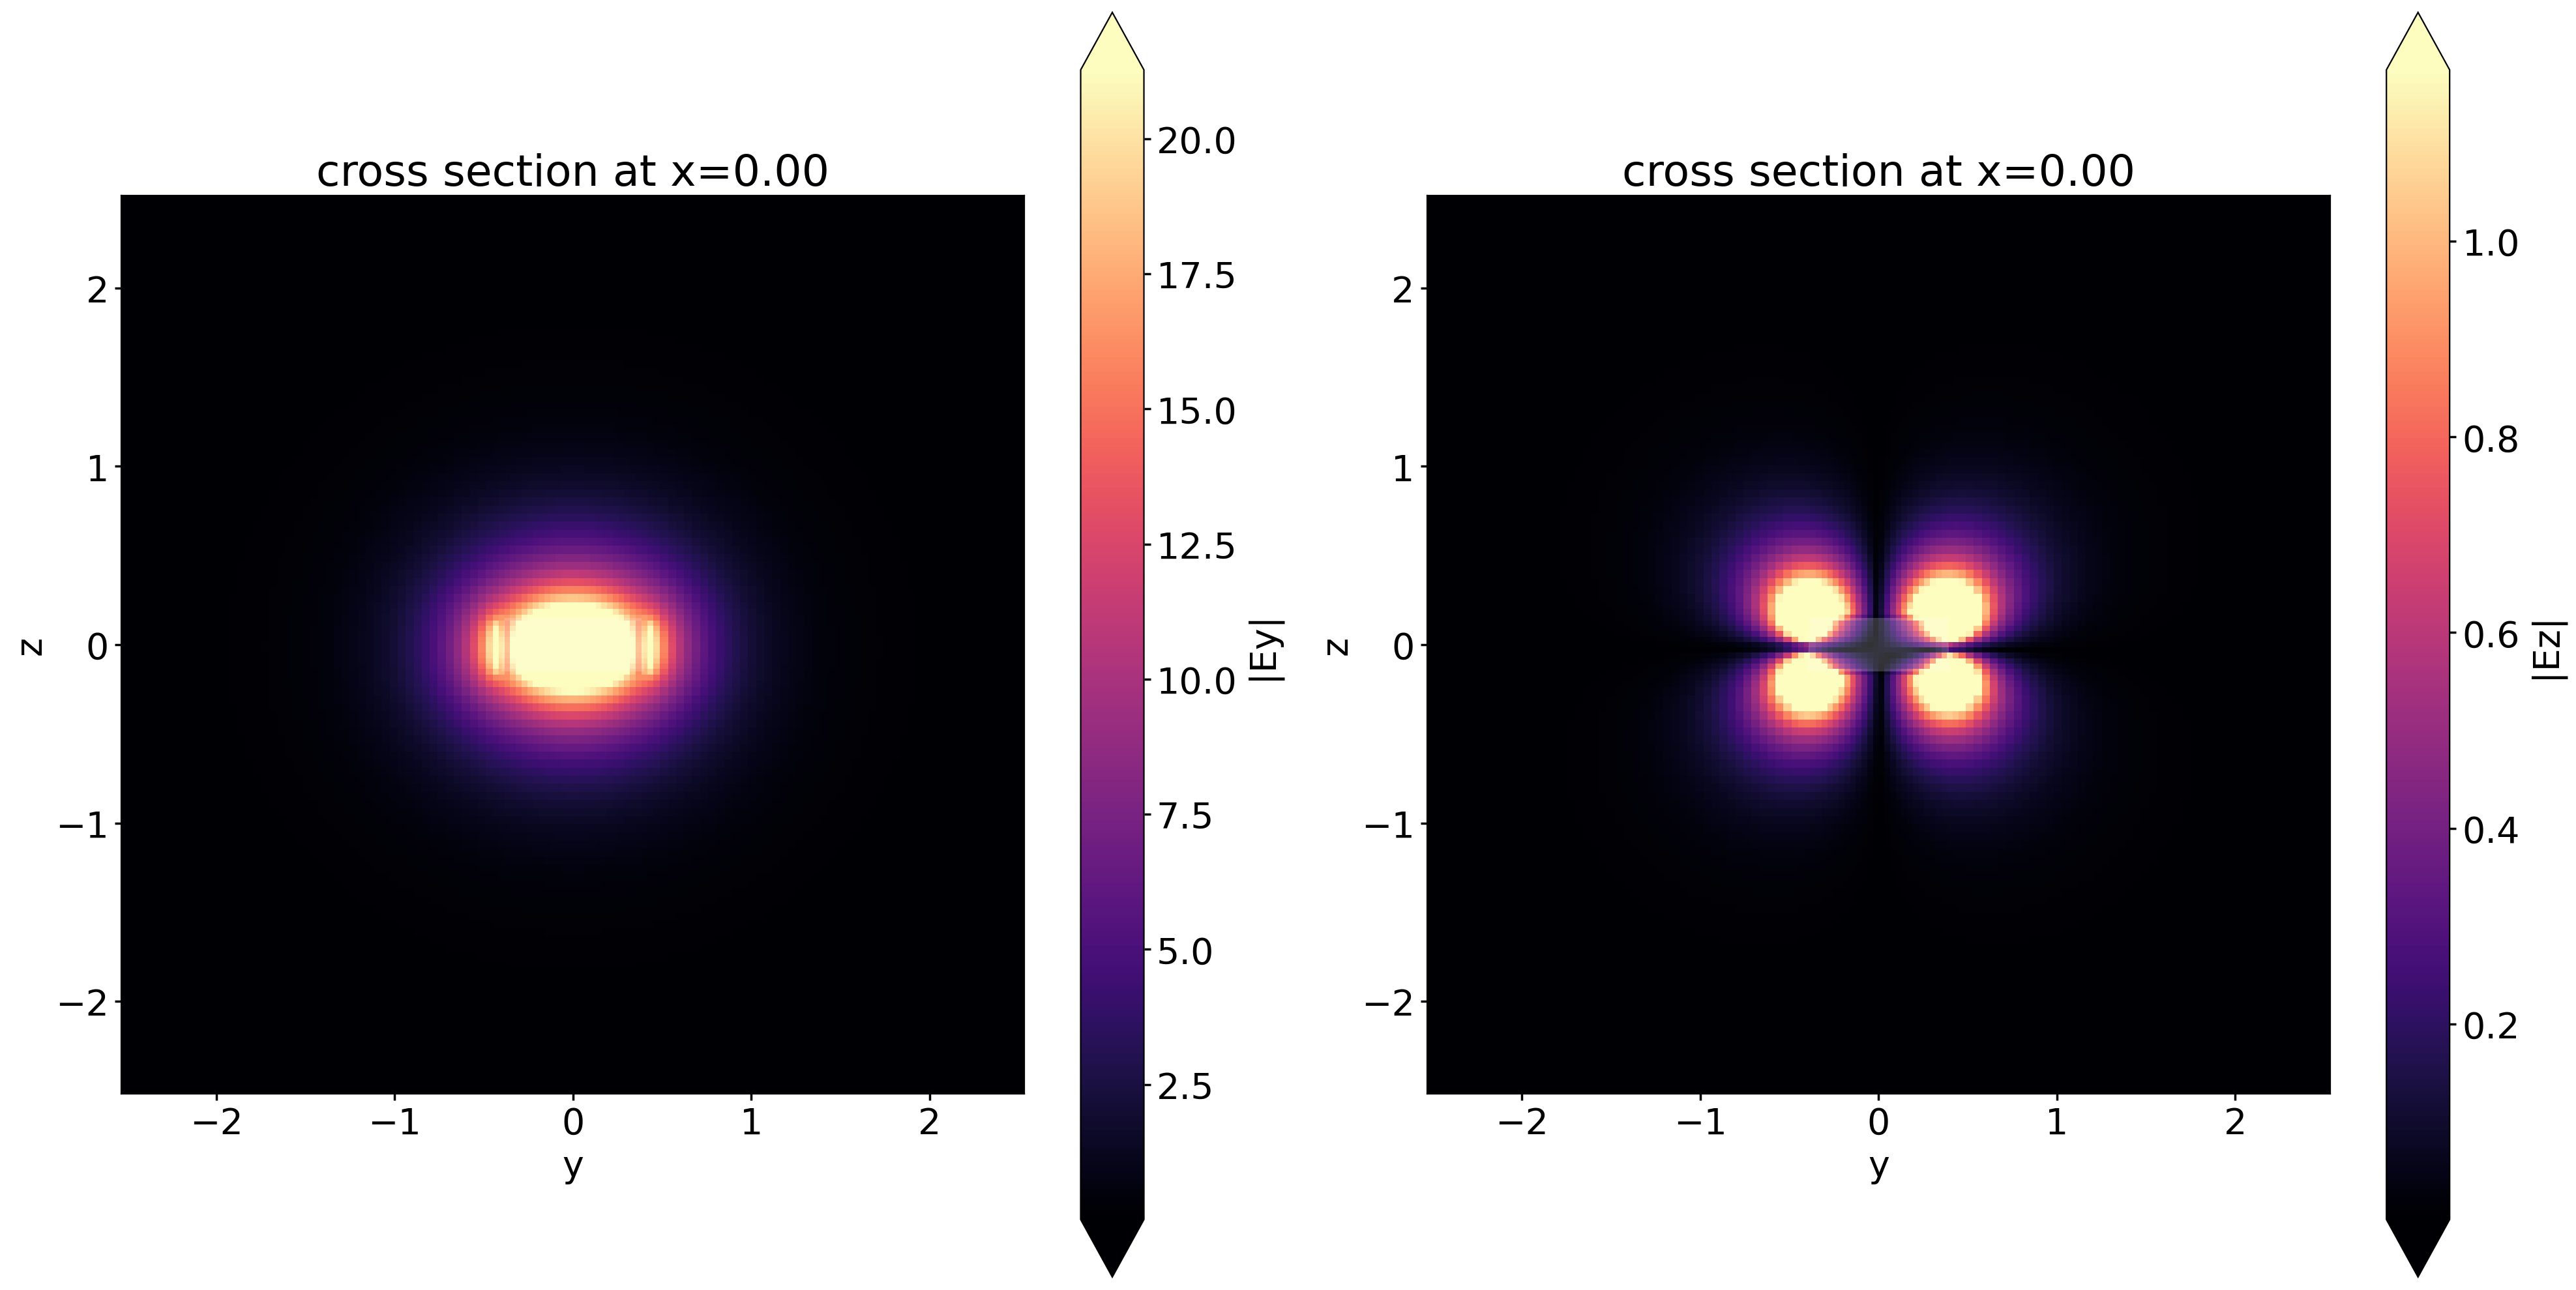

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
single_mode_solver_0C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
single_mode_solver_0C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
plt.show()
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
single_mode_solver_120C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
single_mode_solver_120C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
plt.show()

In [6]:
print("Single mode n_eff_0C = ", single_mode_n_eff_0C)
print("Signle mode n_eff_120C = ", single_mode_n_eff_120C)

Single mode n_eff_0C =  1.587703
Signle mode n_eff_120C =  1.5901577


# Symmetric Coupled wg mode (wg width 1 = 800 nm, wg width 2 = 800 nm, gap = 500 nm) at 0C and 120C

In [7]:
def coupled_wg_mode_data_calculator(wg_width_1, wg_height_1, sidewall_angle_1, wg_width_2, wg_height_2, sidewall_angle_2, gap, n_medium, n_background,target_neff, freqs, freq0, Lx = 20, Ly=20, Lz=20, num_modes = 10, dl=0.05, min_steps_per_wvl = 20):
  Lx, Ly, Lz = Lx, Ly, Lz

  wg_medium = td.Medium.from_nk(n=n_medium, k=0, freq=freq0)
  background_medium = td.Medium.from_nk(n=n_background, k=0, freq=freq0)

  wvl_um = C_0/freq0

  vertices = np.array([(-1.0, -wg_width_1/2.0-gap/2.0), (1.0, -wg_width_1/2.0-gap/2.0),
                      (1.0, wg_width_1/2.0-gap/2.0), (-1.0, wg_width_1/2.0-gap/2.0)])
  wg_left = td.Structure(
      geometry=td.PolySlab(
          vertices=vertices,
          axis=2,
          slab_bounds=(-wg_height_1/2.0, wg_height_1/2.0),
          sidewall_angle=sidewall_angle_1,
          reference_plane="bottom"
      ),
      medium=wg_medium
  )

  vertices = np.array([(-1.0, -wg_width_2/2.0+gap/2.0), (1.0, -wg_width_2/2.0+gap/2.0),
                      (1.0, wg_width_2/2.0+gap/2.0), (-1.0, wg_width_2/2.0+gap/2.0)])
  wg_right = td.Structure(
      geometry=td.PolySlab(
          vertices=vertices,
          axis=2,
          slab_bounds=(-wg_height_2/2.0, wg_height_2/2.0),
          sidewall_angle=sidewall_angle_2,
          reference_plane="bottom"
      ),
      medium=wg_medium
  )

  # automatic grid specification
  grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=wvl_um)
  run_time = 1e-12

  sim = td.Simulation(
      size=(Lx, Ly, Lz),
      grid_spec=grid_spec,
      structures=[wg_left, wg_right],
      run_time=run_time,
      medium=background_medium,
      boundary_spec=td.BoundarySpec.all_sides(boundary=td.Periodic()),
      
  )

  plane = td.Box(
      center=(0, 0, 0),
      size=(0, Ly/2, Lz/2)
  )

  mode_spec = td.ModeSpec(
      num_modes=num_modes,
      target_neff=target_neff,
      group_index_step=True
  )

  mode_solver = ModeSolver(
      simulation=sim,
      plane=plane,
      mode_spec=mode_spec,
      freqs=freqs,
  )

  mode_data = mode_solver.solve()

  n_eff = mode_data.n_eff
  delta_neff = n_eff.sel(mode_index=0, f=freq0).values - n_eff.sel(mode_index=1, f=freq0).values

  return (mode_solver, mode_data, n_eff, delta_neff)

In [8]:
Lx, Ly, Lz = 10, 10, 10
dl = 0.01

min_steps_per_wvl = 30

wg_width_1 = 0.8
wg_height_1 = 0.3
wg_sidewall_angle_1 = np.pi/2.0 - 87.0/180.0*np.pi

wg_width_2 = 0.8
wg_height_2 = 0.3
wg_sidewall_angle_2 = np.pi/2.0 - 87.0/180.0*np.pi

wg_gap = 0.5 

gap = wg_gap + wg_width_1/2.0 + wg_width_2/2.0

target_neff = 1.587703

wg_n = 1.968
wg_k = 0

wvl_um = 1.31
freq0 = C_0/wvl_um

wg_medium = td.Medium.from_nk(n=1.968, k=0, freq=freq0)

wg_sidewall_angle_2 = np.pi/2.0 - 87.0/180.0*np.pi

num_freqs = 3

fwidth = 3200e9  # 3200 Ghz
freqs = np.linspace(freq0-fwidth/2.0, freq0+fwidth/2.0, num_freqs)

thickness_3sigma = 0.03
width_3sigma = 0.02
sidewall_angle_3sigma = 2/90*np.pi/2

num_samples = 1500

n_medium_0C = 1.968
n_background_0C = 1.45
n_medium_120C = 1.968 + 2.5e-5*120
n_background_120C = 1.45 + 1e-5*120

target_neff_0C = 1.587703
target_neff_120C = 1.5901577


In [9]:
symmetric_wg_1_coupled_mode_solver_0C, symmetric_wg_1_coupled_mode_data_0C, symmetric_wg_1_coupled_n_eff_0C, symmetric_wg_1_coupled_delta_neff_0C = coupled_wg_mode_data_calculator(
    wg_width_1, wg_height_1, wg_sidewall_angle_1, wg_width_2, wg_height_2, wg_sidewall_angle_2, gap, n_medium_0C, n_background_0C,target_neff_0C,  freqs, freq0, Lx = 20, Ly=20, Lz=20, num_modes = 2, dl=0.05, min_steps_per_wvl = 20
    )
symmetric_wg_1_coupled_mode_solver_120C, symmetric_wg_1_coupled_mode_data_120C, symmetric_wg_1_coupled_n_eff_120C, symmetric_wg_1_coupled_delta_neff_120C = coupled_wg_mode_data_calculator(
    wg_width_1, wg_height_1, wg_sidewall_angle_1, wg_width_2, wg_height_2, wg_sidewall_angle_2, gap, n_medium_120C, n_background_120C,target_neff_120C, freqs, freq0, Lx = 20, Ly=20, Lz=20, num_modes = 2, dl=0.05, min_steps_per_wvl = 20
    )

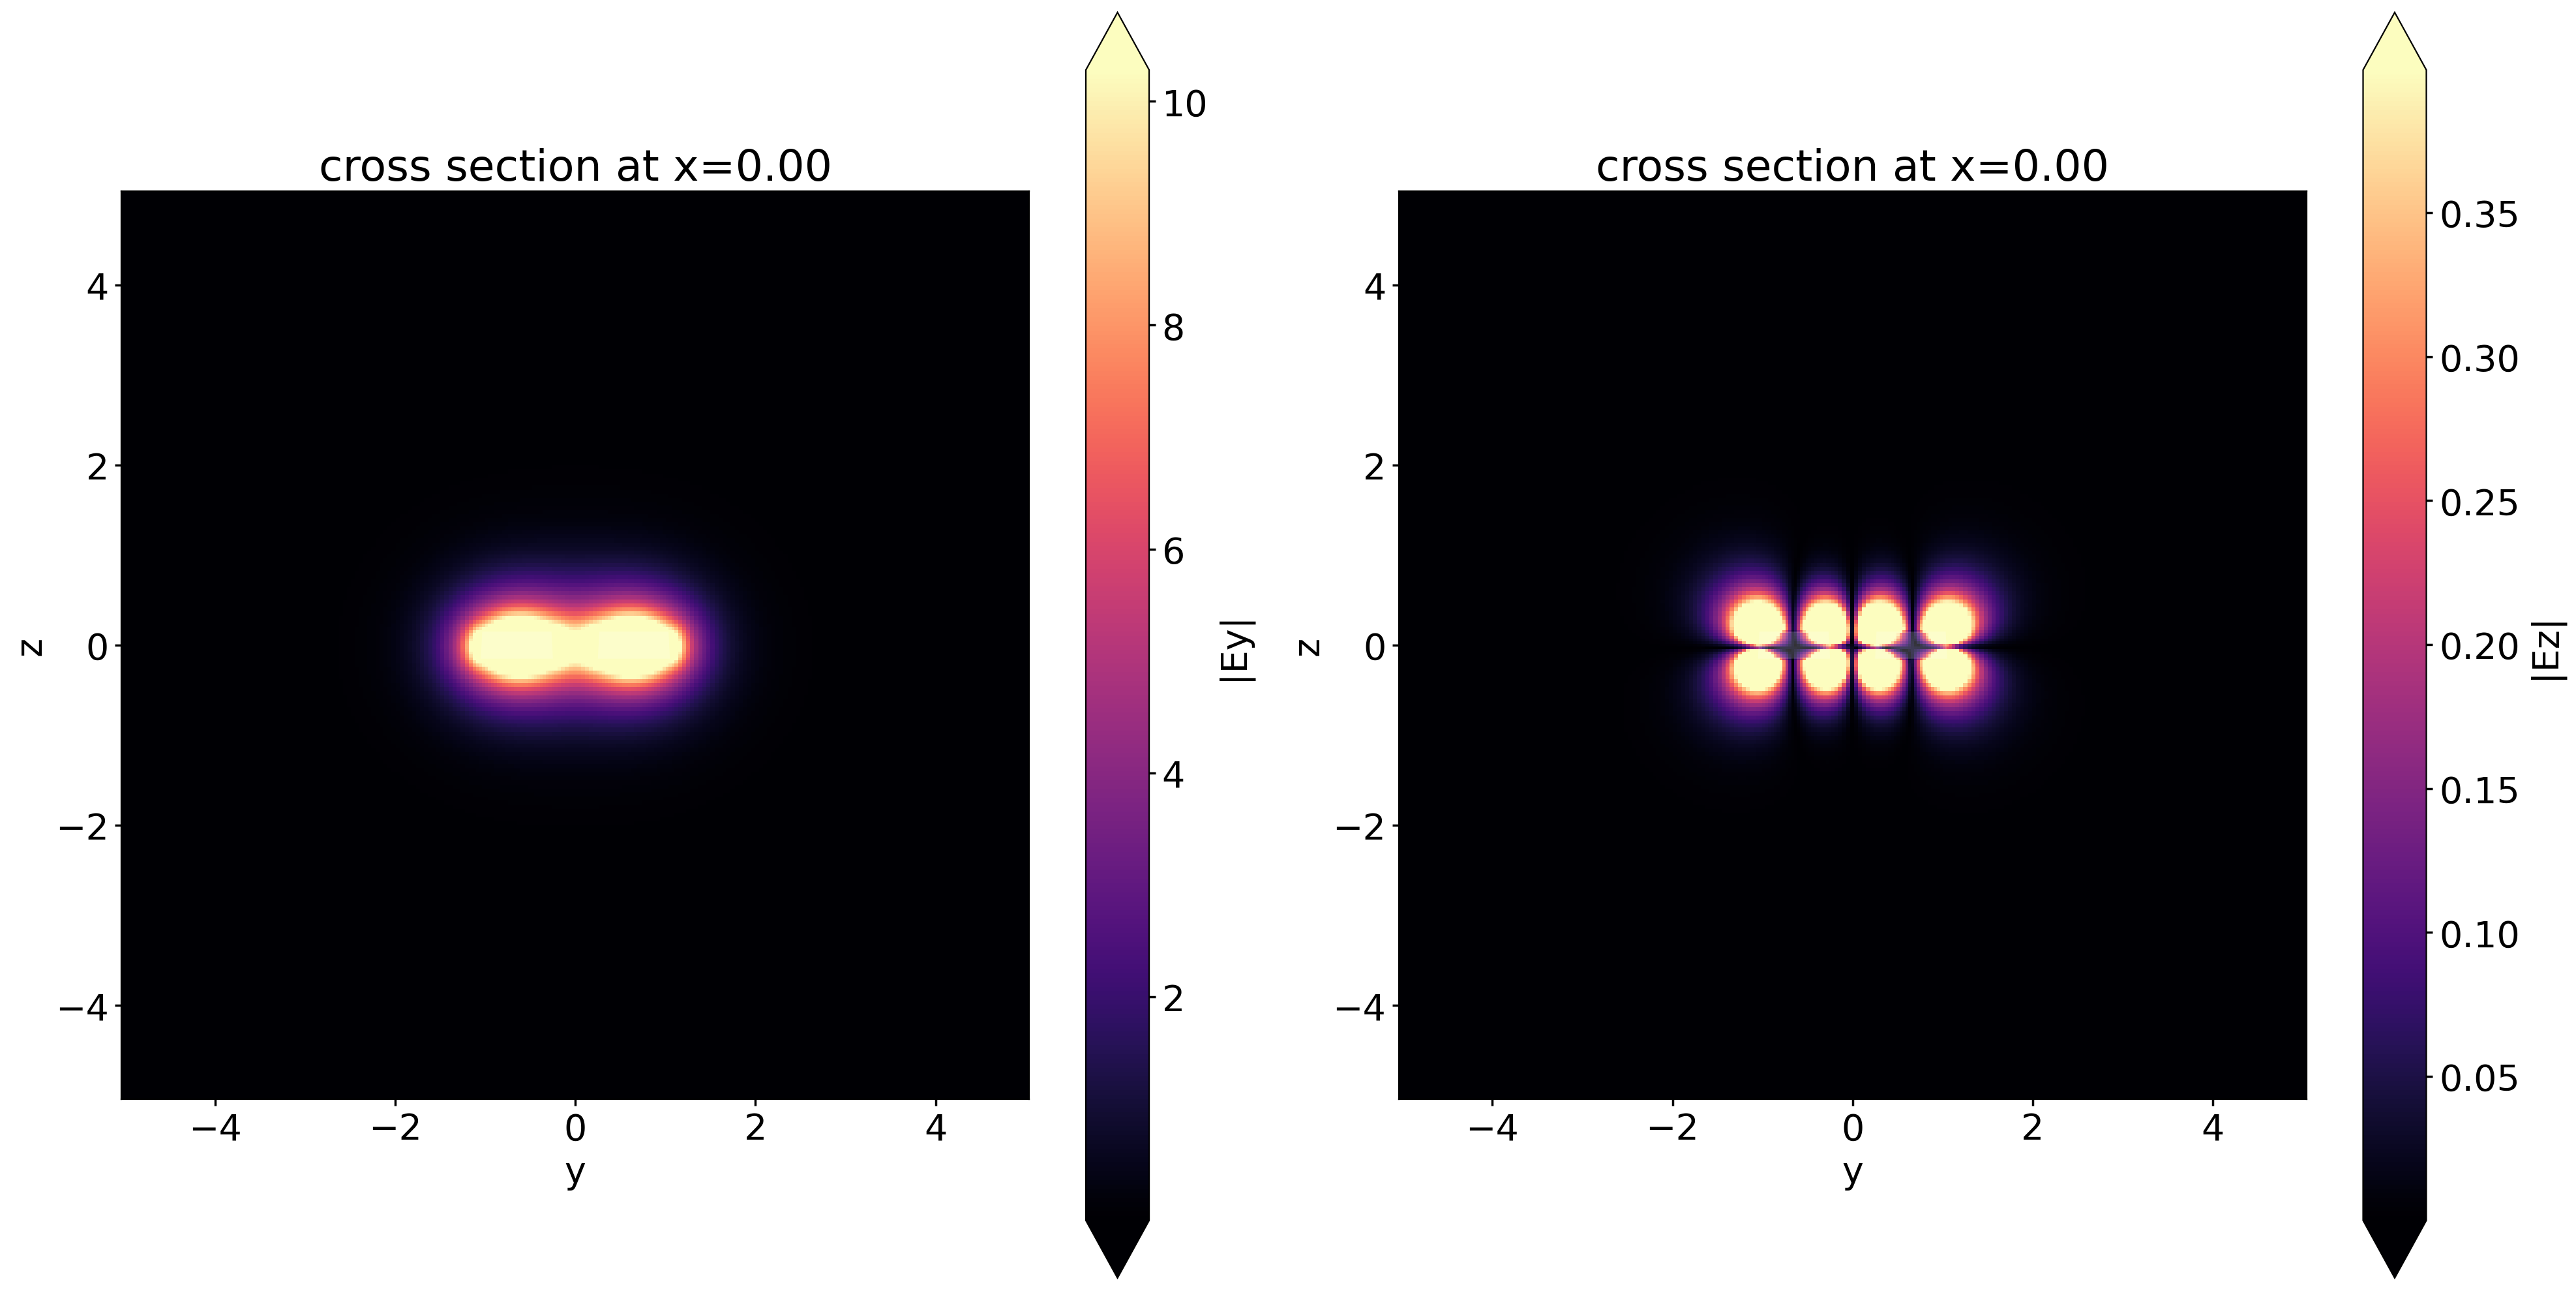

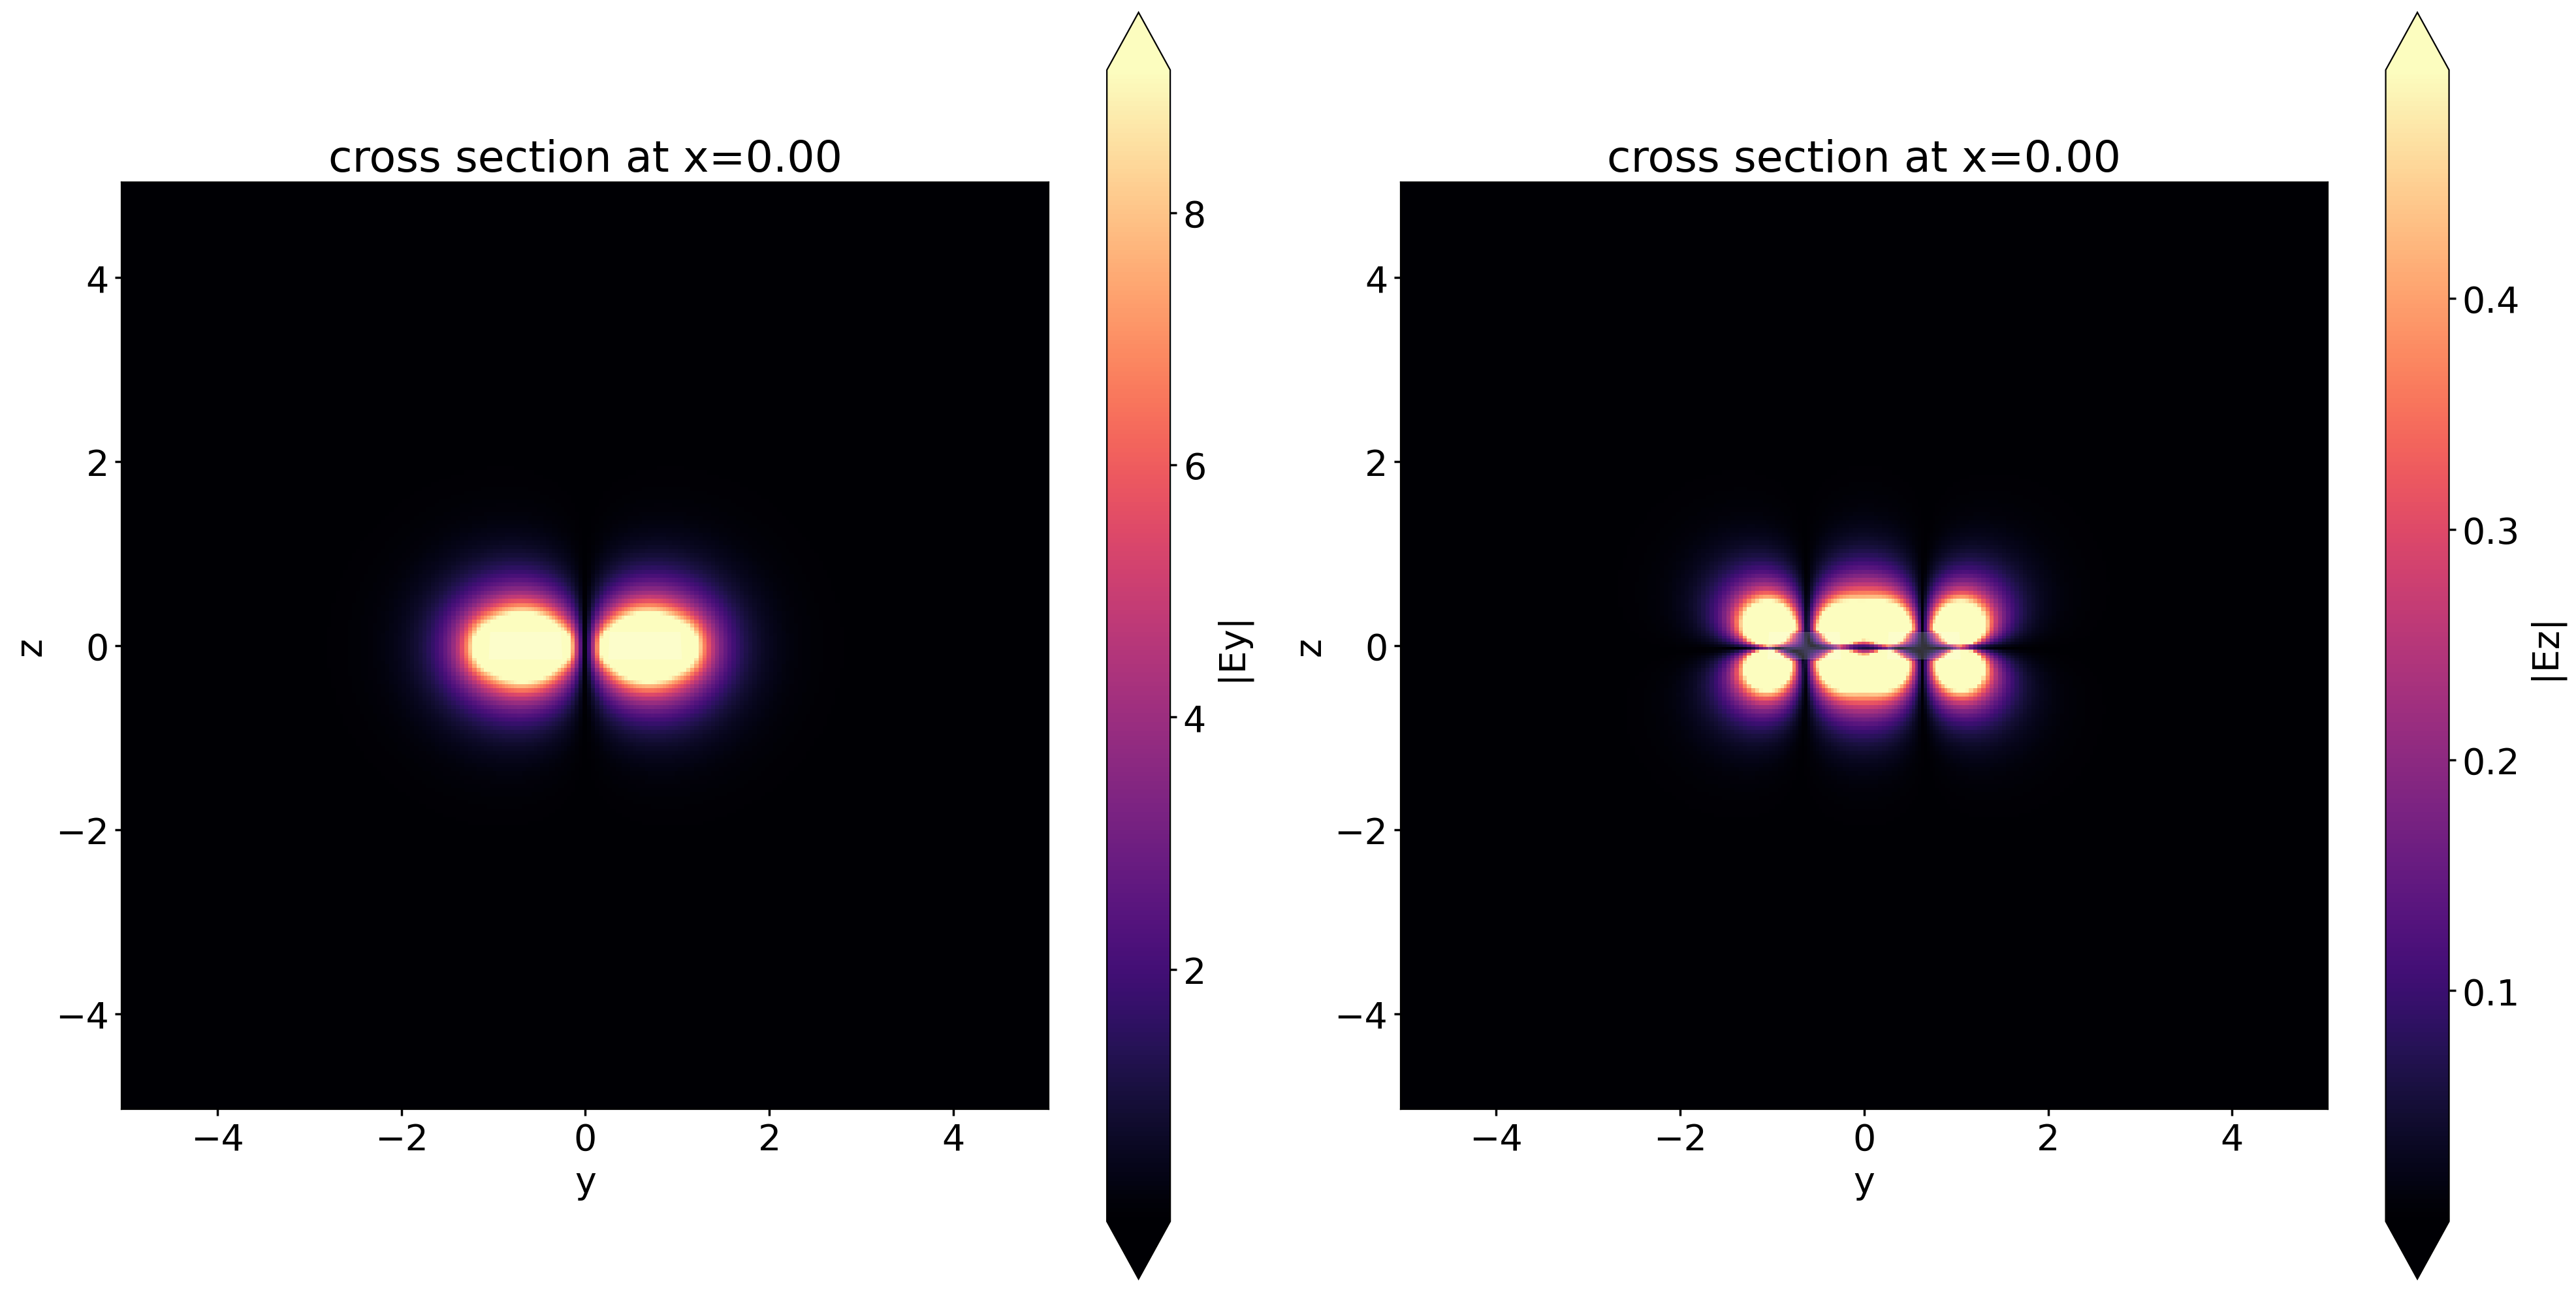

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
symmetric_wg_1_coupled_mode_solver_0C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
symmetric_wg_1_coupled_mode_solver_0C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
symmetric_wg_1_coupled_mode_solver_0C.plot_field("Ey", "abs", mode_index=1, f=freq0, ax=ax1)
symmetric_wg_1_coupled_mode_solver_0C.plot_field("Ez", "abs", mode_index=1, f=freq0, ax=ax2)
plt.tight_layout()
plt.show()

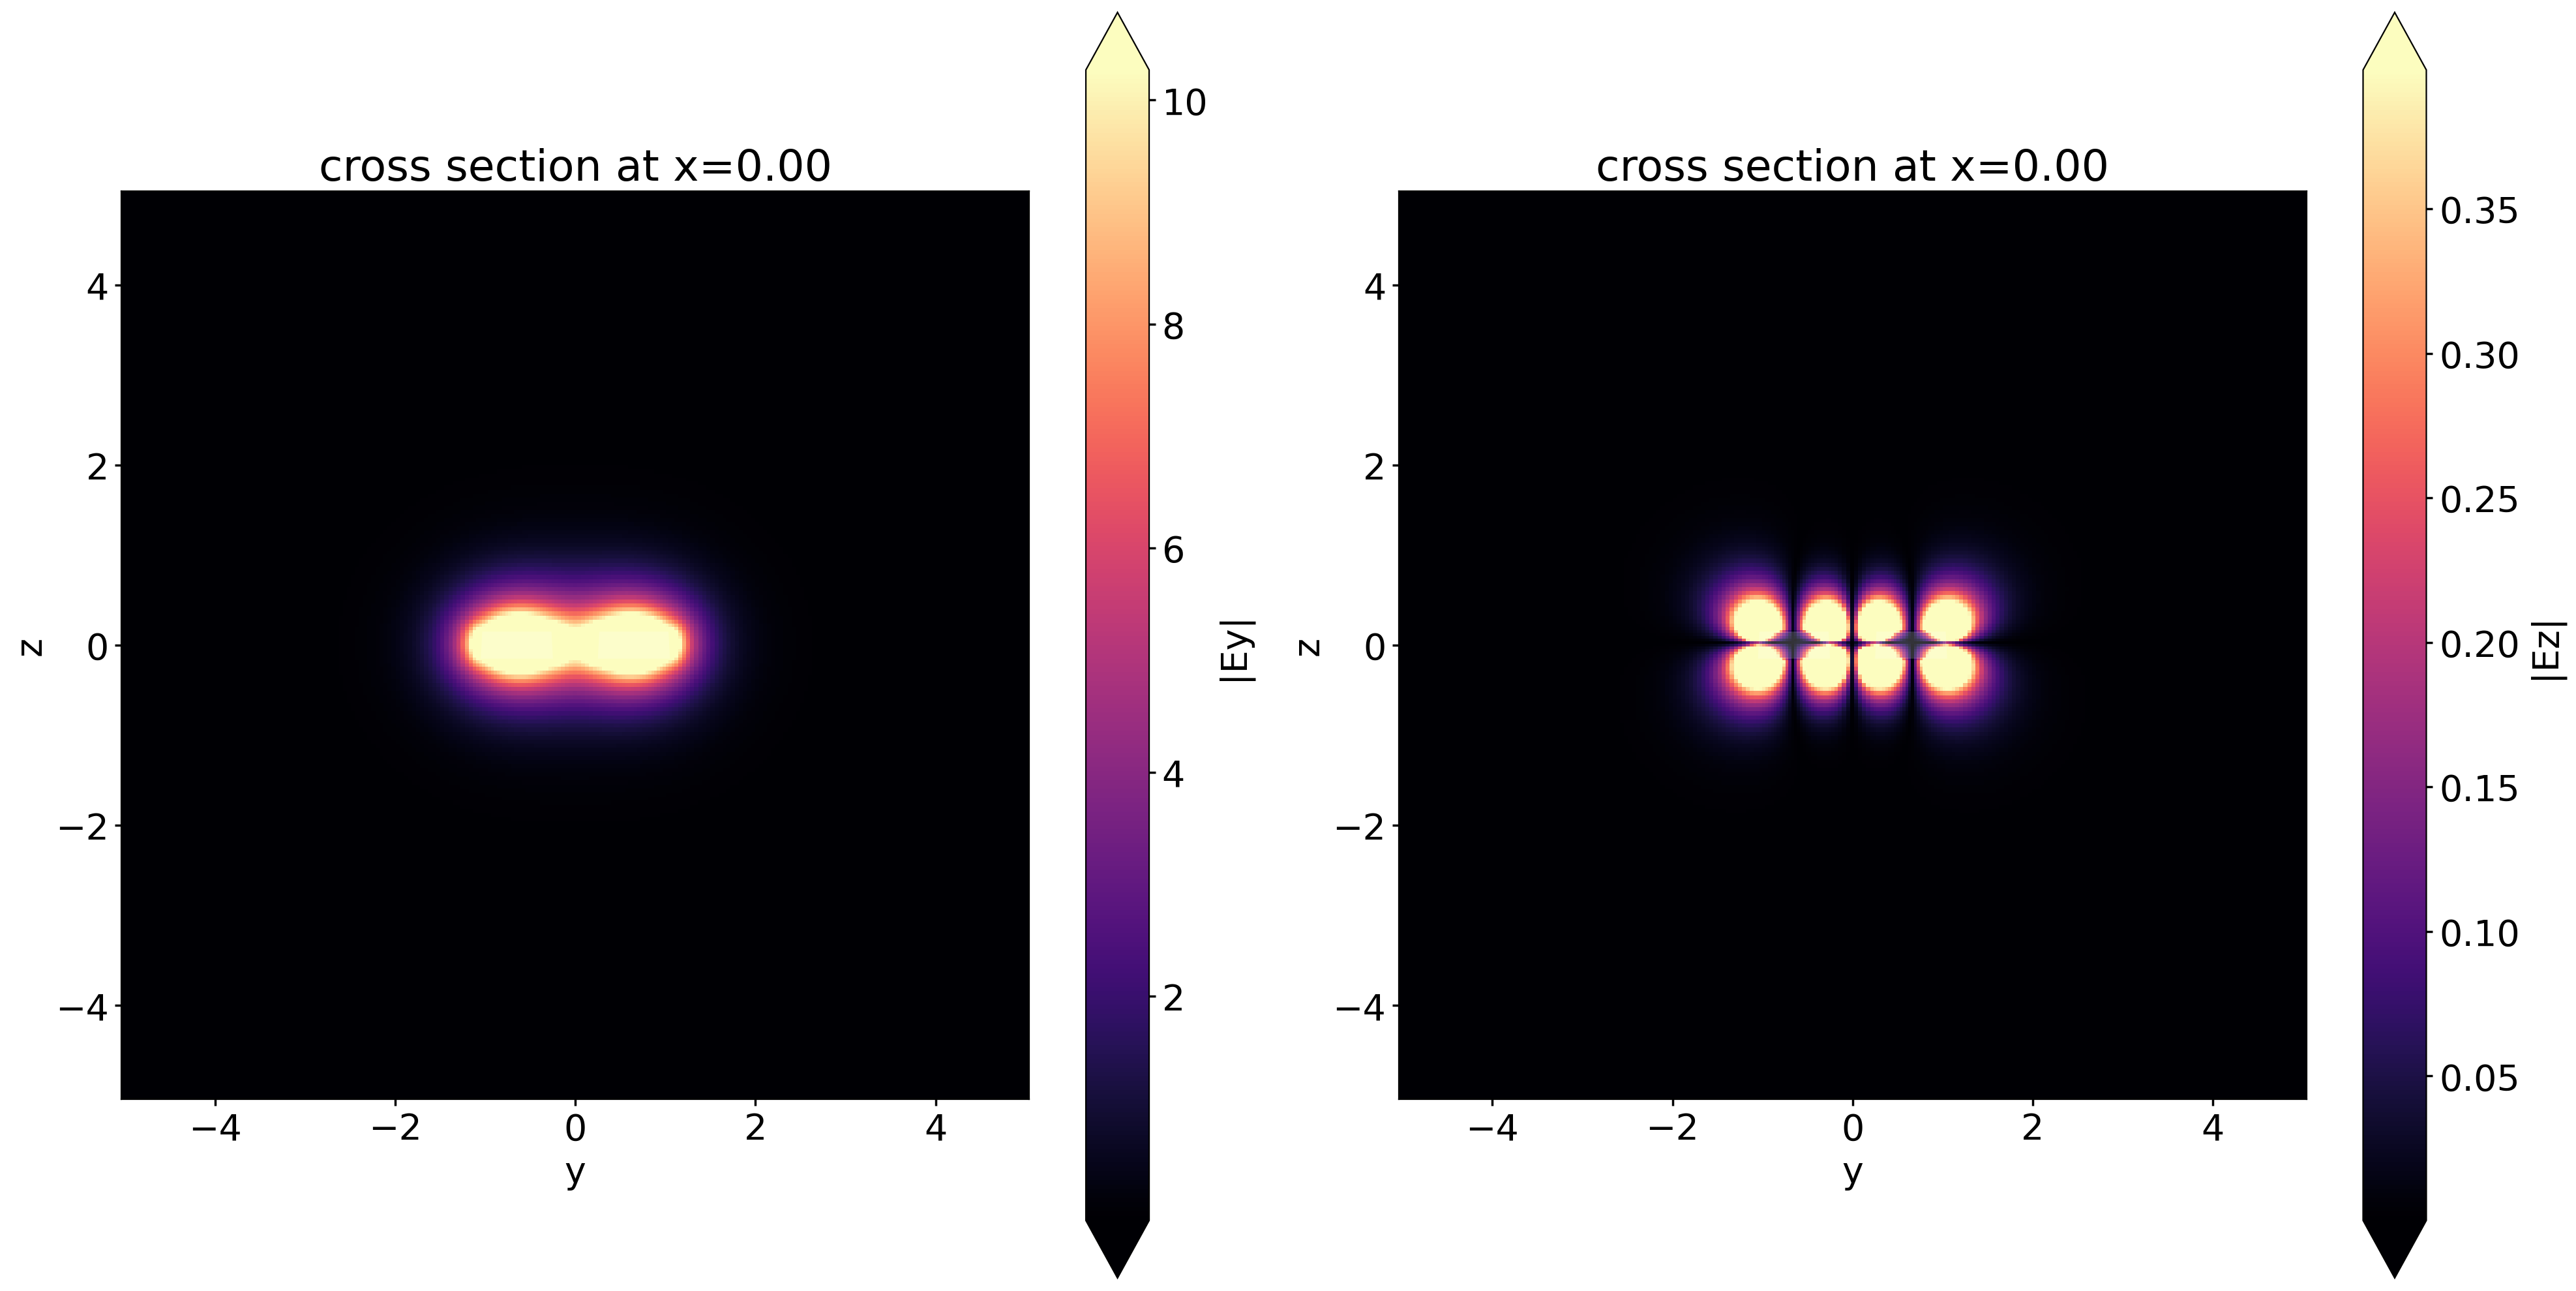

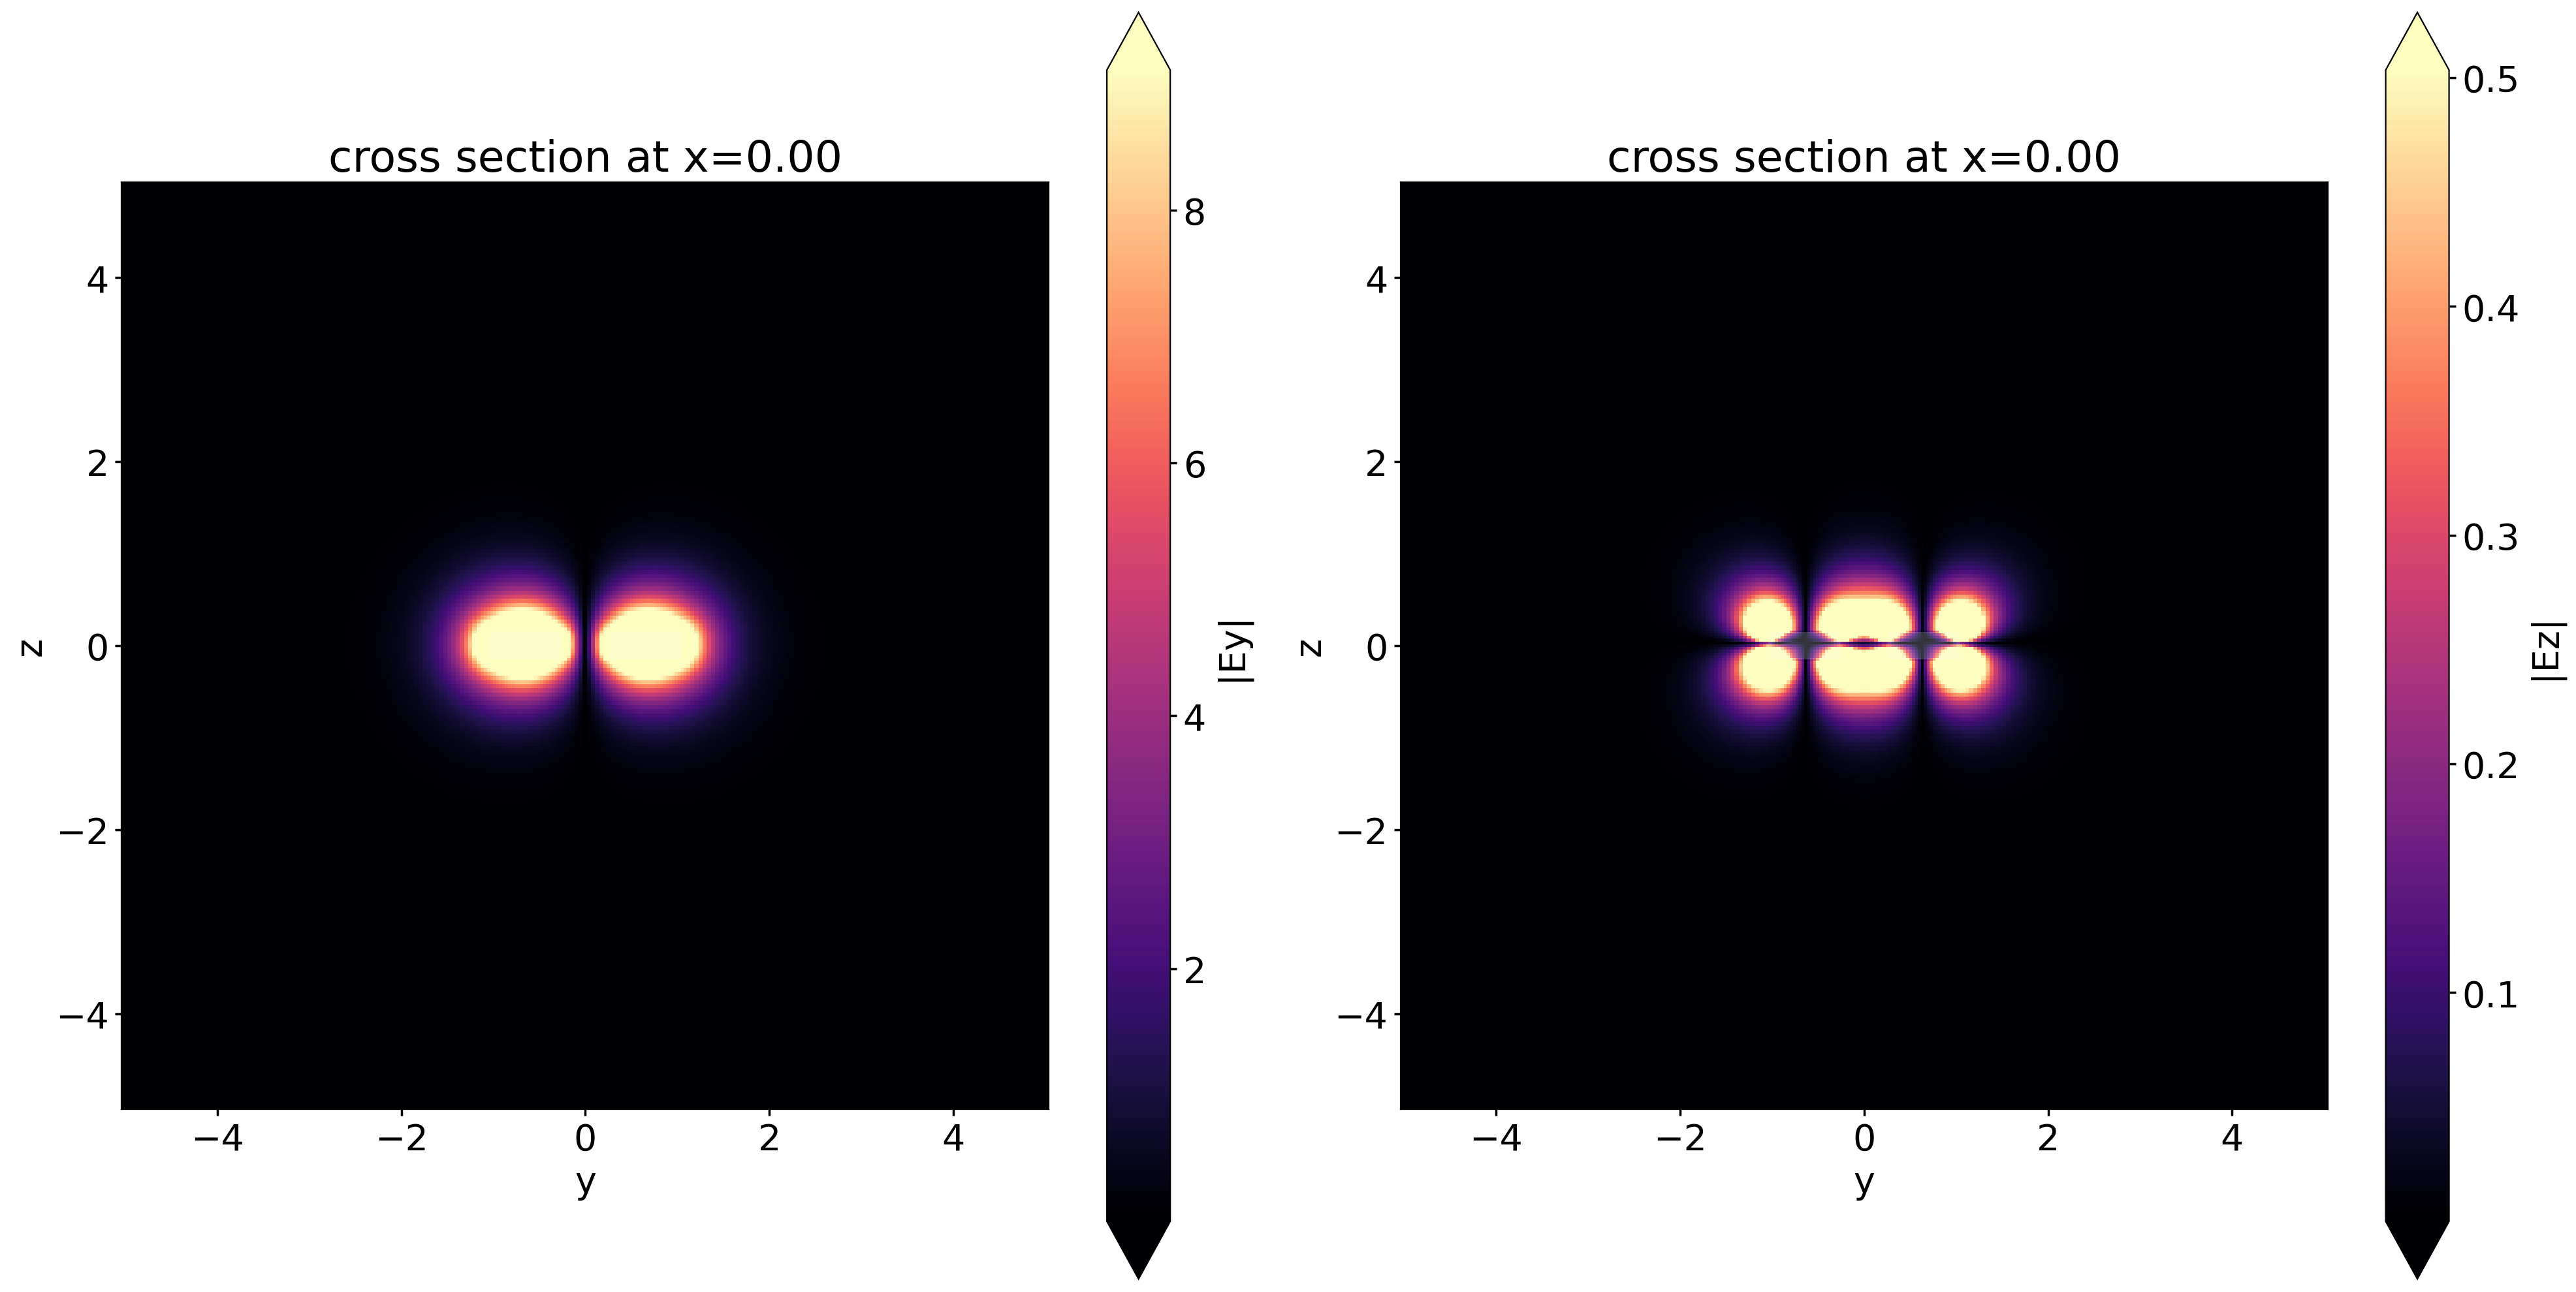

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
symmetric_wg_1_coupled_mode_solver_120C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
symmetric_wg_1_coupled_mode_solver_120C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
symmetric_wg_1_coupled_mode_solver_120C.plot_field("Ey", "abs", mode_index=1, f=freq0, ax=ax1)
symmetric_wg_1_coupled_mode_solver_120C.plot_field("Ez", "abs", mode_index=1, f=freq0, ax=ax2)
plt.tight_layout()
plt.show()

In [12]:
print("delta_neff_0C = ", symmetric_wg_1_coupled_delta_neff_0C)
print("delta_neff_120C = ", symmetric_wg_1_coupled_delta_neff_120C)

delta_neff_0C =  0.014468193
delta_neff_120C =  0.014388323


In [13]:
print((symmetric_wg_1_coupled_delta_neff_120C-symmetric_wg_1_coupled_delta_neff_0C)/symmetric_wg_1_coupled_delta_neff_0C*100)

-0.552040059119463


# Symmetric Coupled wg mode (wg width 1 = 800 nm, wg width 2 = 800 nm, gap = 451 nm) at 0C and 120C

In [14]:
Lx, Ly, Lz = 10, 10, 10
dl = 0.01

min_steps_per_wvl = 30

wg_width_1 = 0.8
wg_height_1 = 0.3
wg_sidewall_angle_1 = np.pi/2.0 - 87.0/180.0*np.pi

wg_width_2 = 0.8
wg_height_2 = 0.3
wg_sidewall_angle_2 = np.pi/2.0 - 87.0/180.0*np.pi

wg_gap = 0.451

gap = wg_gap + wg_width_1/2.0 + wg_width_2/2.0

target_neff = 1.587703

wg_n = 1.968
wg_k = 0

wvl_um = 1.31
freq0 = C_0/wvl_um

wg_medium = td.Medium.from_nk(n=1.968, k=0, freq=freq0)

wg_sidewall_angle_2 = np.pi/2.0 - 87.0/180.0*np.pi

num_freqs = 3

fwidth = 3200e9  # 3200 Ghz
freqs = np.linspace(freq0-fwidth/2.0, freq0+fwidth/2.0, num_freqs)

thickness_3sigma = 0.03
width_3sigma = 0.02
sidewall_angle_3sigma = 2/90*np.pi/2

num_samples = 1500

n_medium_0C = 1.968
n_background_0C = 1.45
n_medium_120C = 1.968 + 2.5e-5*120
n_background_120C = 1.45 + 1e-5*120

target_neff_0C = 1.587703
target_neff_120C = 1.5901577


In [15]:
symmetric_wg_2_coupled_mode_solver_0C, symmetric_wg_2_coupled_mode_data_0C, symmetric_wg_2_coupled_n_eff_0C, symmetric_wg_2_coupled_delta_neff_0C = coupled_wg_mode_data_calculator(
    wg_width_1, wg_height_1, wg_sidewall_angle_1, wg_width_2, wg_height_2, wg_sidewall_angle_2, gap, n_medium_0C, n_background_0C,target_neff_0C,  freqs, freq0, Lx = 20, Ly=20, Lz=20, num_modes = 2, dl=0.05, min_steps_per_wvl = 20
    )
symmetric_wg_2_coupled_mode_solver_120C, symmetric_wg_2_coupled_mode_data_120C, symmetric_wg_2_coupled_n_eff_120C, symmetric_wg_2_coupled_delta_neff_120C = coupled_wg_mode_data_calculator(
    wg_width_1, wg_height_1, wg_sidewall_angle_1, wg_width_2, wg_height_2, wg_sidewall_angle_2, gap, n_medium_120C, n_background_120C,target_neff_120C, freqs, freq0, Lx = 20, Ly=20, Lz=20, num_modes = 2, dl=0.05, min_steps_per_wvl = 20
    )

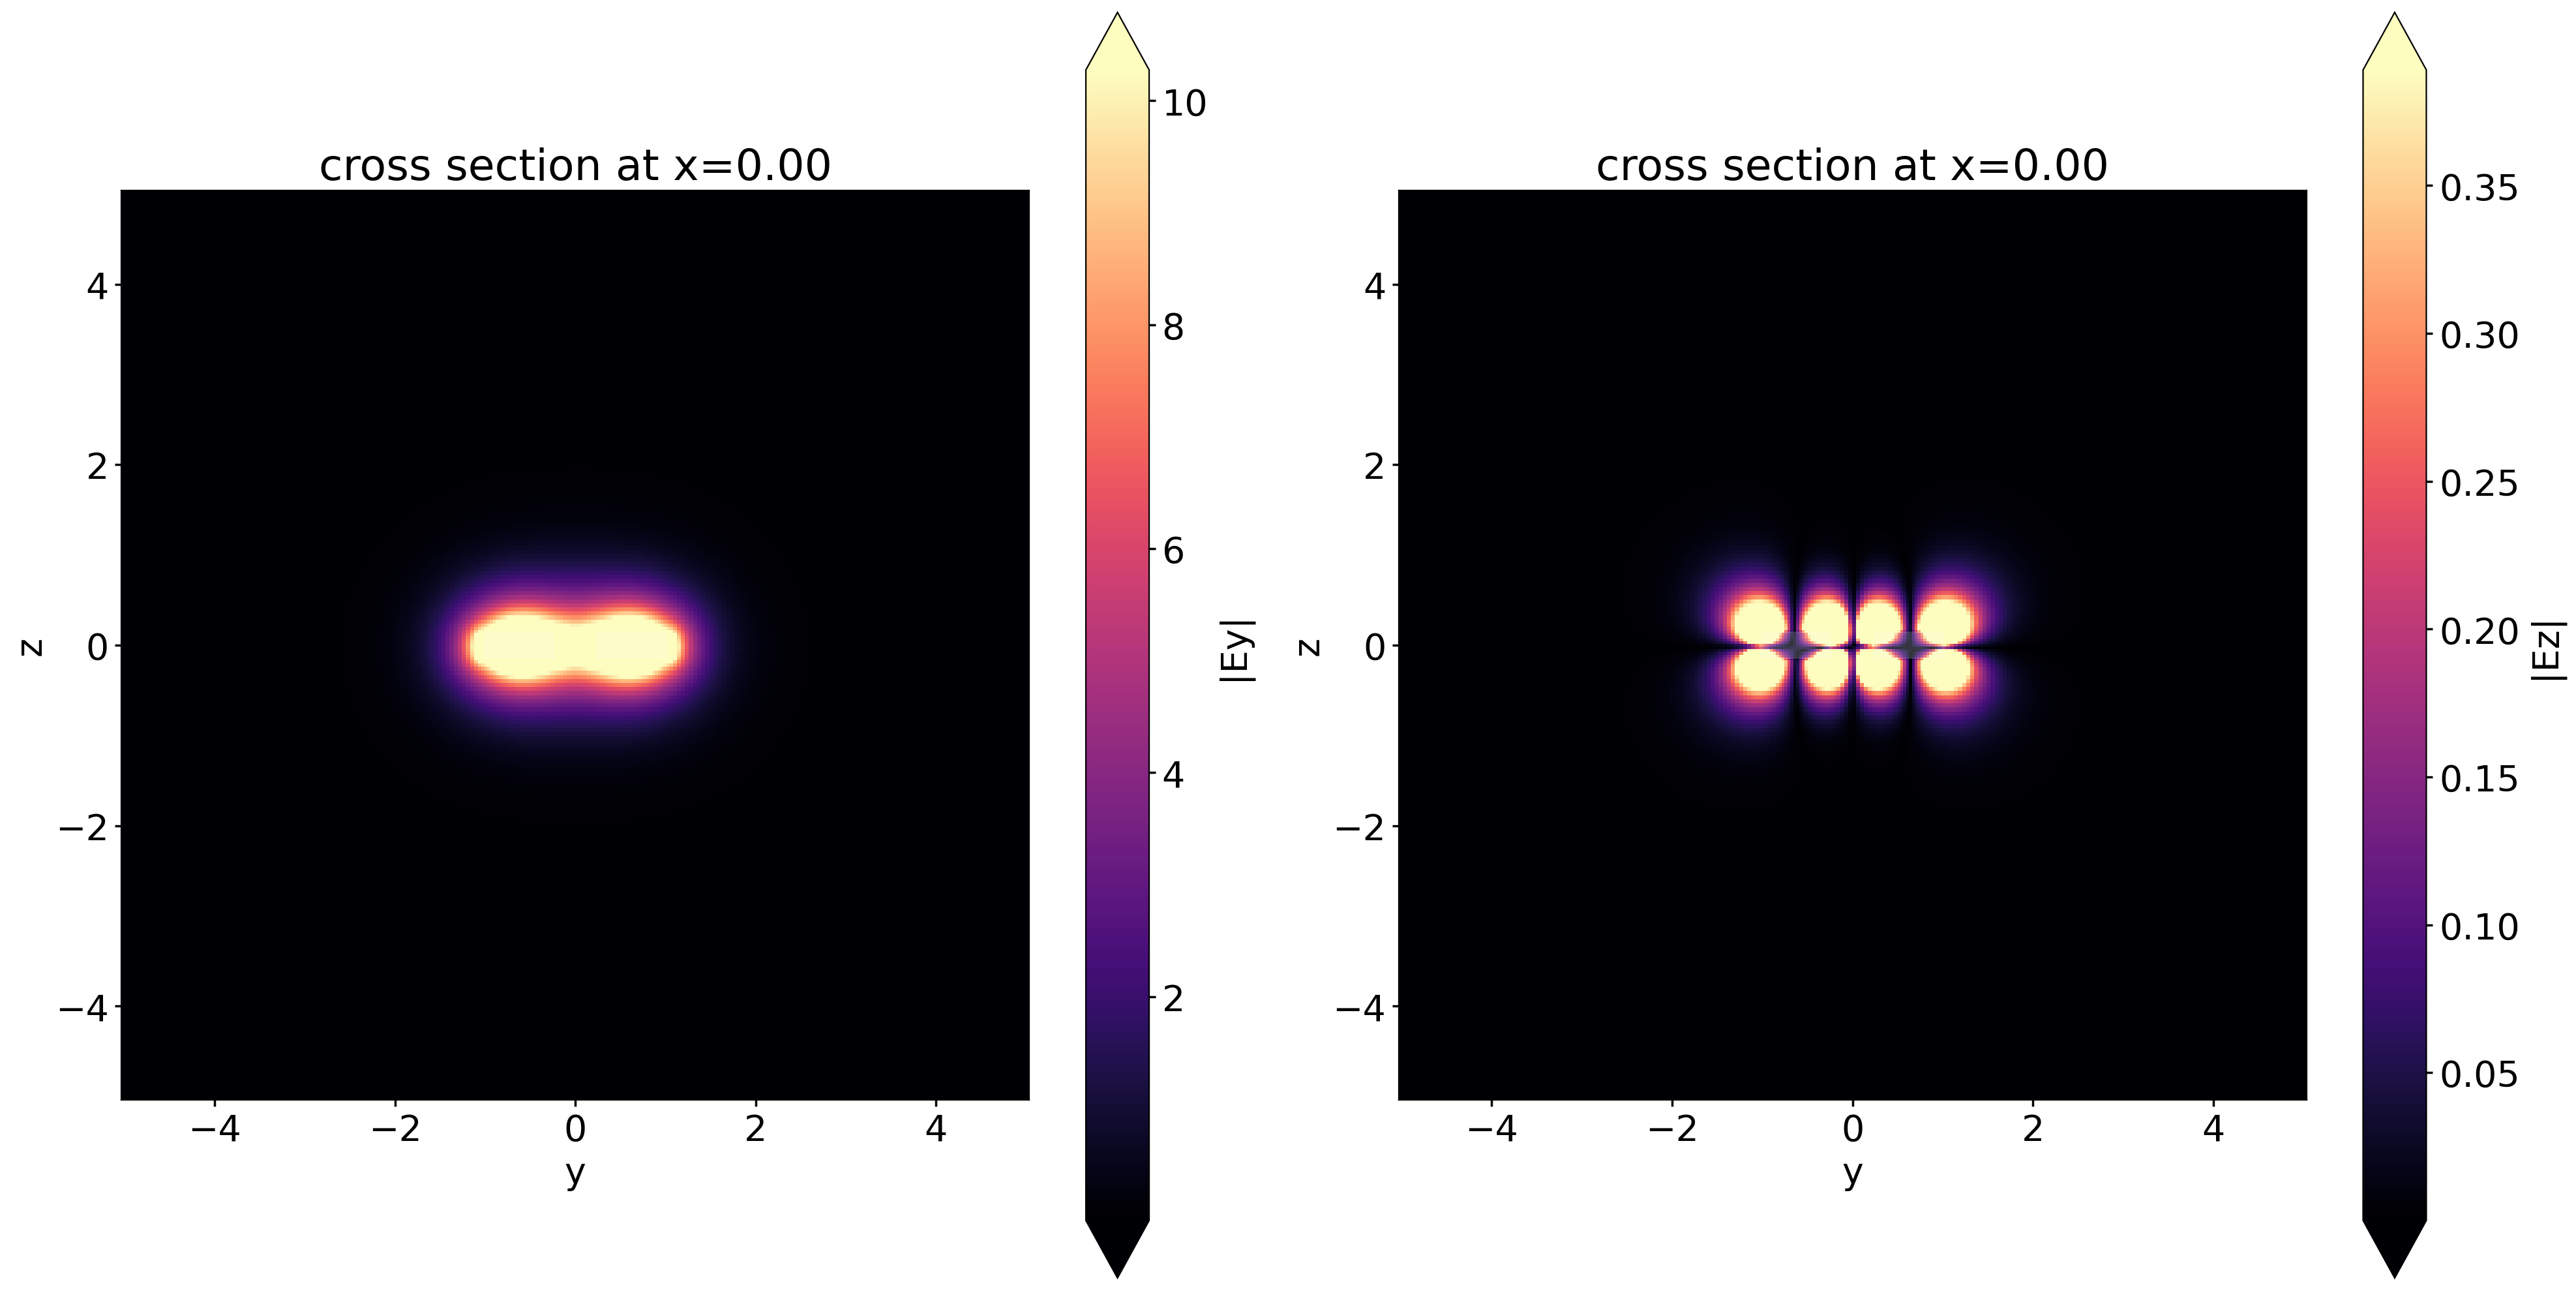

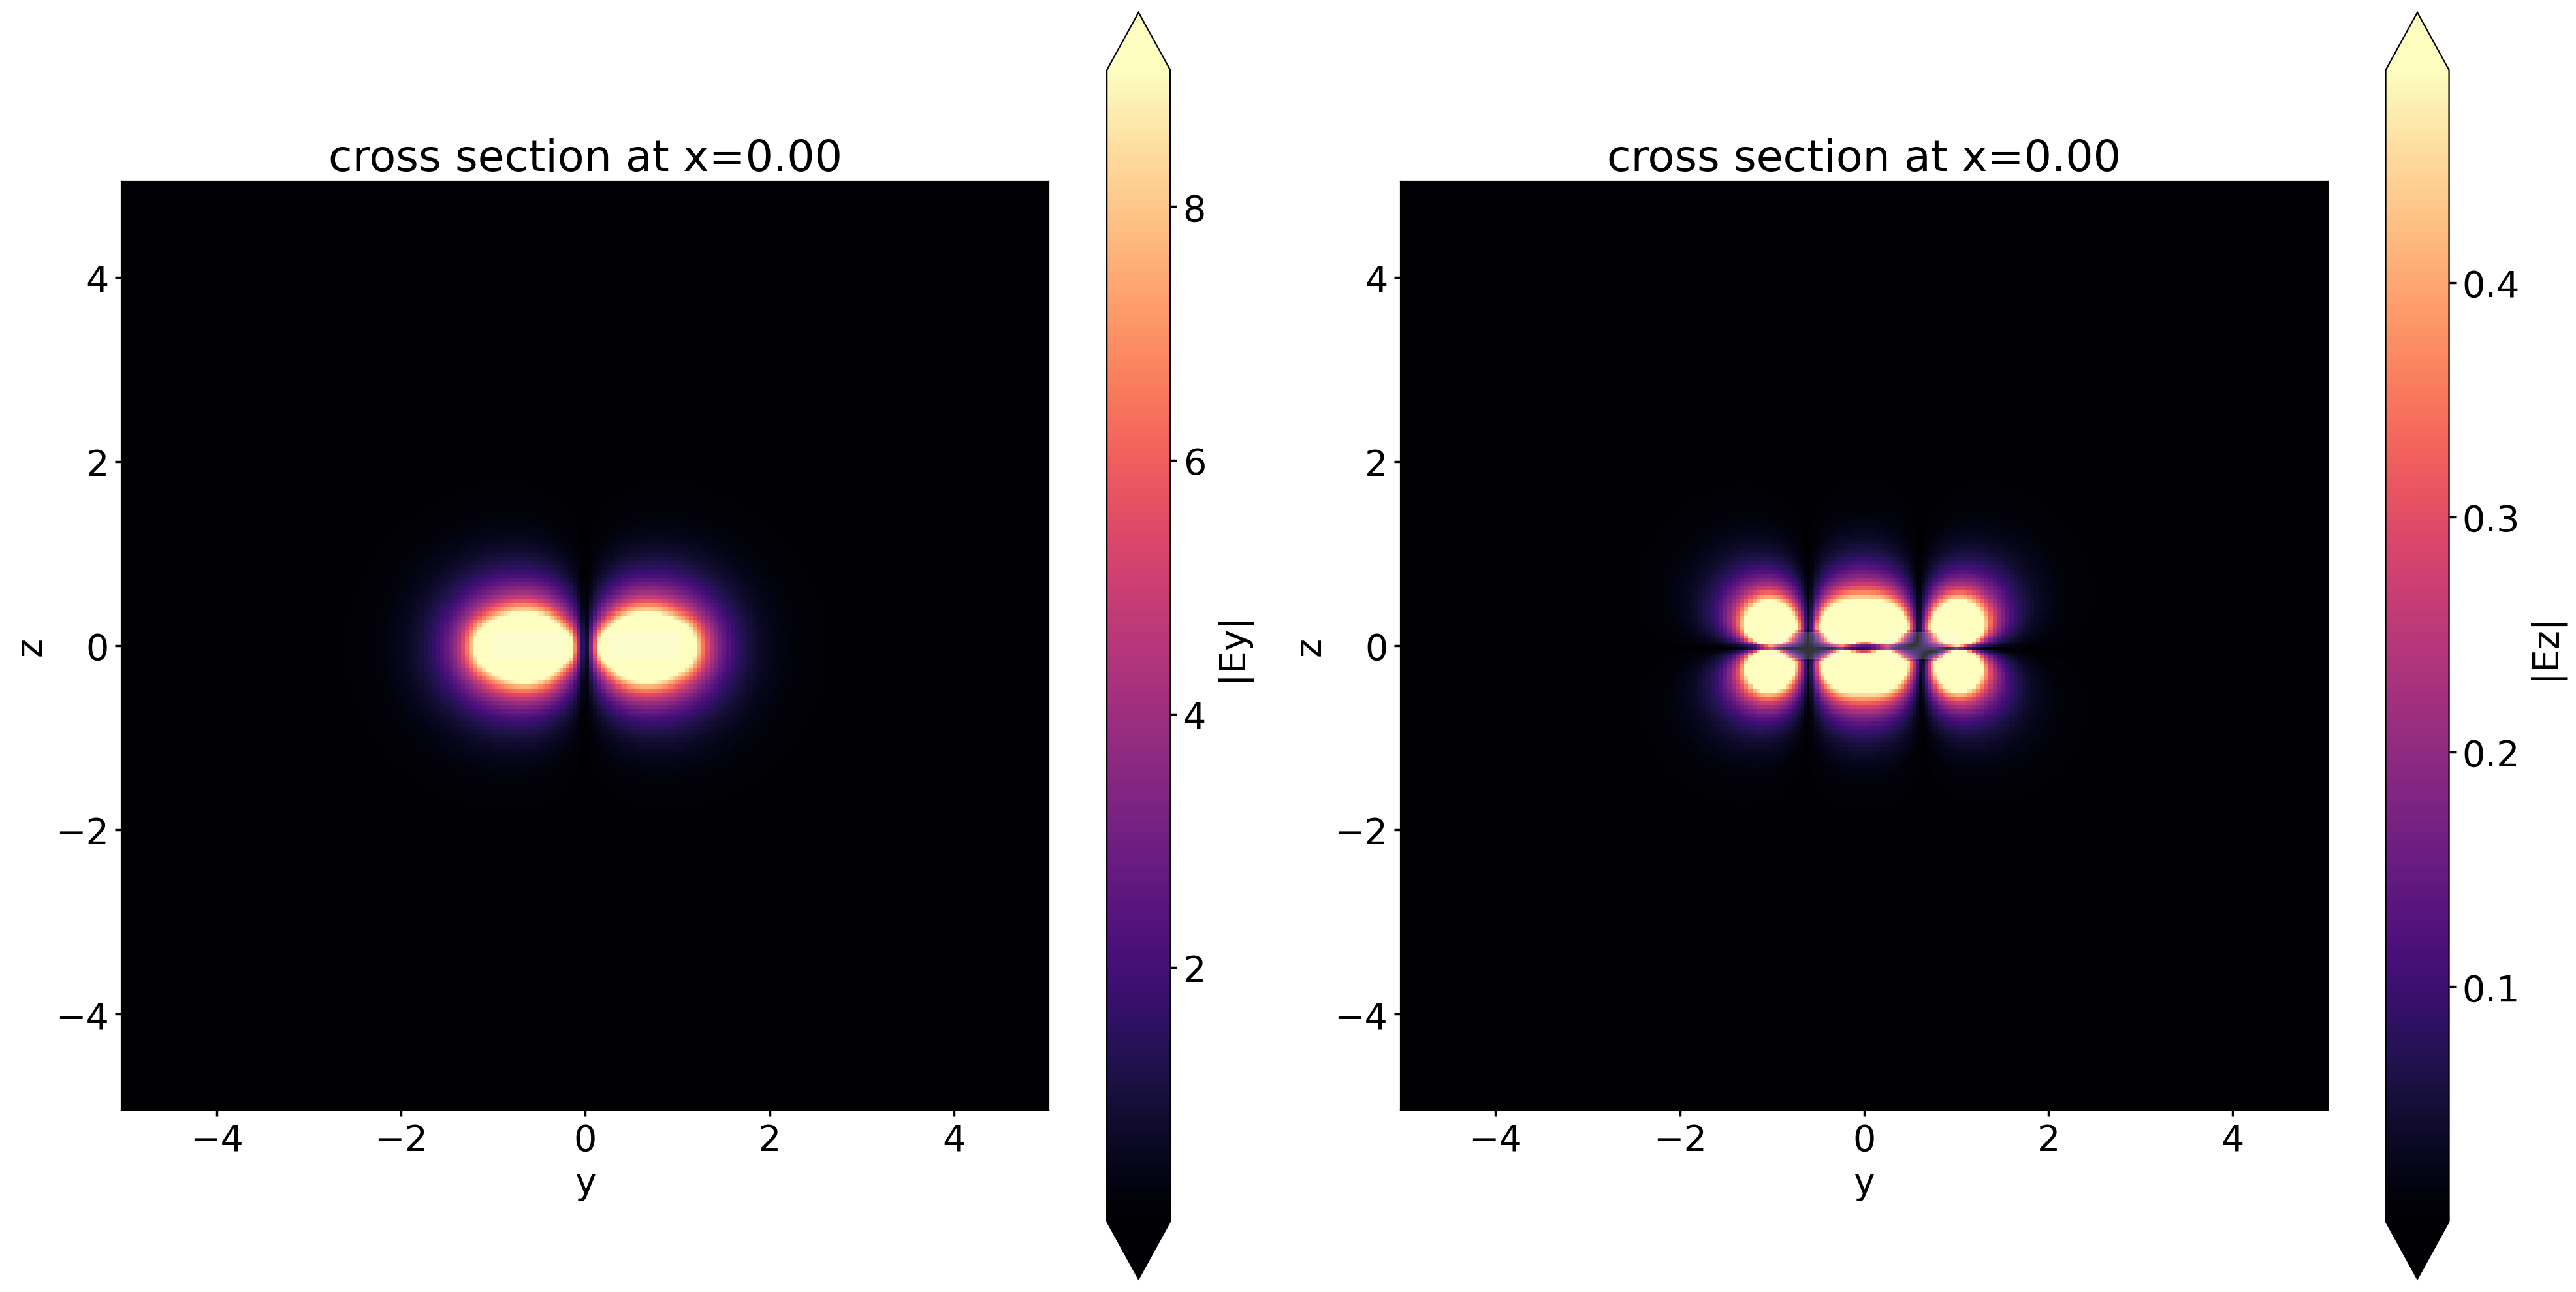

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
symmetric_wg_2_coupled_mode_solver_0C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
symmetric_wg_2_coupled_mode_solver_0C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
symmetric_wg_2_coupled_mode_solver_0C.plot_field("Ey", "abs", mode_index=1, f=freq0, ax=ax1)
symmetric_wg_2_coupled_mode_solver_0C.plot_field("Ez", "abs", mode_index=1, f=freq0, ax=ax2)
plt.tight_layout()
plt.show()

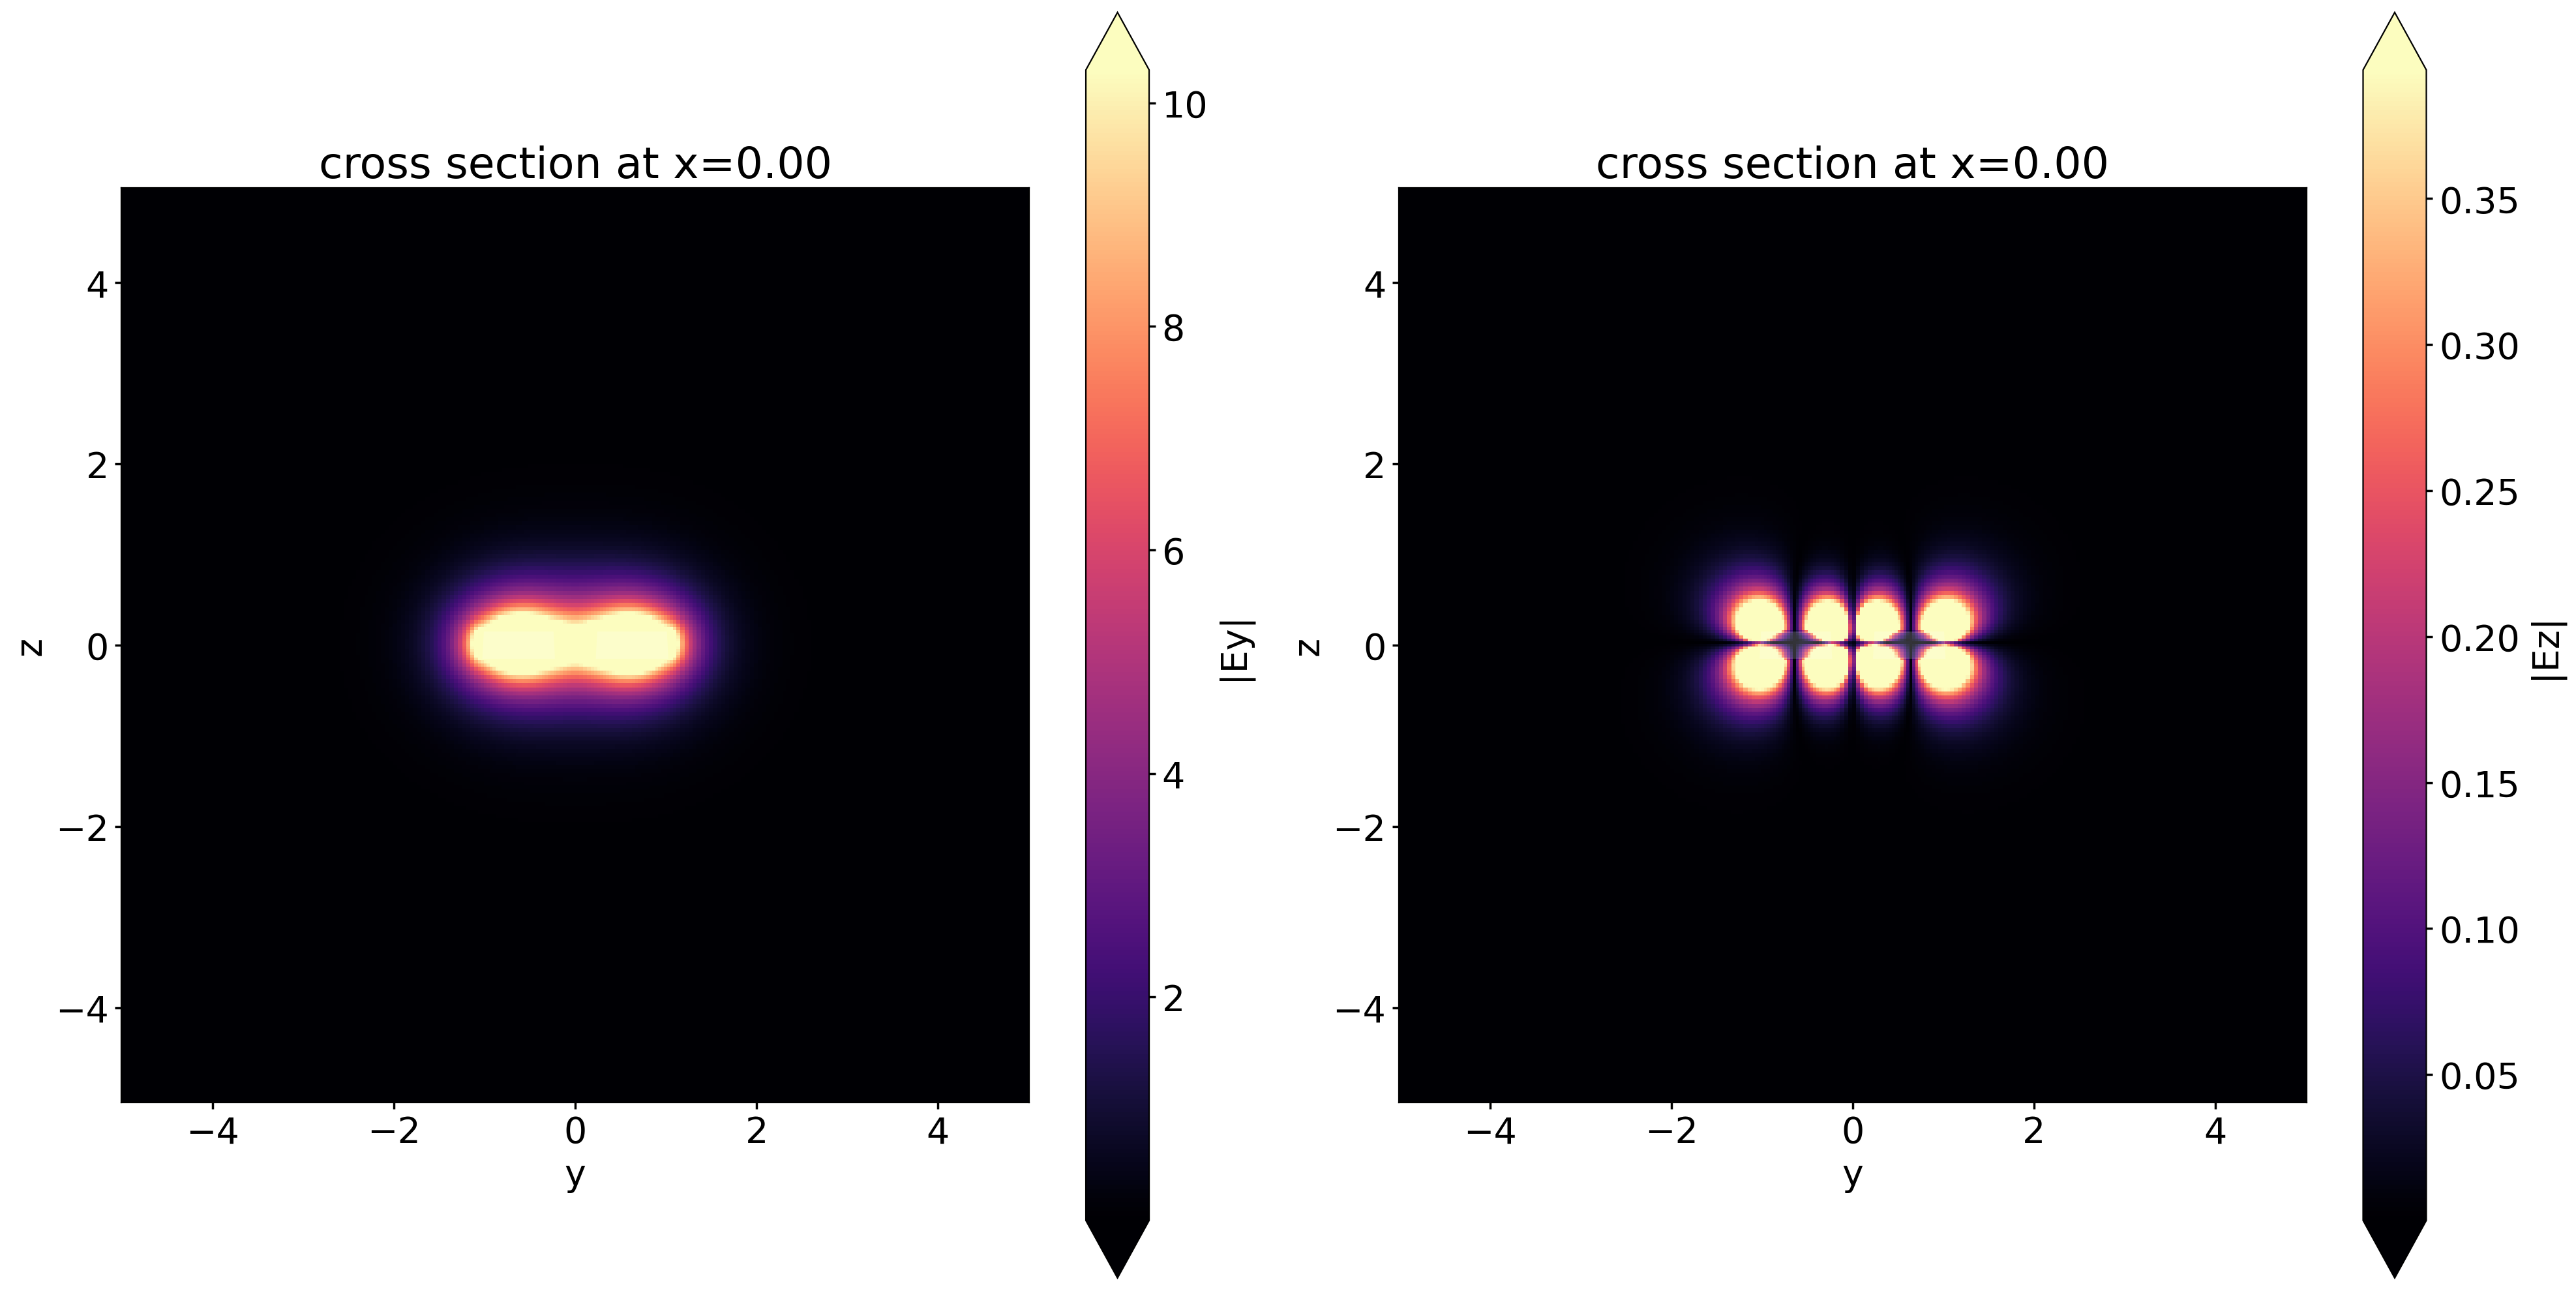

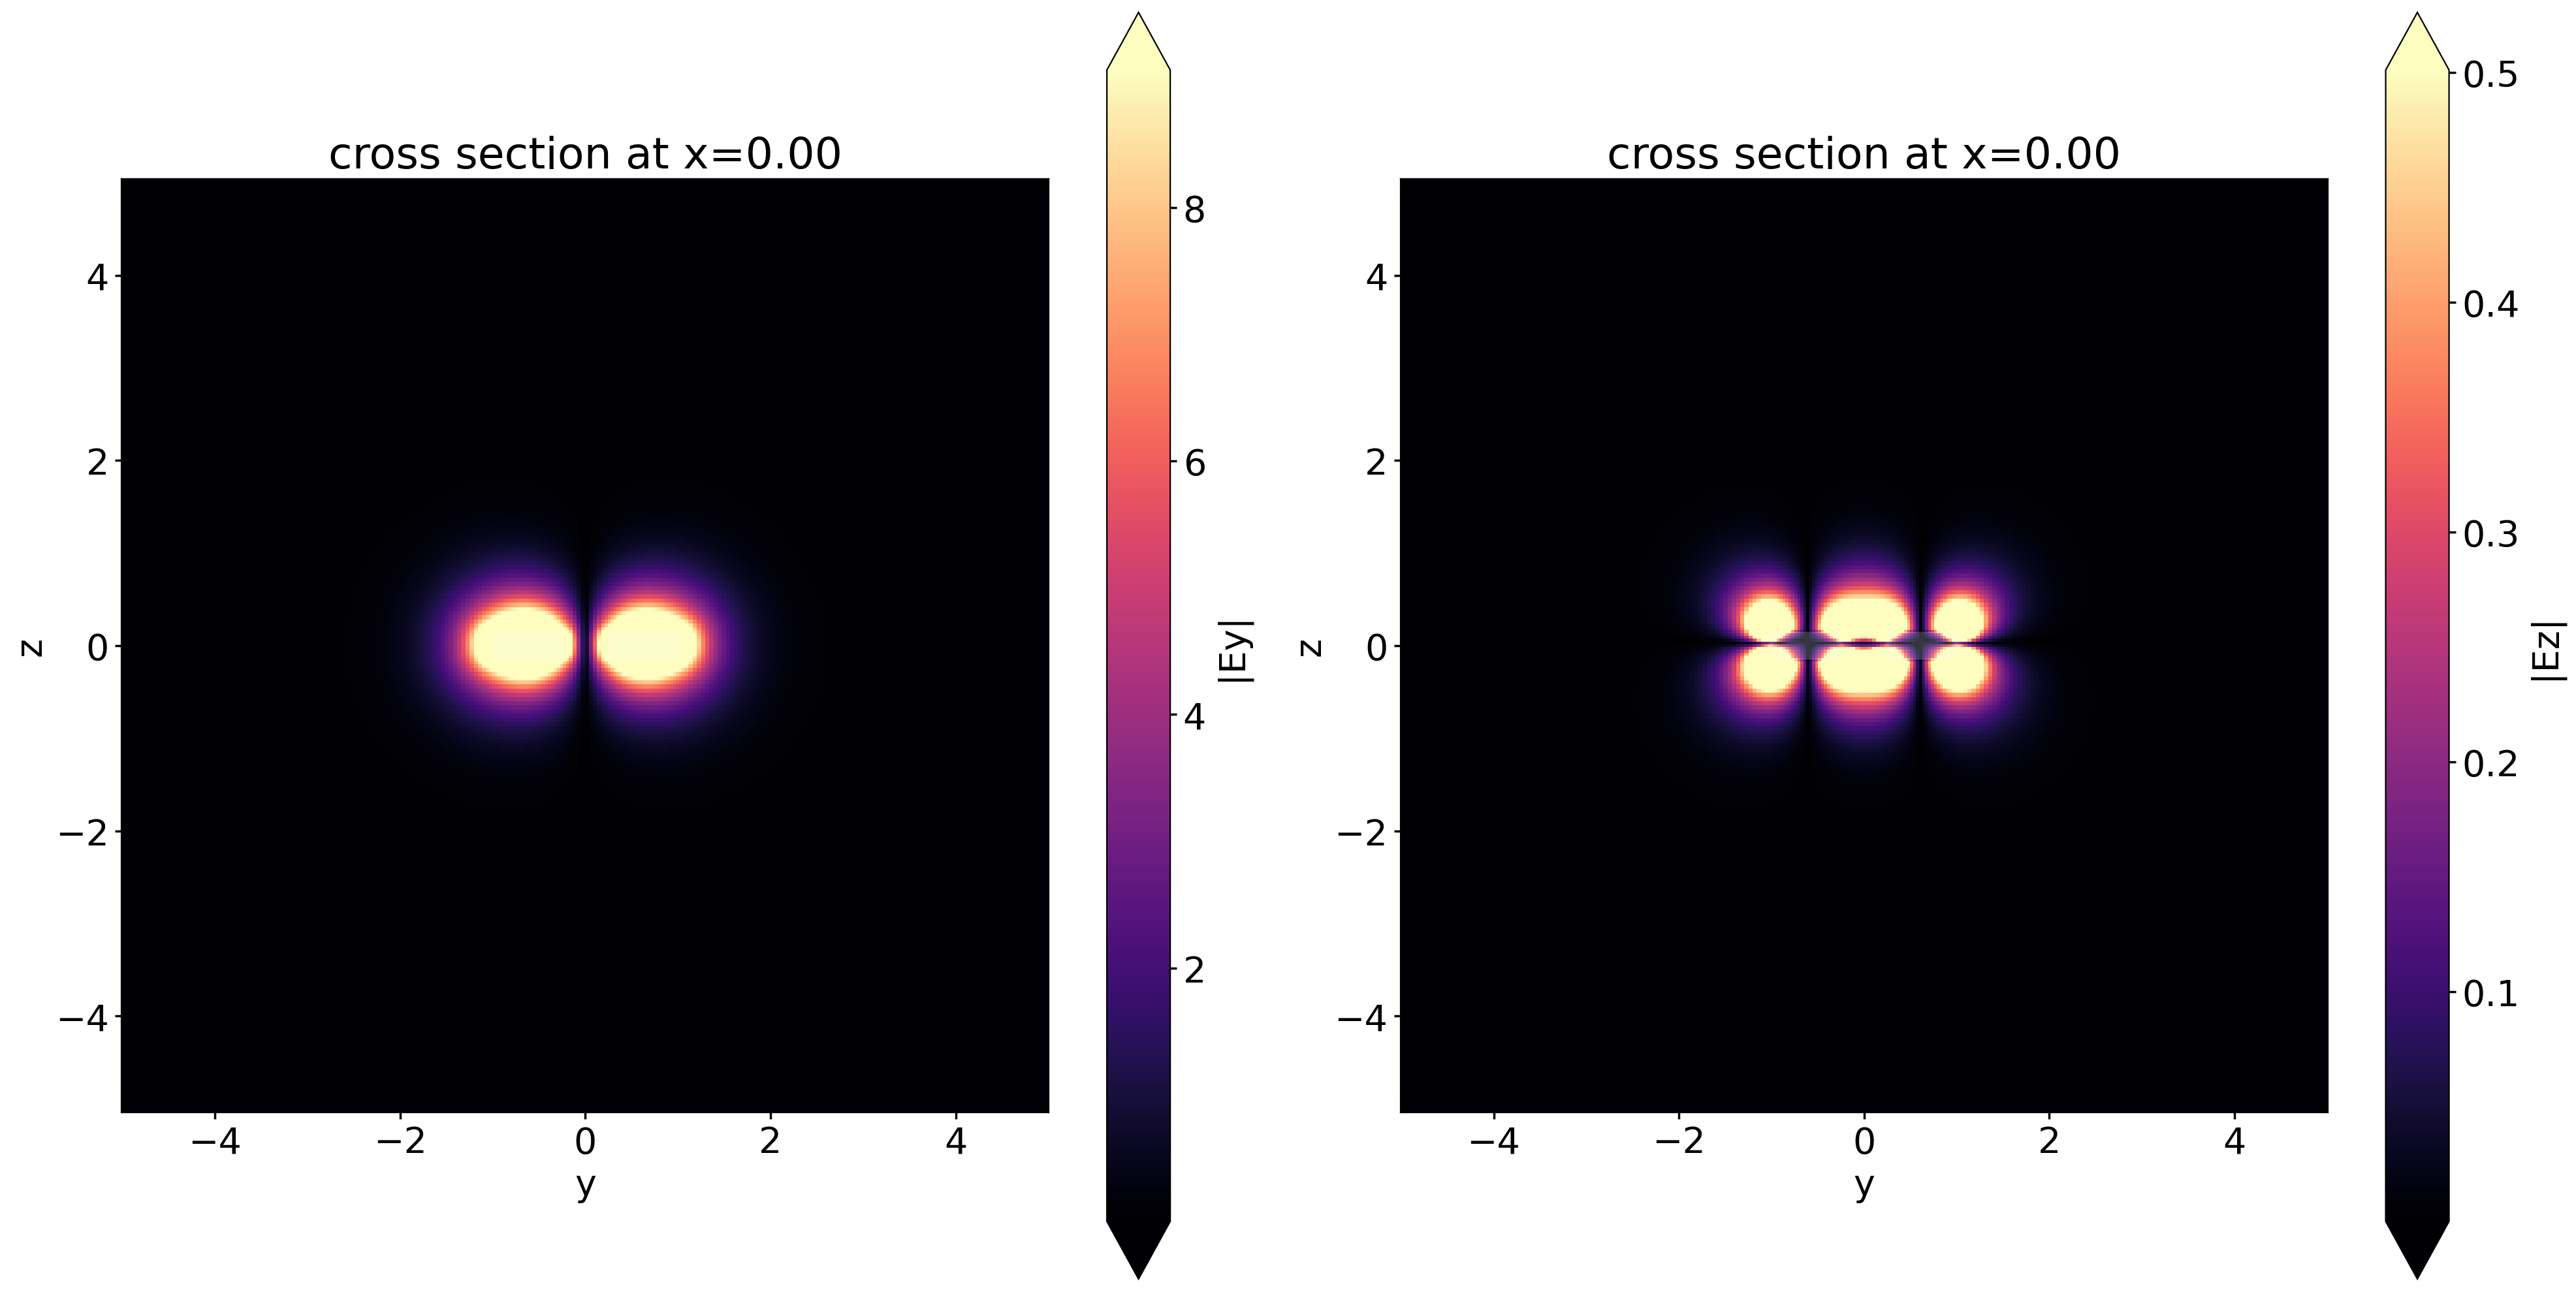

In [17]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
symmetric_wg_2_coupled_mode_solver_120C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
symmetric_wg_2_coupled_mode_solver_120C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
symmetric_wg_2_coupled_mode_solver_120C.plot_field("Ey", "abs", mode_index=1, f=freq0, ax=ax1)
symmetric_wg_2_coupled_mode_solver_120C.plot_field("Ez", "abs", mode_index=1, f=freq0, ax=ax2)
plt.tight_layout()
plt.show()

In [18]:
print("delta_neff_0C = ", symmetric_wg_2_coupled_delta_neff_0C)
print("delta_neff_120C = ", symmetric_wg_2_coupled_delta_neff_120C)

delta_neff_0C =  0.017243743
delta_neff_120C =  0.017162919


In [19]:
print((symmetric_wg_2_coupled_delta_neff_120C-symmetric_wg_2_coupled_delta_neff_0C)/symmetric_wg_2_coupled_delta_neff_0C*100)

-0.4687143489718437


# Symmetric coupled wg mode (wg width 1 = 800 nm, wg width 2 = 800 nm, gap = 405 nm) at 0C and 120C

In [20]:
Lx, Ly, Lz = 10, 10, 10
dl = 0.01

min_steps_per_wvl = 30

wg_width_1 = 0.8
wg_height_1 = 0.3
wg_sidewall_angle_1 = np.pi/2.0 - 87.0/180.0*np.pi

wg_width_2 = 0.8
wg_height_2 = 0.3
wg_sidewall_angle_2 = np.pi/2.0 - 87.0/180.0*np.pi

wg_gap = 0.405

gap = wg_gap + wg_width_1/2.0 + wg_width_2/2.0

target_neff = 1.587703

wg_n = 1.968
wg_k = 0

wvl_um = 1.31
freq0 = C_0/wvl_um

wg_medium = td.Medium.from_nk(n=1.968, k=0, freq=freq0)

wg_sidewall_angle_2 = np.pi/2.0 - 87.0/180.0*np.pi

num_freqs = 3

fwidth = 3200e9  # 3200 Ghz
freqs = np.linspace(freq0-fwidth/2.0, freq0+fwidth/2.0, num_freqs)

thickness_3sigma = 0.03
width_3sigma = 0.02
sidewall_angle_3sigma = 2/90*np.pi/2

num_samples = 1500

n_medium_0C = 1.968
n_background_0C = 1.45
n_medium_120C = 1.968 + 2.5e-5*120
n_background_120C = 1.45 + 1e-5*120

target_neff_0C = 1.587703
target_neff_120C = 1.5901577


In [21]:
symmetric_wg_3_coupled_mode_solver_0C, symmetric_wg_3_coupled_mode_data_0C, symmetric_wg_3_coupled_n_eff_0C, symmetric_wg_3_coupled_delta_neff_0C = coupled_wg_mode_data_calculator(
    wg_width_1, wg_height_1, wg_sidewall_angle_1, wg_width_2, wg_height_2, wg_sidewall_angle_2, gap, n_medium_0C, n_background_0C,target_neff_0C,  freqs, freq0, Lx = 20, Ly=20, Lz=20, num_modes = 2, dl=0.05, min_steps_per_wvl = 20
    )
symmetric_wg_3_coupled_mode_solver_120C, symmetric_wg_3_coupled_mode_data_120C, symmetric_wg_3_coupled_n_eff_120C, symmetric_wg_3_coupled_delta_neff_120C = coupled_wg_mode_data_calculator(
    wg_width_1, wg_height_1, wg_sidewall_angle_1, wg_width_2, wg_height_2, wg_sidewall_angle_2, gap, n_medium_120C, n_background_120C,target_neff_120C, freqs, freq0, Lx = 20, Ly=20, Lz=20, num_modes = 2, dl=0.05, min_steps_per_wvl = 20
    )

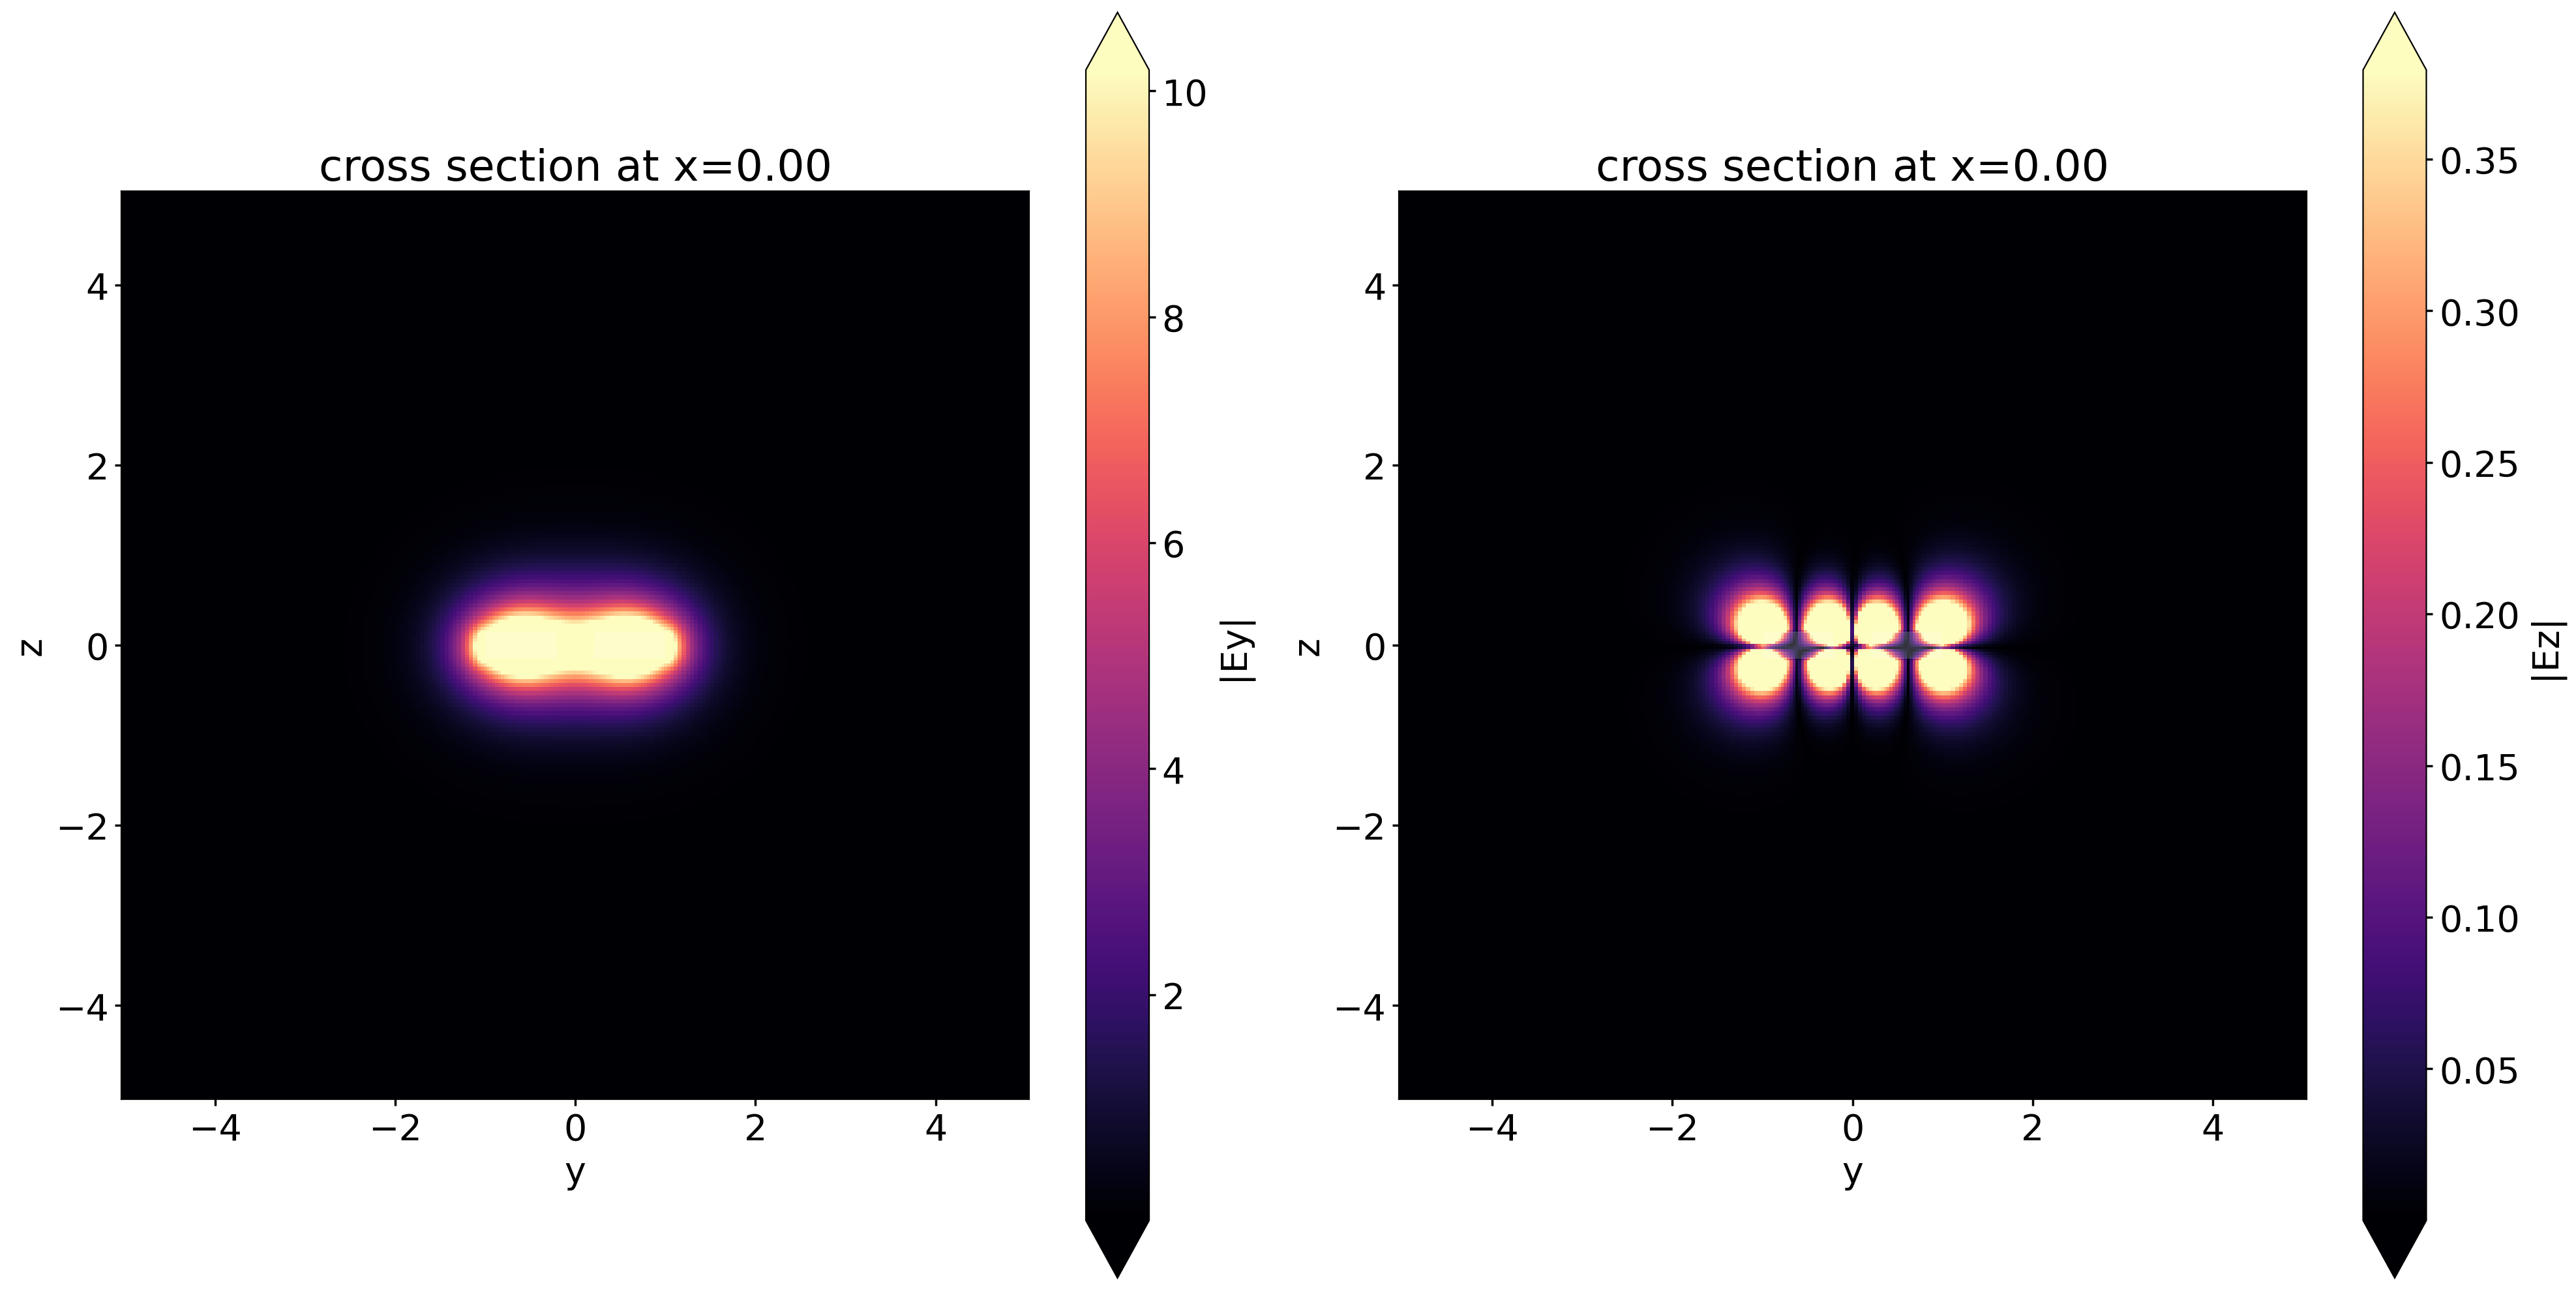

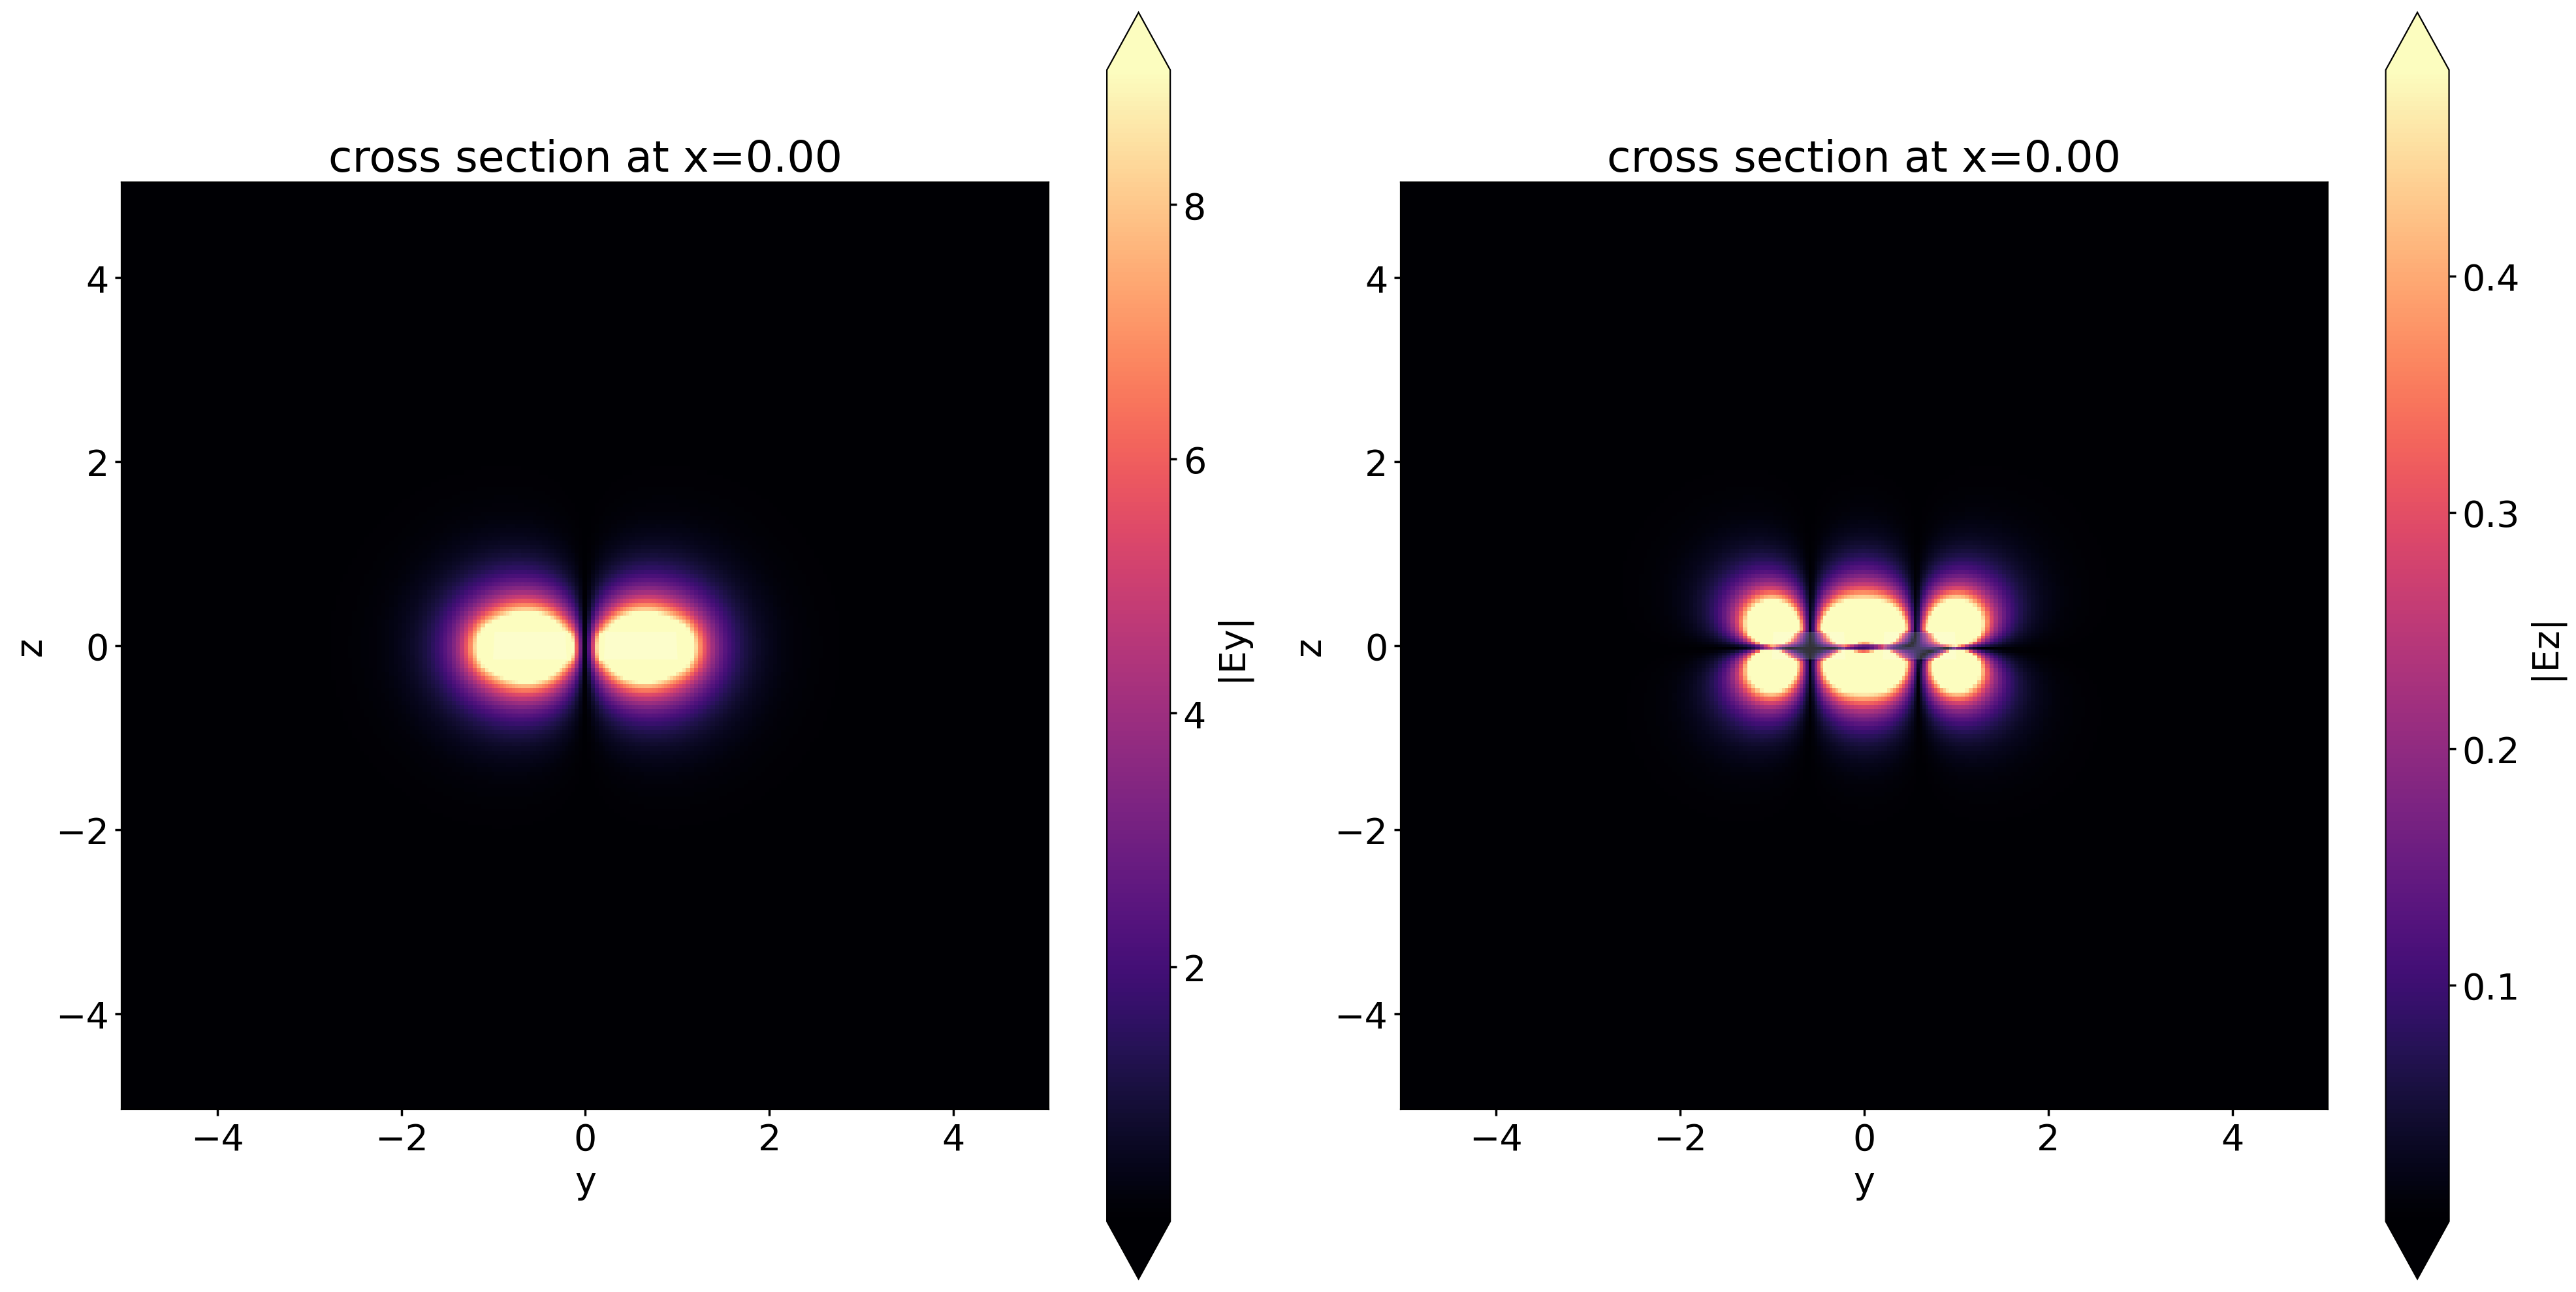

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
symmetric_wg_3_coupled_mode_solver_0C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
symmetric_wg_3_coupled_mode_solver_0C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
symmetric_wg_3_coupled_mode_solver_0C.plot_field("Ey", "abs", mode_index=1, f=freq0, ax=ax1)
symmetric_wg_3_coupled_mode_solver_0C.plot_field("Ez", "abs", mode_index=1, f=freq0, ax=ax2)
plt.tight_layout()
plt.show()

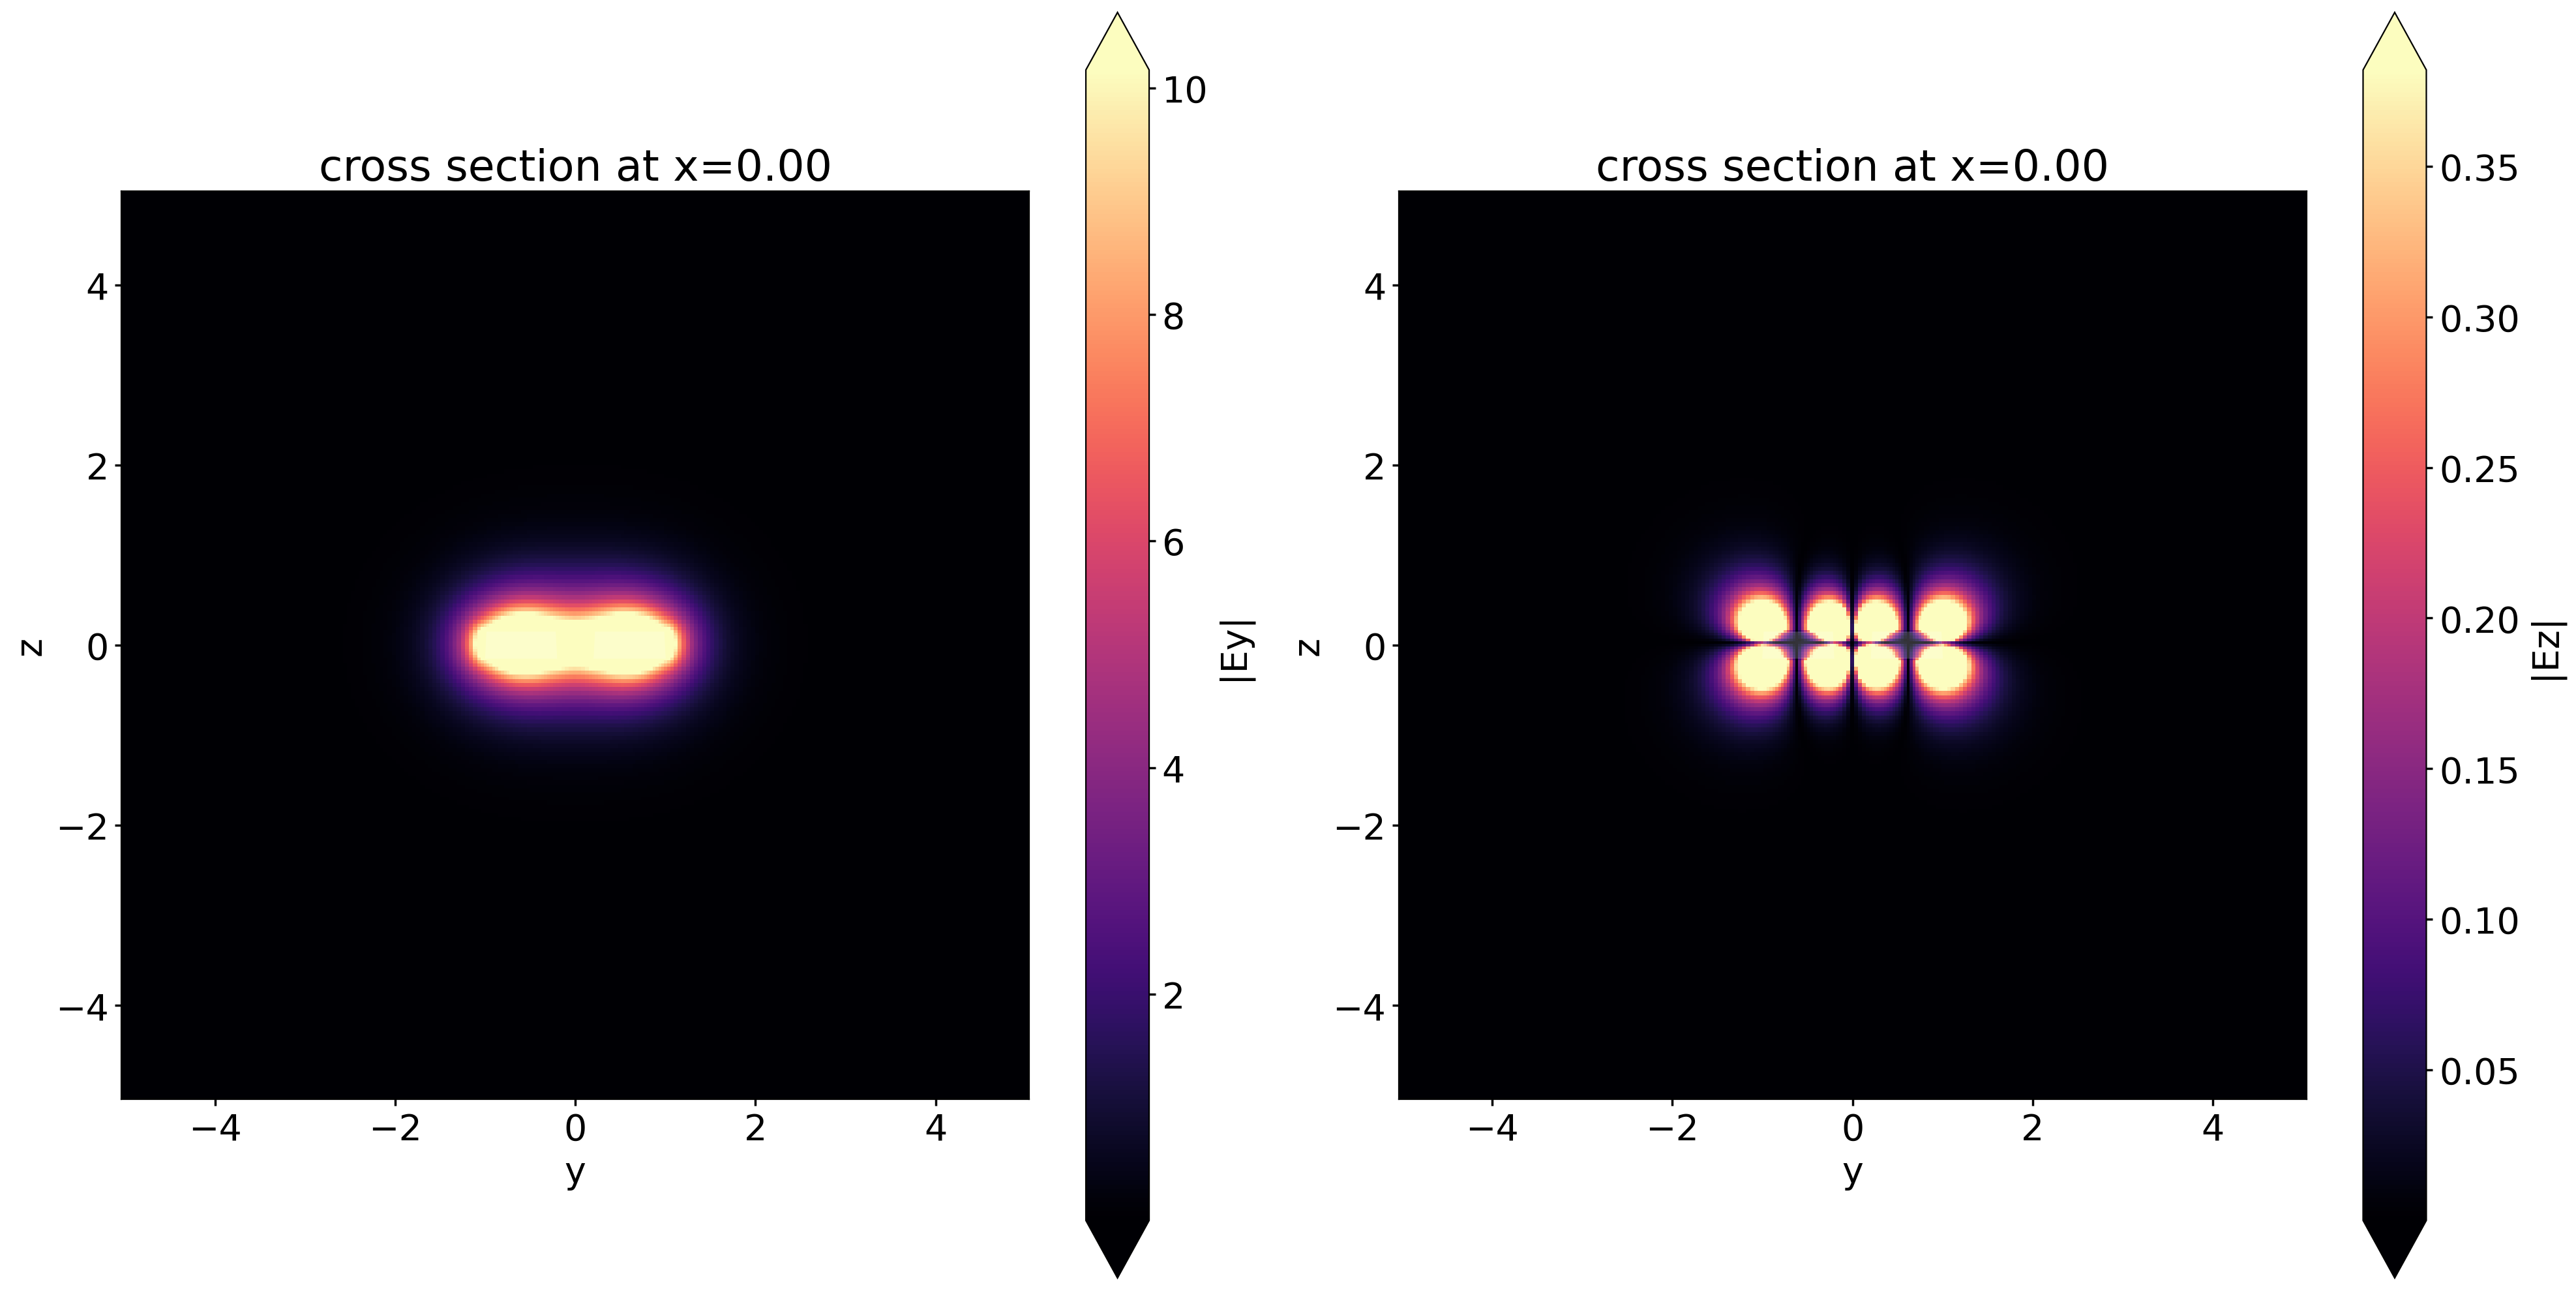

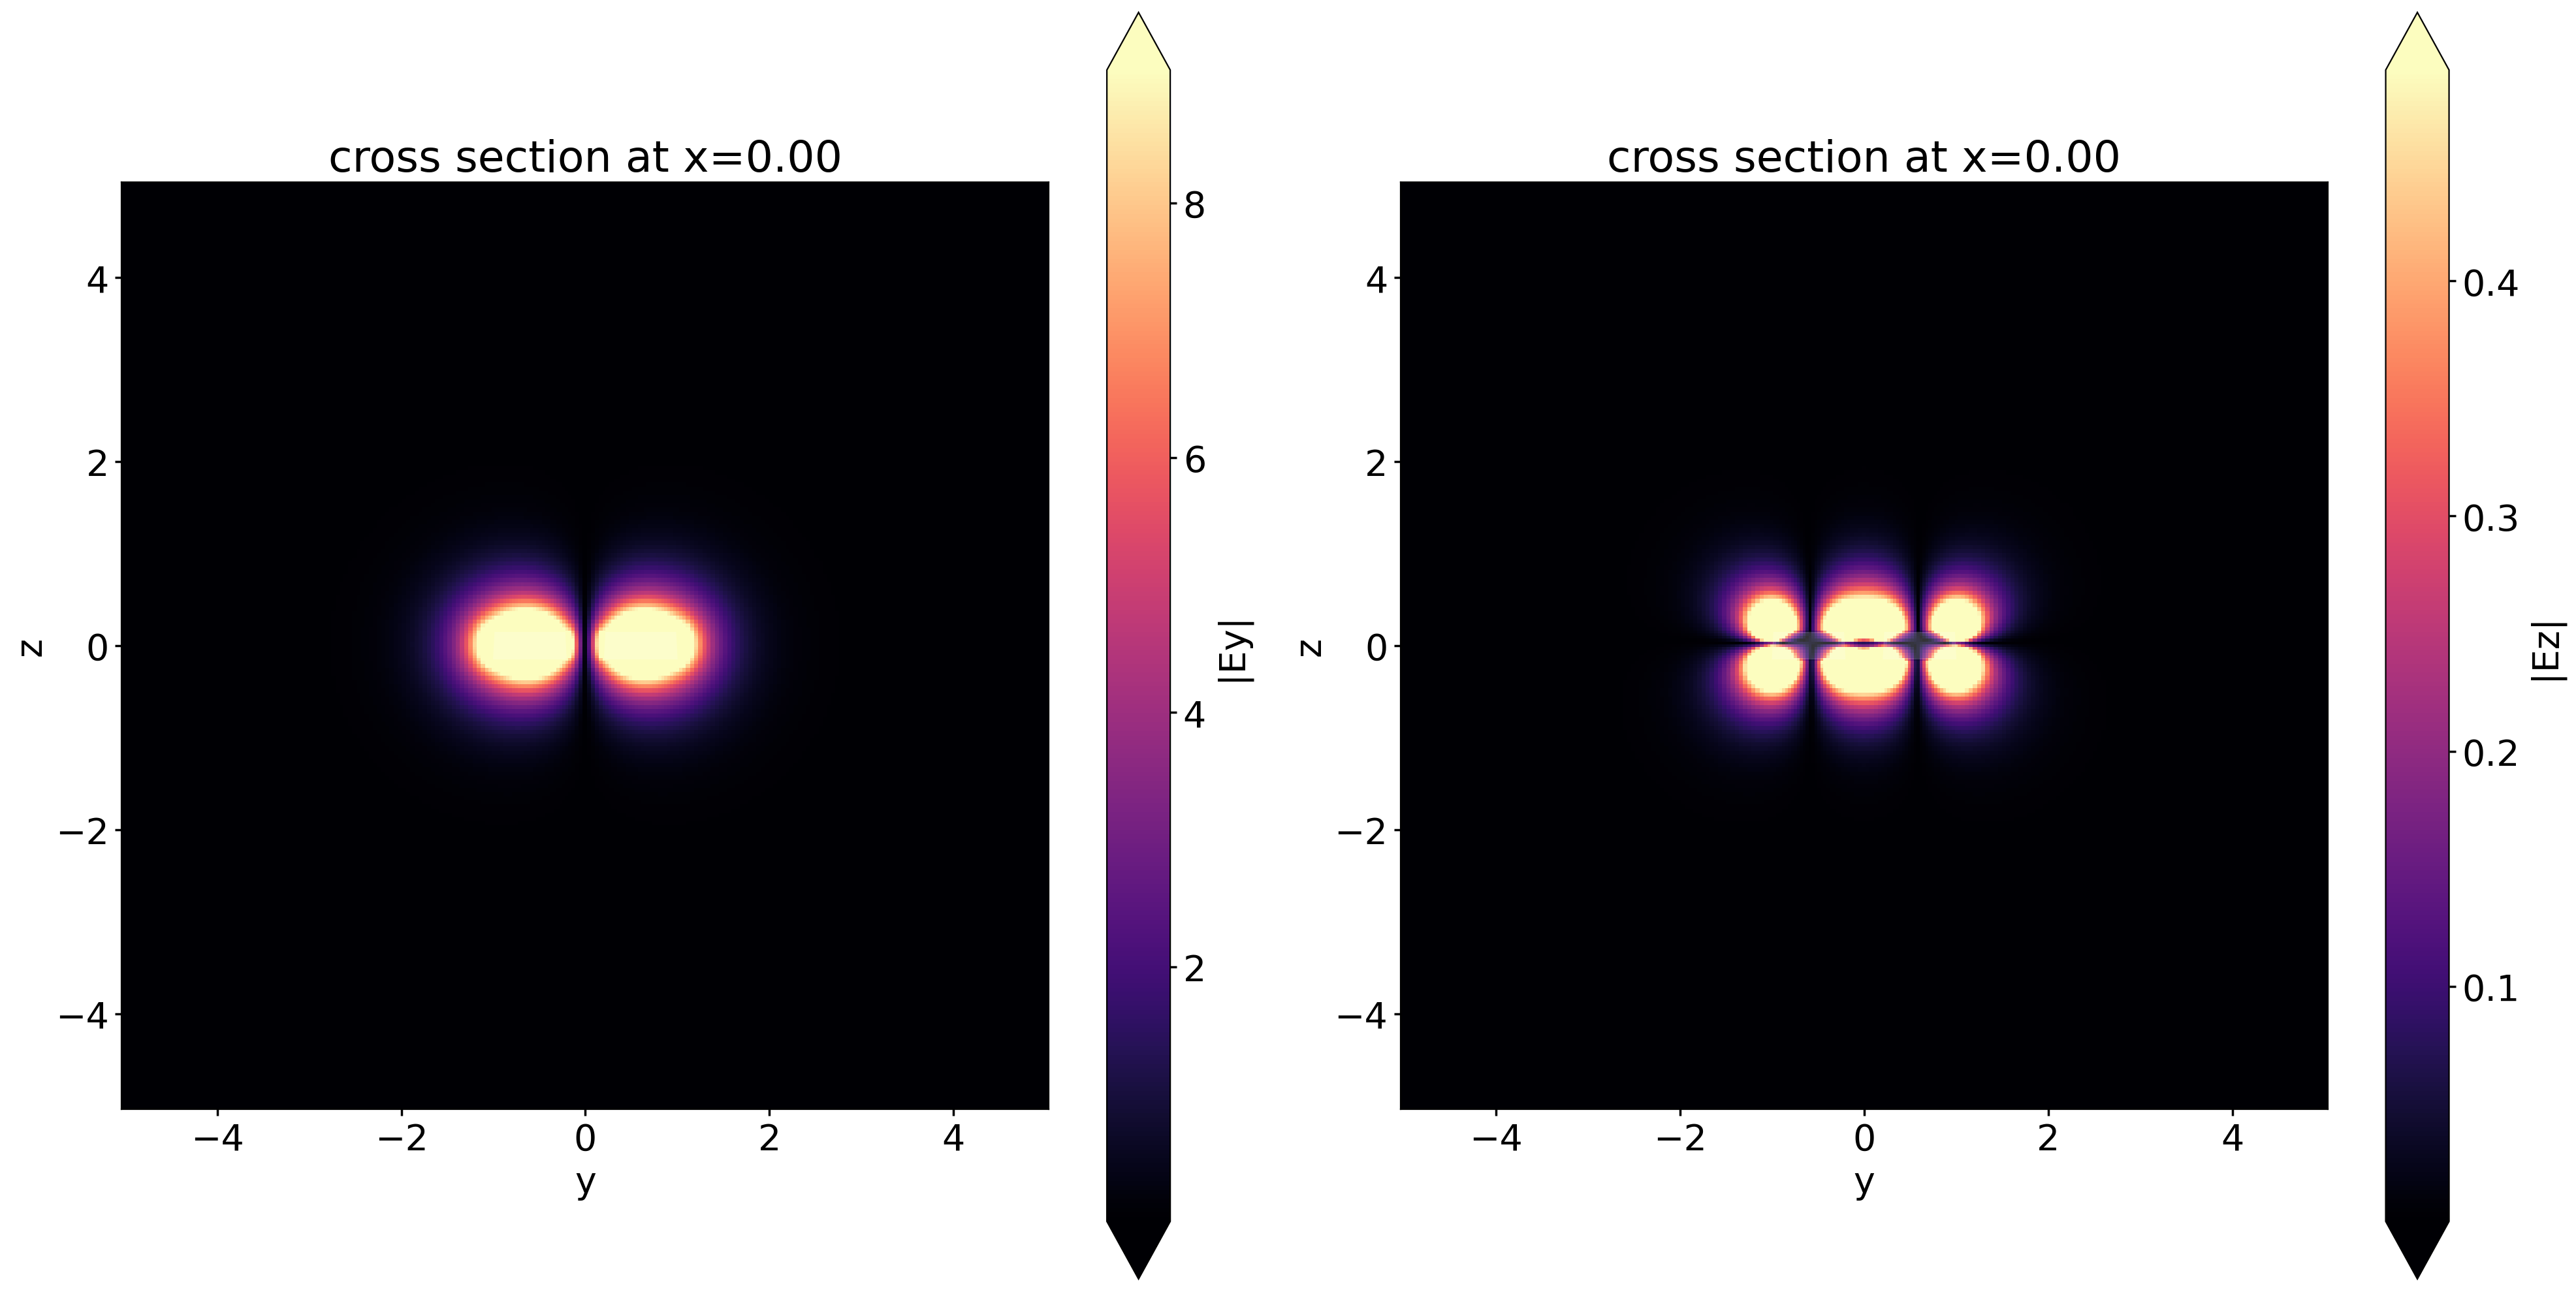

In [23]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
symmetric_wg_3_coupled_mode_solver_120C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
symmetric_wg_3_coupled_mode_solver_120C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
symmetric_wg_3_coupled_mode_solver_120C.plot_field("Ey", "abs", mode_index=1, f=freq0, ax=ax1)
symmetric_wg_3_coupled_mode_solver_120C.plot_field("Ez", "abs", mode_index=1, f=freq0, ax=ax2)
plt.tight_layout()
plt.show()

In [24]:
print("delta_neff_0C = ", symmetric_wg_3_coupled_delta_neff_0C)
print("delta_neff_120C = ", symmetric_wg_3_coupled_delta_neff_120C)

delta_neff_0C =  0.020360231
delta_neff_120C =  0.020276427


In [25]:
print((symmetric_wg_3_coupled_delta_neff_120C-symmetric_wg_3_coupled_delta_neff_0C)/symmetric_wg_3_coupled_delta_neff_0C*100)

-0.41160695254802704


# Asymmetric coupled wg mode (wg width 1 = 800 nm, wg width 2 = 773 nm, gap = 500 nm) at 0C and 120C

In [26]:
Lx, Ly, Lz = 10, 10, 10
dl = 0.01

min_steps_per_wvl = 30

wg_width_1 = 0.8
wg_height_1 = 0.3
wg_sidewall_angle_1 = np.pi/2.0 - 87.0/180.0*np.pi

wg_width_2 = 0.773
wg_height_2 = 0.3
wg_sidewall_angle_2 = np.pi/2.0 - 87.0/180.0*np.pi

wg_gap = 0.5 

gap = wg_gap + wg_width_1/2.0 + wg_width_2/2.0

target_neff = 1.587703

wg_n = 1.968
wg_k = 0

wvl_um = 1.31
freq0 = C_0/wvl_um

wg_medium = td.Medium.from_nk(n=1.968, k=0, freq=freq0)

wg_sidewall_angle_2 = np.pi/2.0 - 87.0/180.0*np.pi

num_freqs = 3

fwidth = 3200e9  # 3200 Ghz
freqs = np.linspace(freq0-fwidth/2.0, freq0+fwidth/2.0, num_freqs)

thickness_3sigma = 0.03
width_3sigma = 0.02
sidewall_angle_3sigma = 2/90*np.pi/2

num_samples = 1500

n_medium_0C = 1.968
n_background_0C = 1.45
n_medium_120C = 1.968 + 2.5e-5*120
n_background_120C = 1.45 + 1e-5*120

target_neff_0C = 1.587703
target_neff_120C = 1.5901577


In [27]:
asymmetric_wg_1_coupled_mode_solver_0C, asymmetric_wg_1_coupled_mode_data_0C, asymmetric_wg_1_coupled_n_eff_0C, asymmetric_wg_1_coupled_delta_neff_0C = coupled_wg_mode_data_calculator(
    wg_width_1, wg_height_1, wg_sidewall_angle_1, wg_width_2, wg_height_2, wg_sidewall_angle_2, gap, n_medium_0C, n_background_0C,target_neff_0C,  freqs, freq0, Lx = 20, Ly=20, Lz=20, num_modes = 2, dl=0.05, min_steps_per_wvl = 20
    )
asymmetric_wg_1_coupled_mode_solver_120C, asymmetric_wg_1_coupled_mode_data_120C, asymmetric_wg_1_coupled_n_eff_120C, asymmetric_wg_1_coupled_delta_neff_120C = coupled_wg_mode_data_calculator(
    wg_width_1, wg_height_1, wg_sidewall_angle_1, wg_width_2, wg_height_2, wg_sidewall_angle_2, gap, n_medium_120C, n_background_120C,target_neff_120C, freqs, freq0, Lx = 20, Ly=20, Lz=20, num_modes = 2, dl=0.05, min_steps_per_wvl = 20
    )

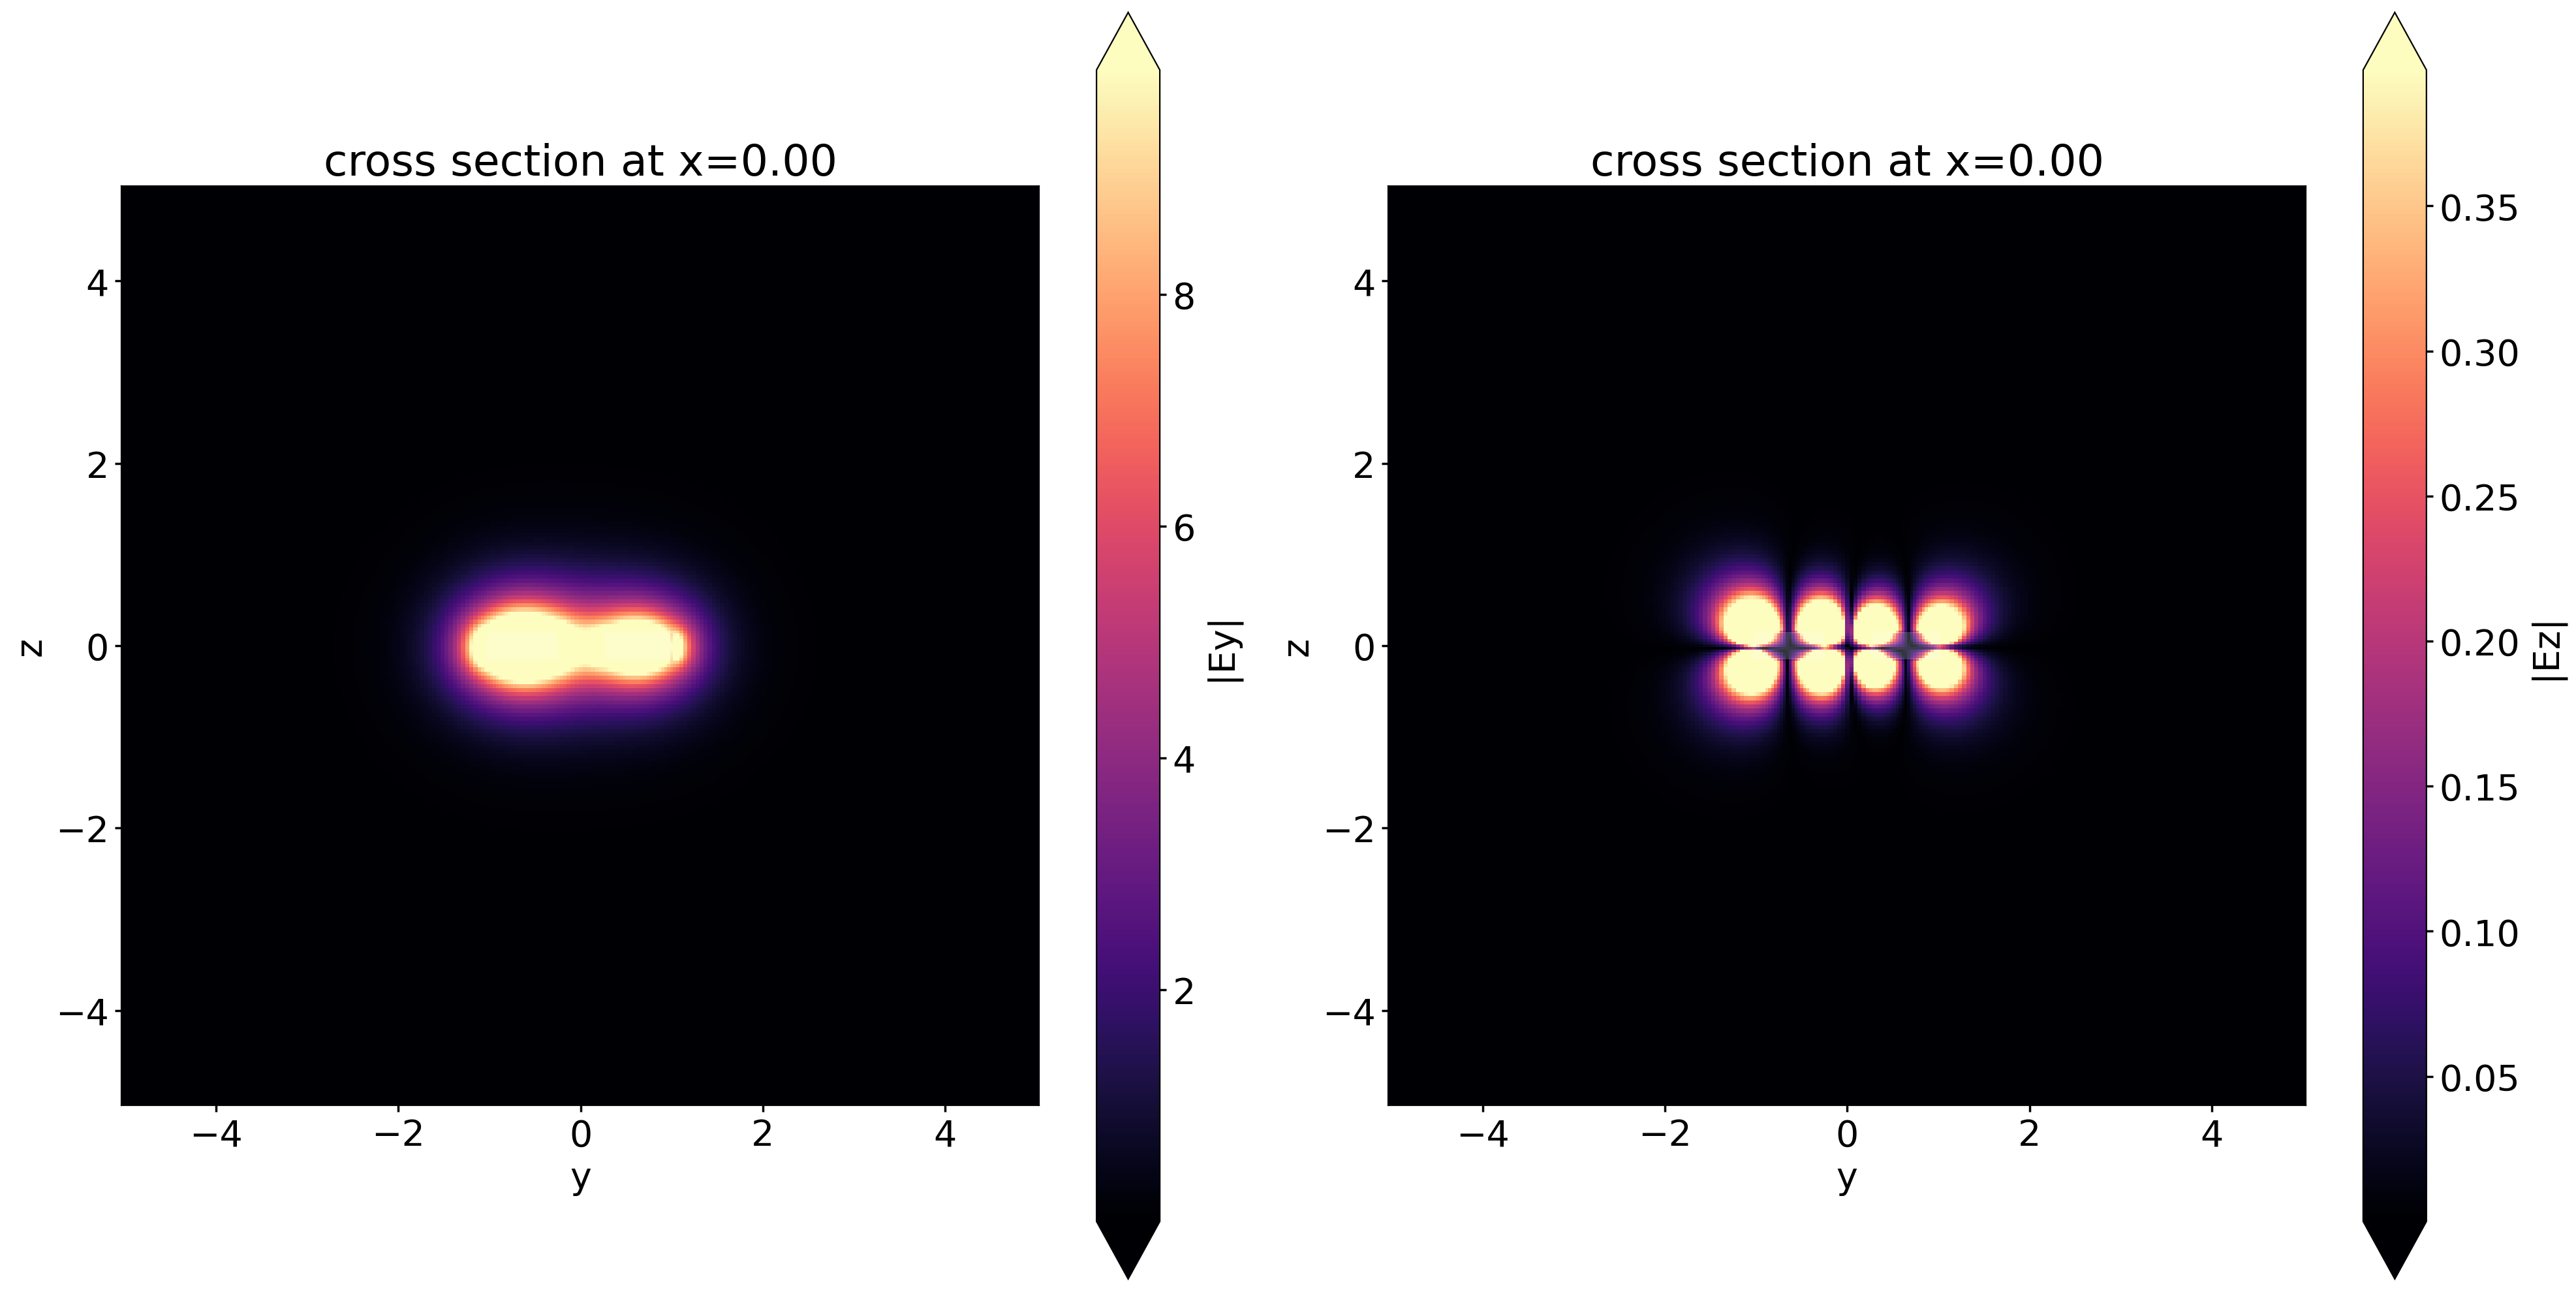

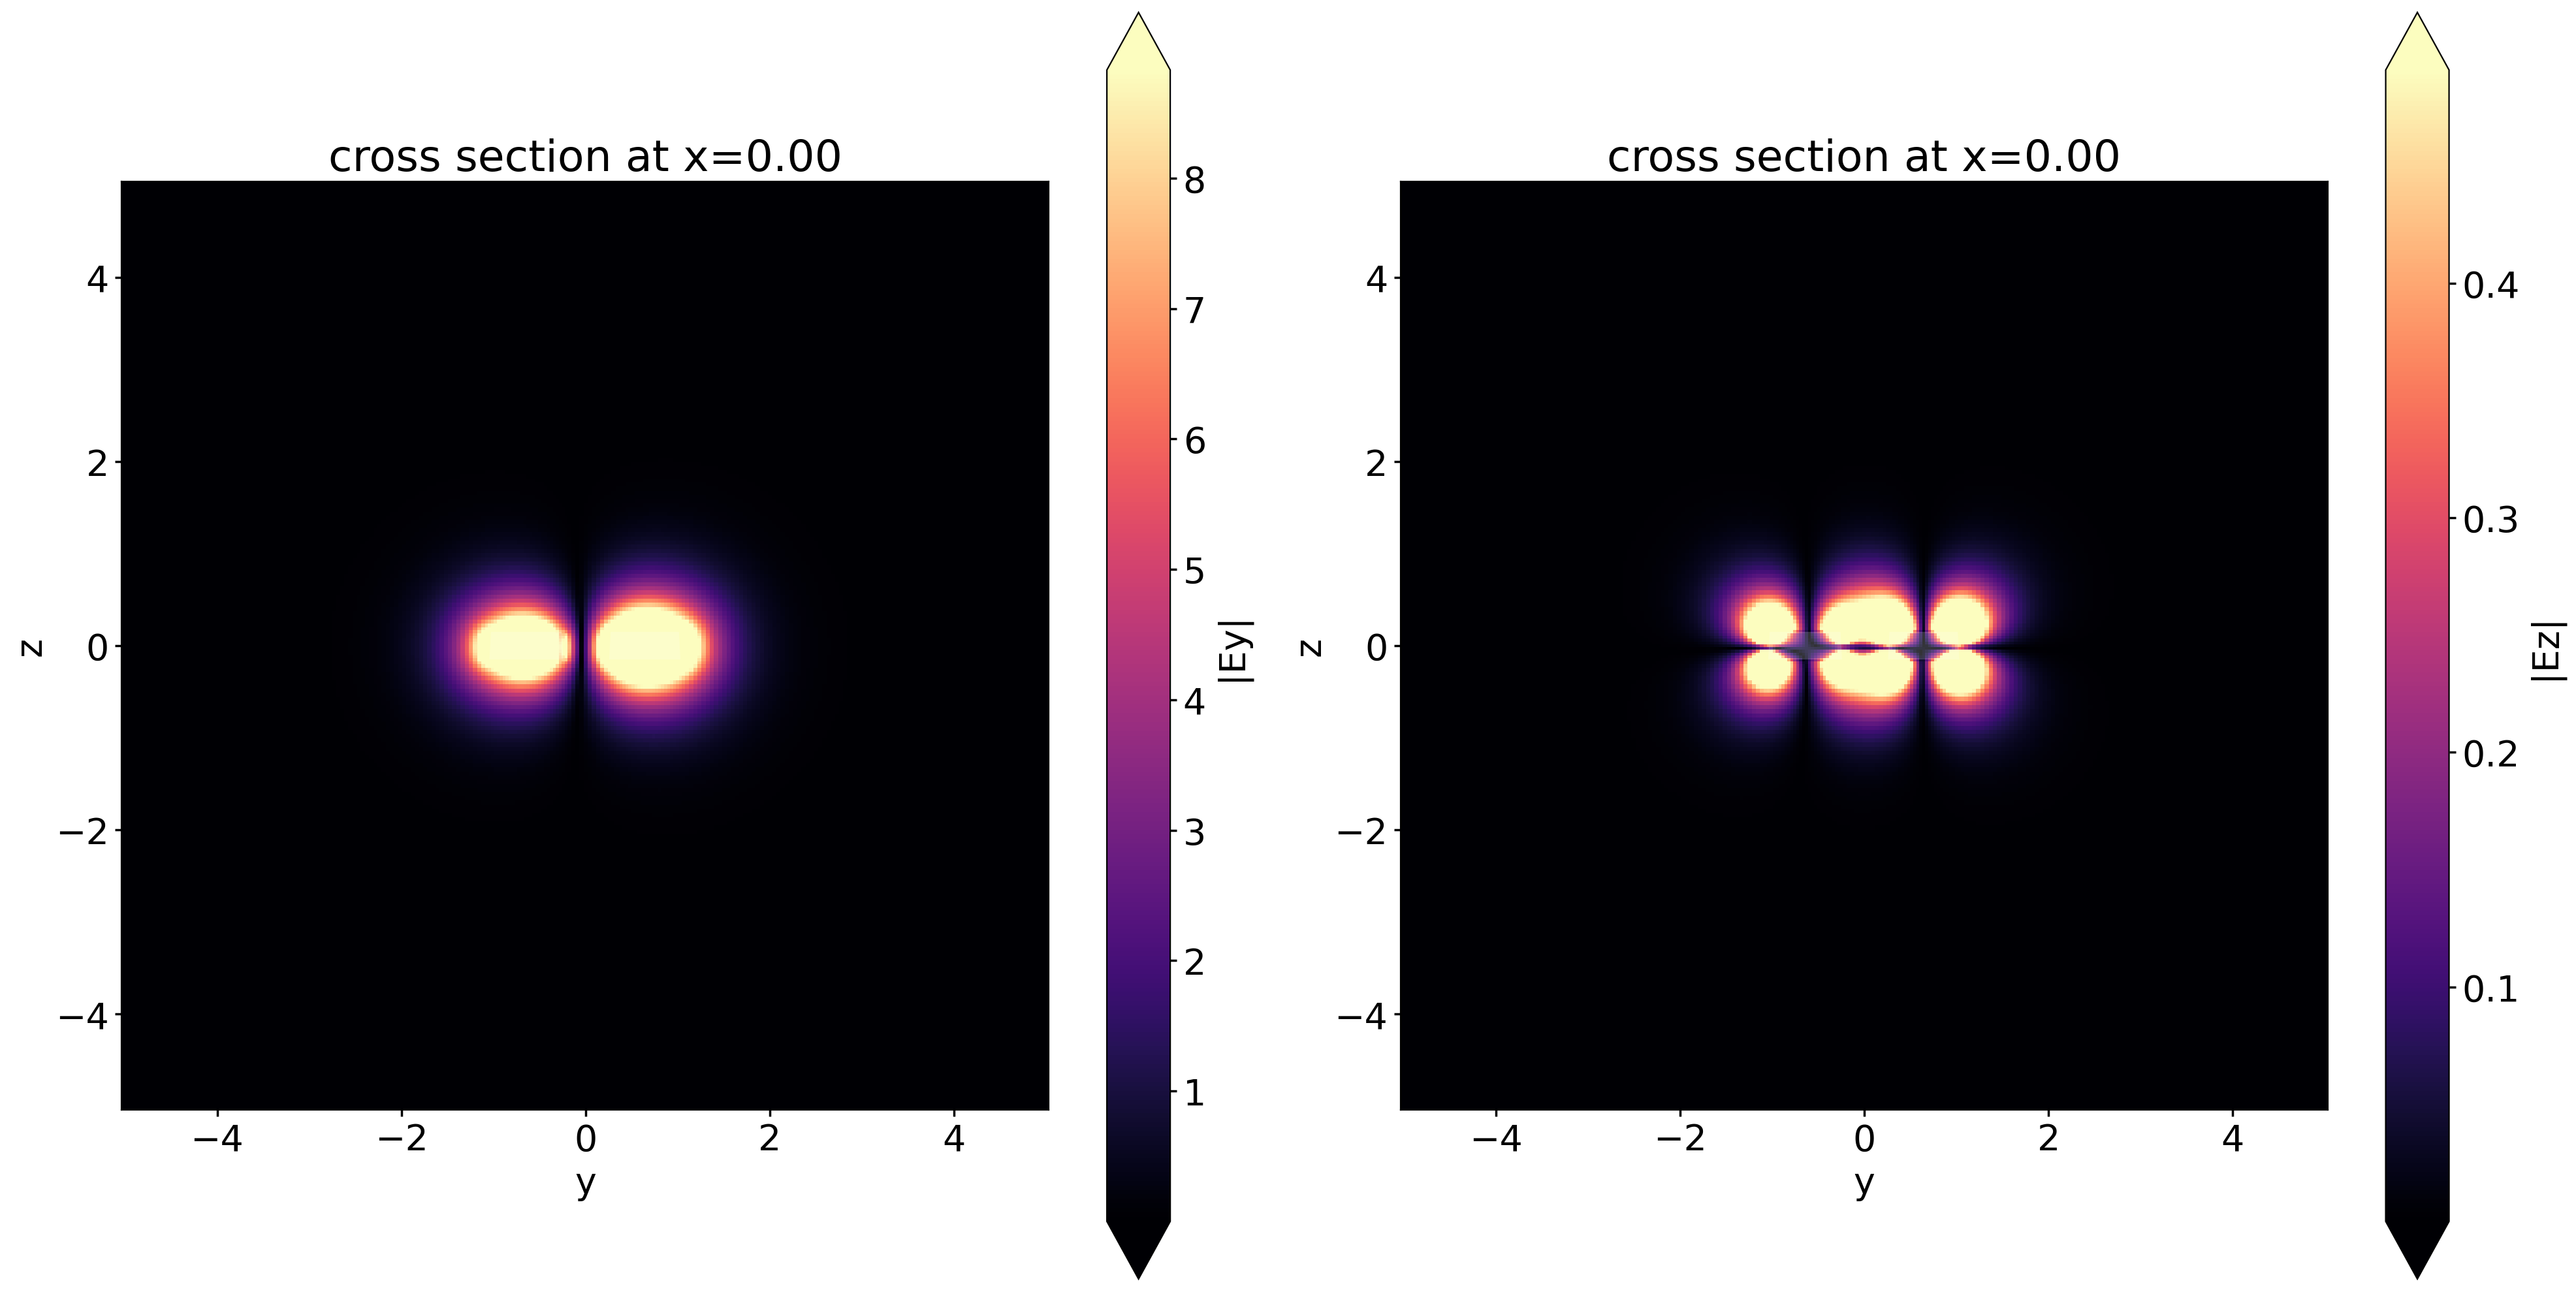

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
asymmetric_wg_1_coupled_mode_solver_0C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
asymmetric_wg_1_coupled_mode_solver_0C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
asymmetric_wg_1_coupled_mode_solver_0C.plot_field("Ey", "abs", mode_index=1, f=freq0, ax=ax1)
asymmetric_wg_1_coupled_mode_solver_0C.plot_field("Ez", "abs", mode_index=1, f=freq0, ax=ax2)
plt.tight_layout()
plt.show()

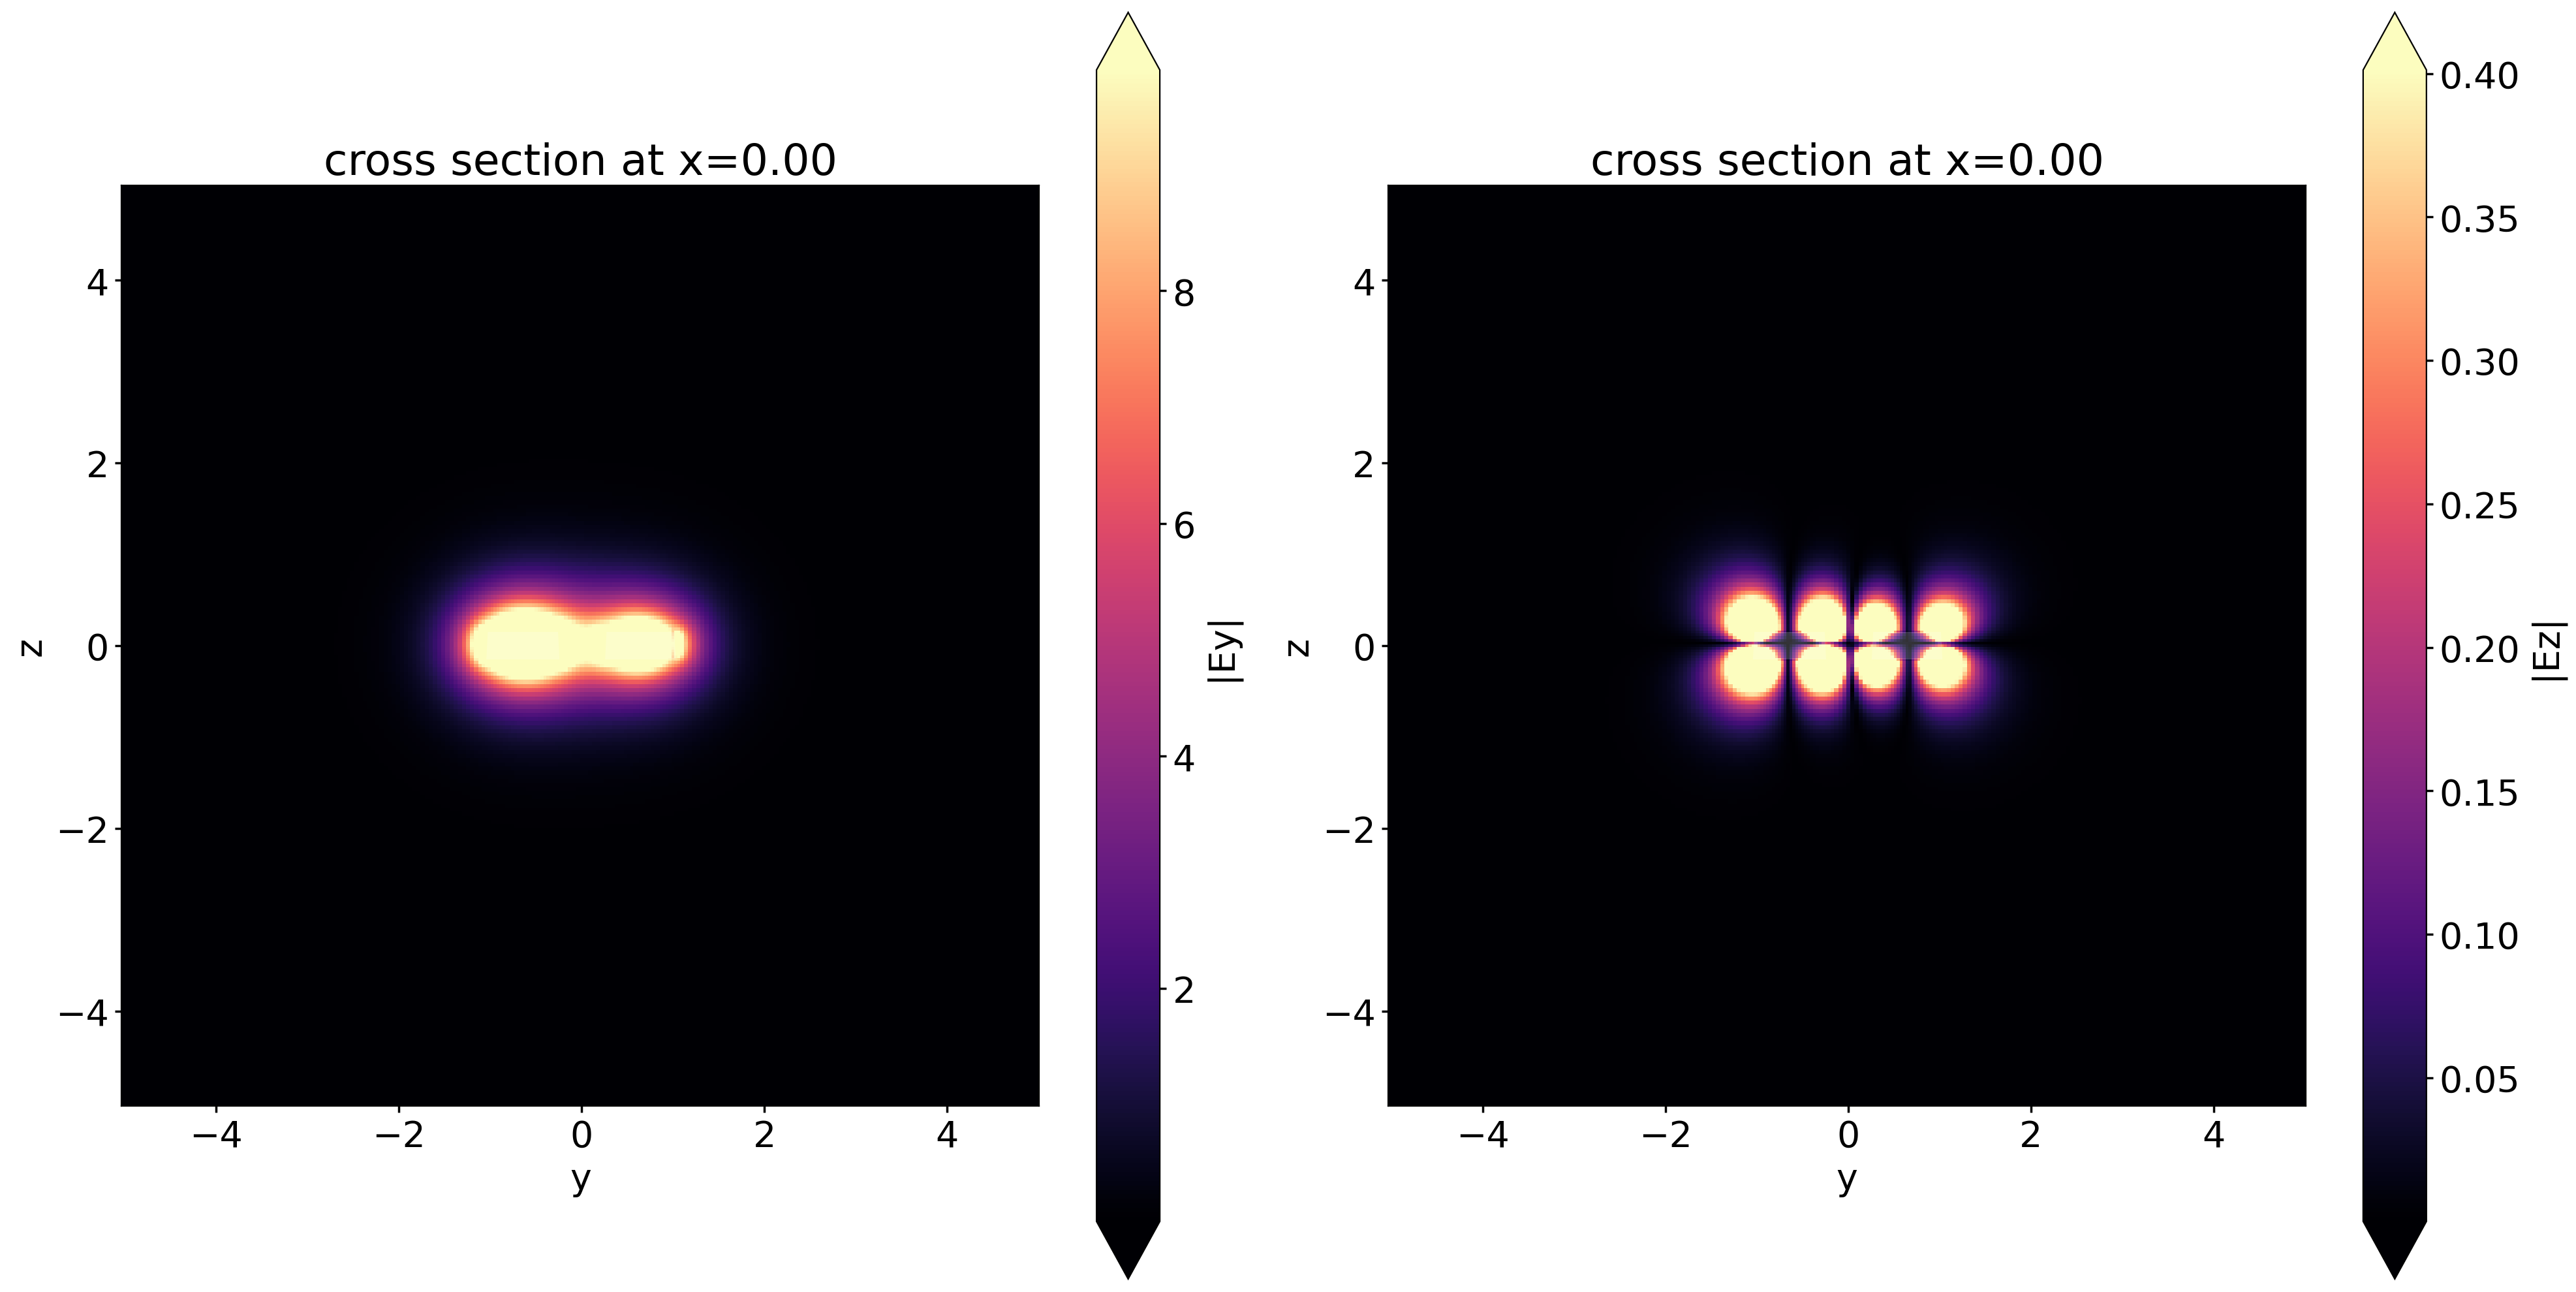

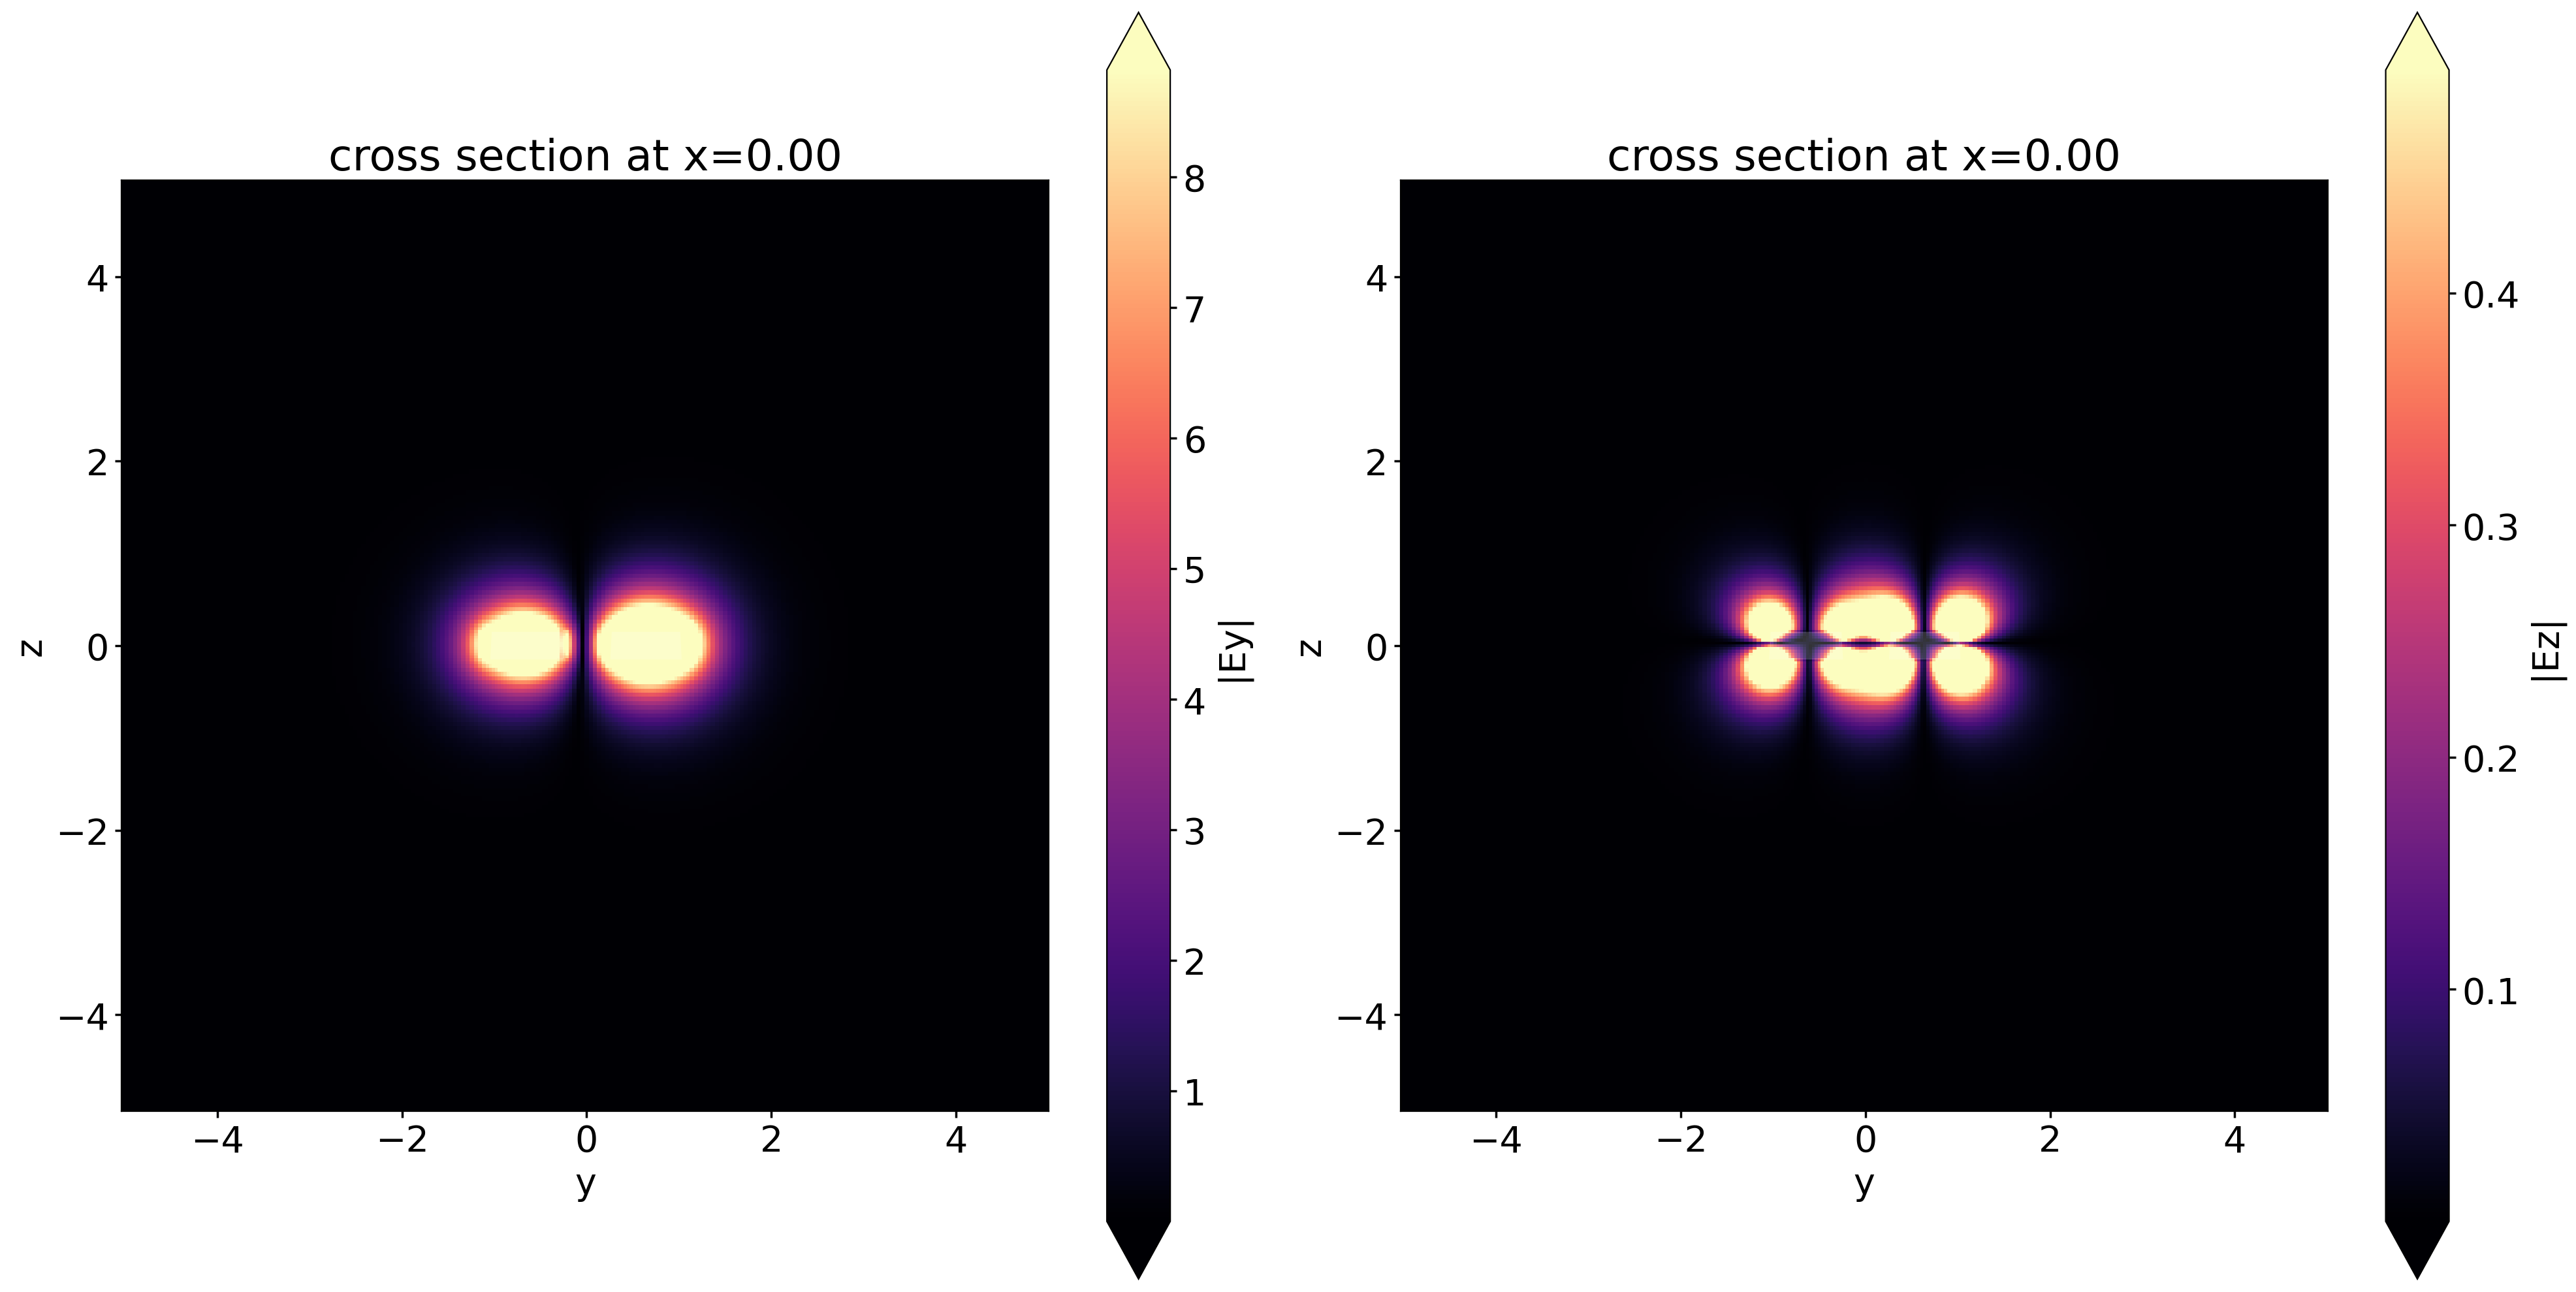

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
asymmetric_wg_1_coupled_mode_solver_120C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
asymmetric_wg_1_coupled_mode_solver_120C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
asymmetric_wg_1_coupled_mode_solver_120C.plot_field("Ey", "abs", mode_index=1, f=freq0, ax=ax1)
asymmetric_wg_1_coupled_mode_solver_120C.plot_field("Ez", "abs", mode_index=1, f=freq0, ax=ax2)
plt.tight_layout()
plt.show()

In [30]:
print("delta_neff_0C = ", asymmetric_wg_1_coupled_delta_neff_0C)
print("delta_neff_120C = ", asymmetric_wg_1_coupled_delta_neff_120C)

delta_neff_0C =  0.01592958
delta_neff_120C =  0.015863061


In [31]:
print((asymmetric_wg_1_coupled_delta_neff_120C-asymmetric_wg_1_coupled_delta_neff_0C)/asymmetric_wg_1_coupled_delta_neff_0C*100)

-0.4175802692770958


# Asymmetric coupled wg mode (wg width 1 = 800 nm, wg width 2 = 761 nm, gap = 451 nm) at 0C and 120C

In [32]:
Lx, Ly, Lz = 10, 10, 10
dl = 0.01

min_steps_per_wvl = 30

wg_width_1 = 0.8
wg_height_1 = 0.3
wg_sidewall_angle_1 = np.pi/2.0 - 87.0/180.0*np.pi

wg_width_2 = 0.761
wg_height_2 = 0.3
wg_sidewall_angle_2 = np.pi/2.0 - 87.0/180.0*np.pi

wg_gap = 0.451

gap = wg_gap + wg_width_1/2.0 + wg_width_2/2.0

target_neff = 1.587703

wg_n = 1.968
wg_k = 0

wvl_um = 1.31
freq0 = C_0/wvl_um

wg_medium = td.Medium.from_nk(n=1.968, k=0, freq=freq0)

wg_sidewall_angle_2 = np.pi/2.0 - 87.0/180.0*np.pi

num_freqs = 3

fwidth = 3200e9  # 3200 Ghz
freqs = np.linspace(freq0-fwidth/2.0, freq0+fwidth/2.0, num_freqs)

thickness_3sigma = 0.03
width_3sigma = 0.02
sidewall_angle_3sigma = 2/90*np.pi/2

num_samples = 1500

n_medium_0C = 1.968
n_background_0C = 1.45
n_medium_120C = 1.968 + 2.5e-5*120
n_background_120C = 1.45 + 1e-5*120

target_neff_0C = 1.587703
target_neff_120C = 1.5901577


In [33]:
asymmetric_wg_2_coupled_mode_solver_0C, asymmetric_wg_2_coupled_mode_data_0C, asymmetric_wg_2_coupled_n_eff_0C, asymmetric_wg_2_coupled_delta_neff_0C = coupled_wg_mode_data_calculator(
    wg_width_1, wg_height_1, wg_sidewall_angle_1, wg_width_2, wg_height_2, wg_sidewall_angle_2, gap, n_medium_0C, n_background_0C, target_neff_0C,  freqs, freq0, Lx = 20, Ly=20, Lz=20, num_modes = 2, dl=0.05, min_steps_per_wvl = 20
    )
asymmetric_wg_2_coupled_mode_solver_120C, asymmetric_wg_2_coupled_mode_data_120C, asymmetric_wg_2_coupled_n_eff_120C, asymmetric_wg_2_coupled_delta_neff_120C = coupled_wg_mode_data_calculator(
    wg_width_1, wg_height_1, wg_sidewall_angle_1, wg_width_2, wg_height_2, wg_sidewall_angle_2, gap, n_medium_120C, n_background_120C, target_neff_120C, freqs, freq0, Lx = 20, Ly=20, Lz=20, num_modes = 2, dl=0.05, min_steps_per_wvl = 20
    )

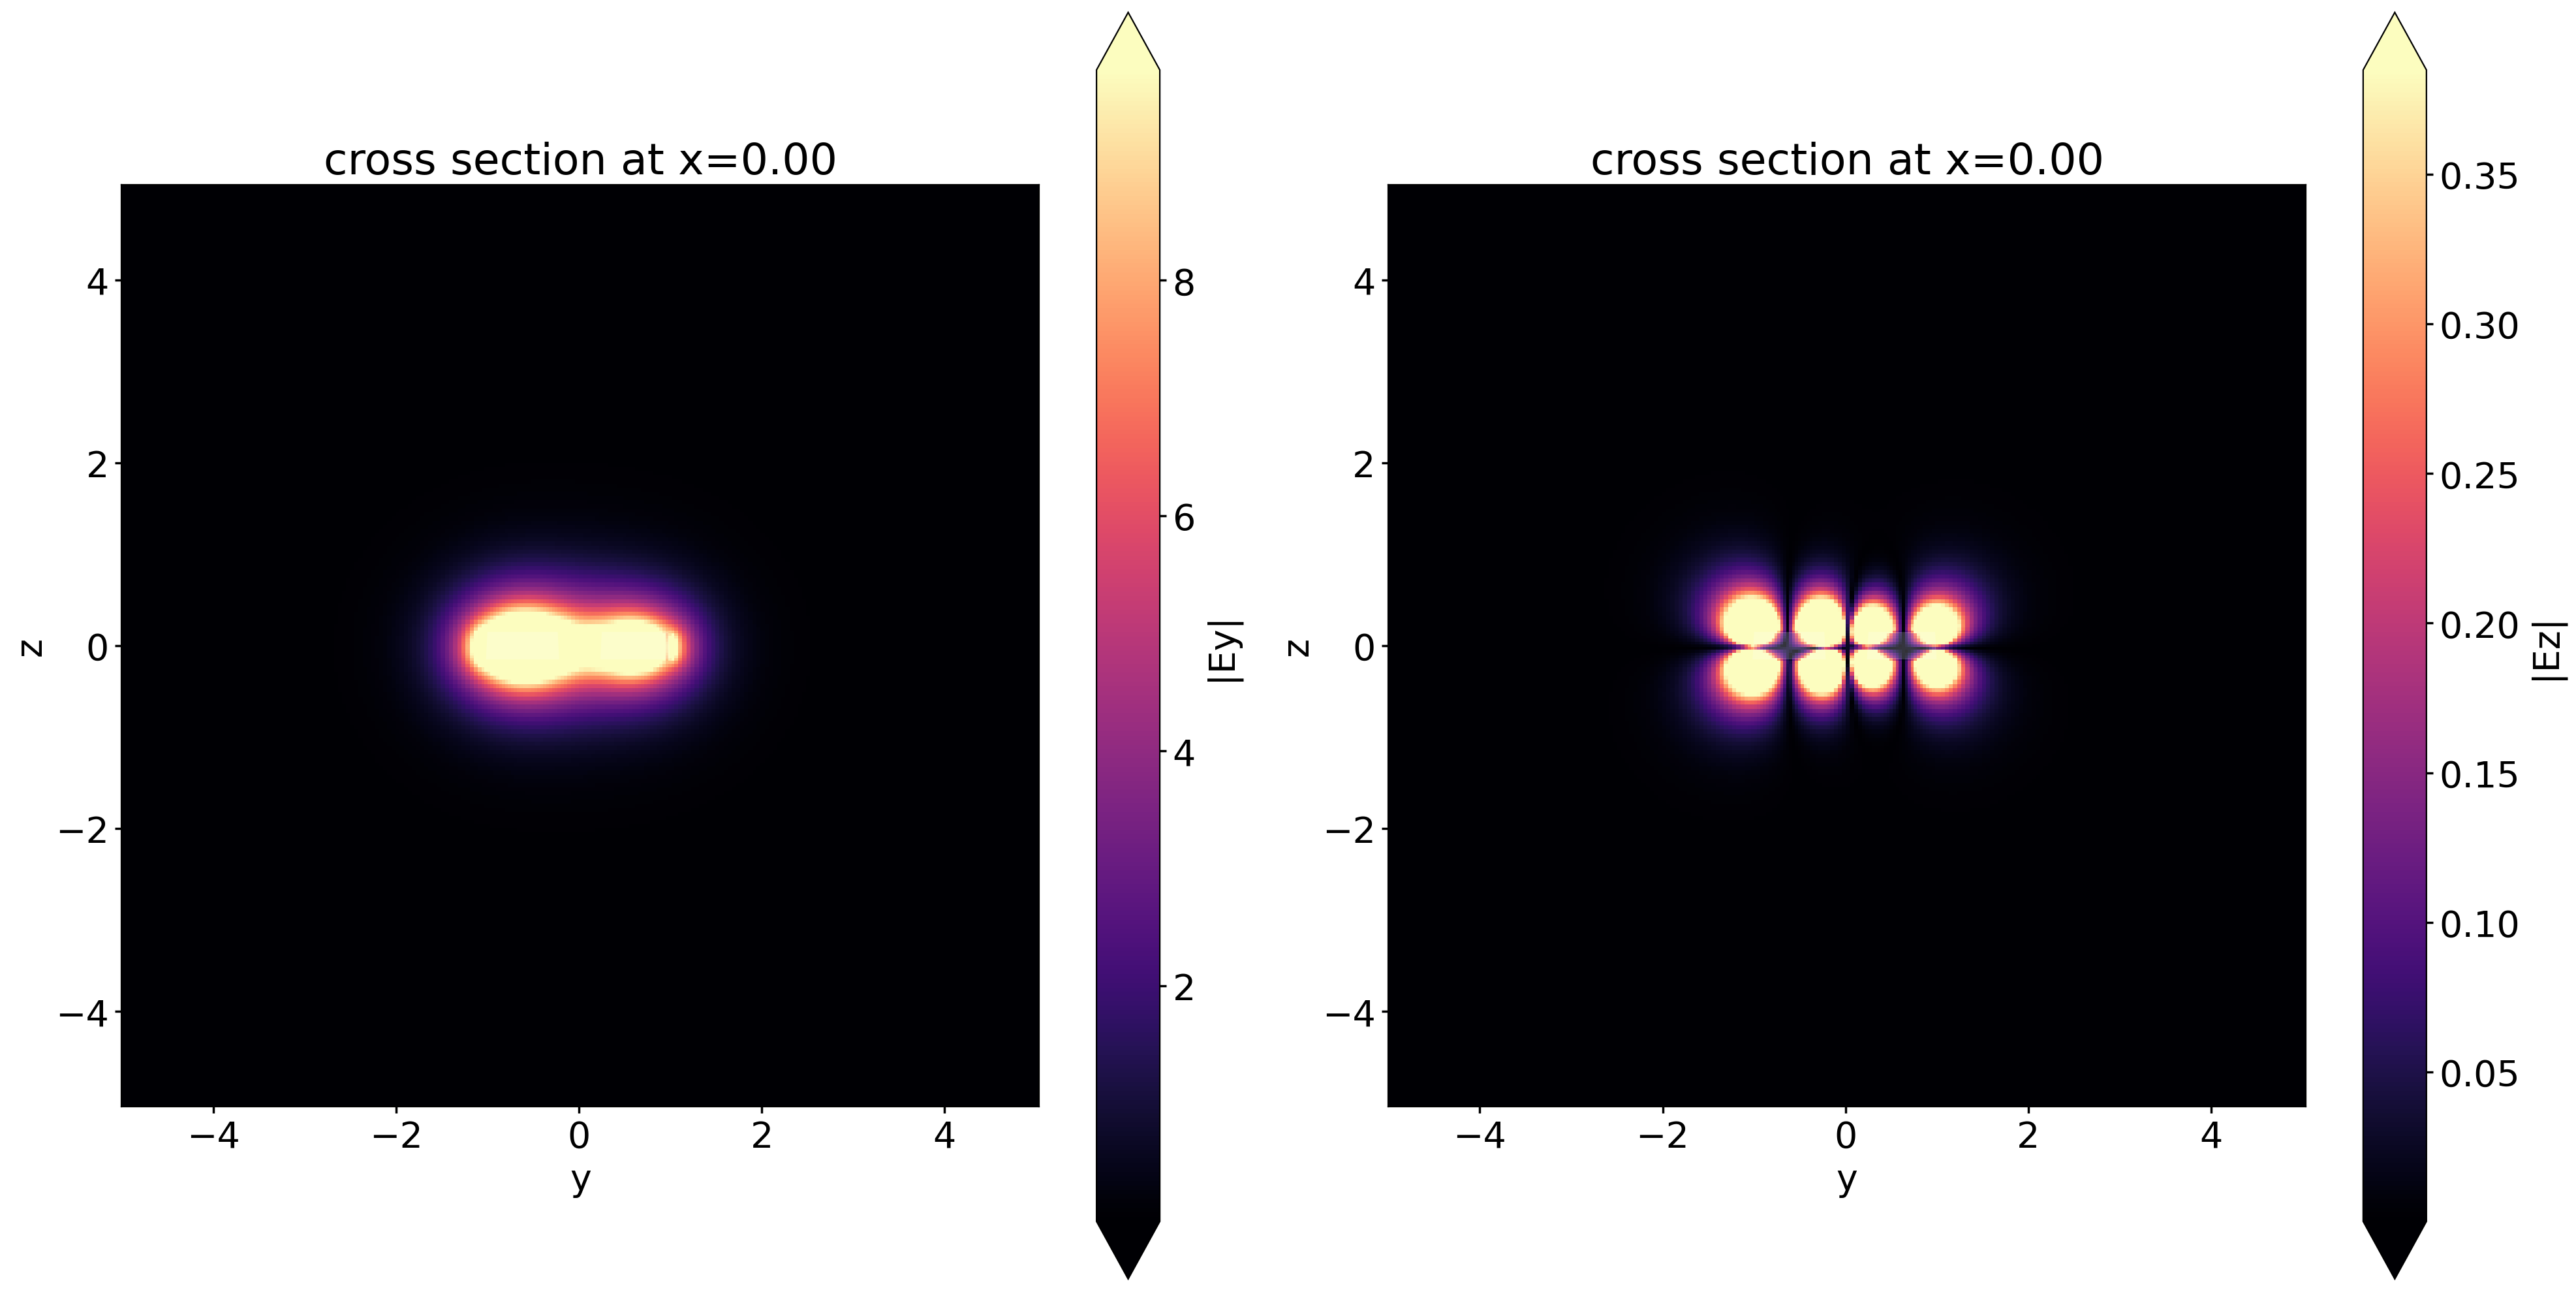

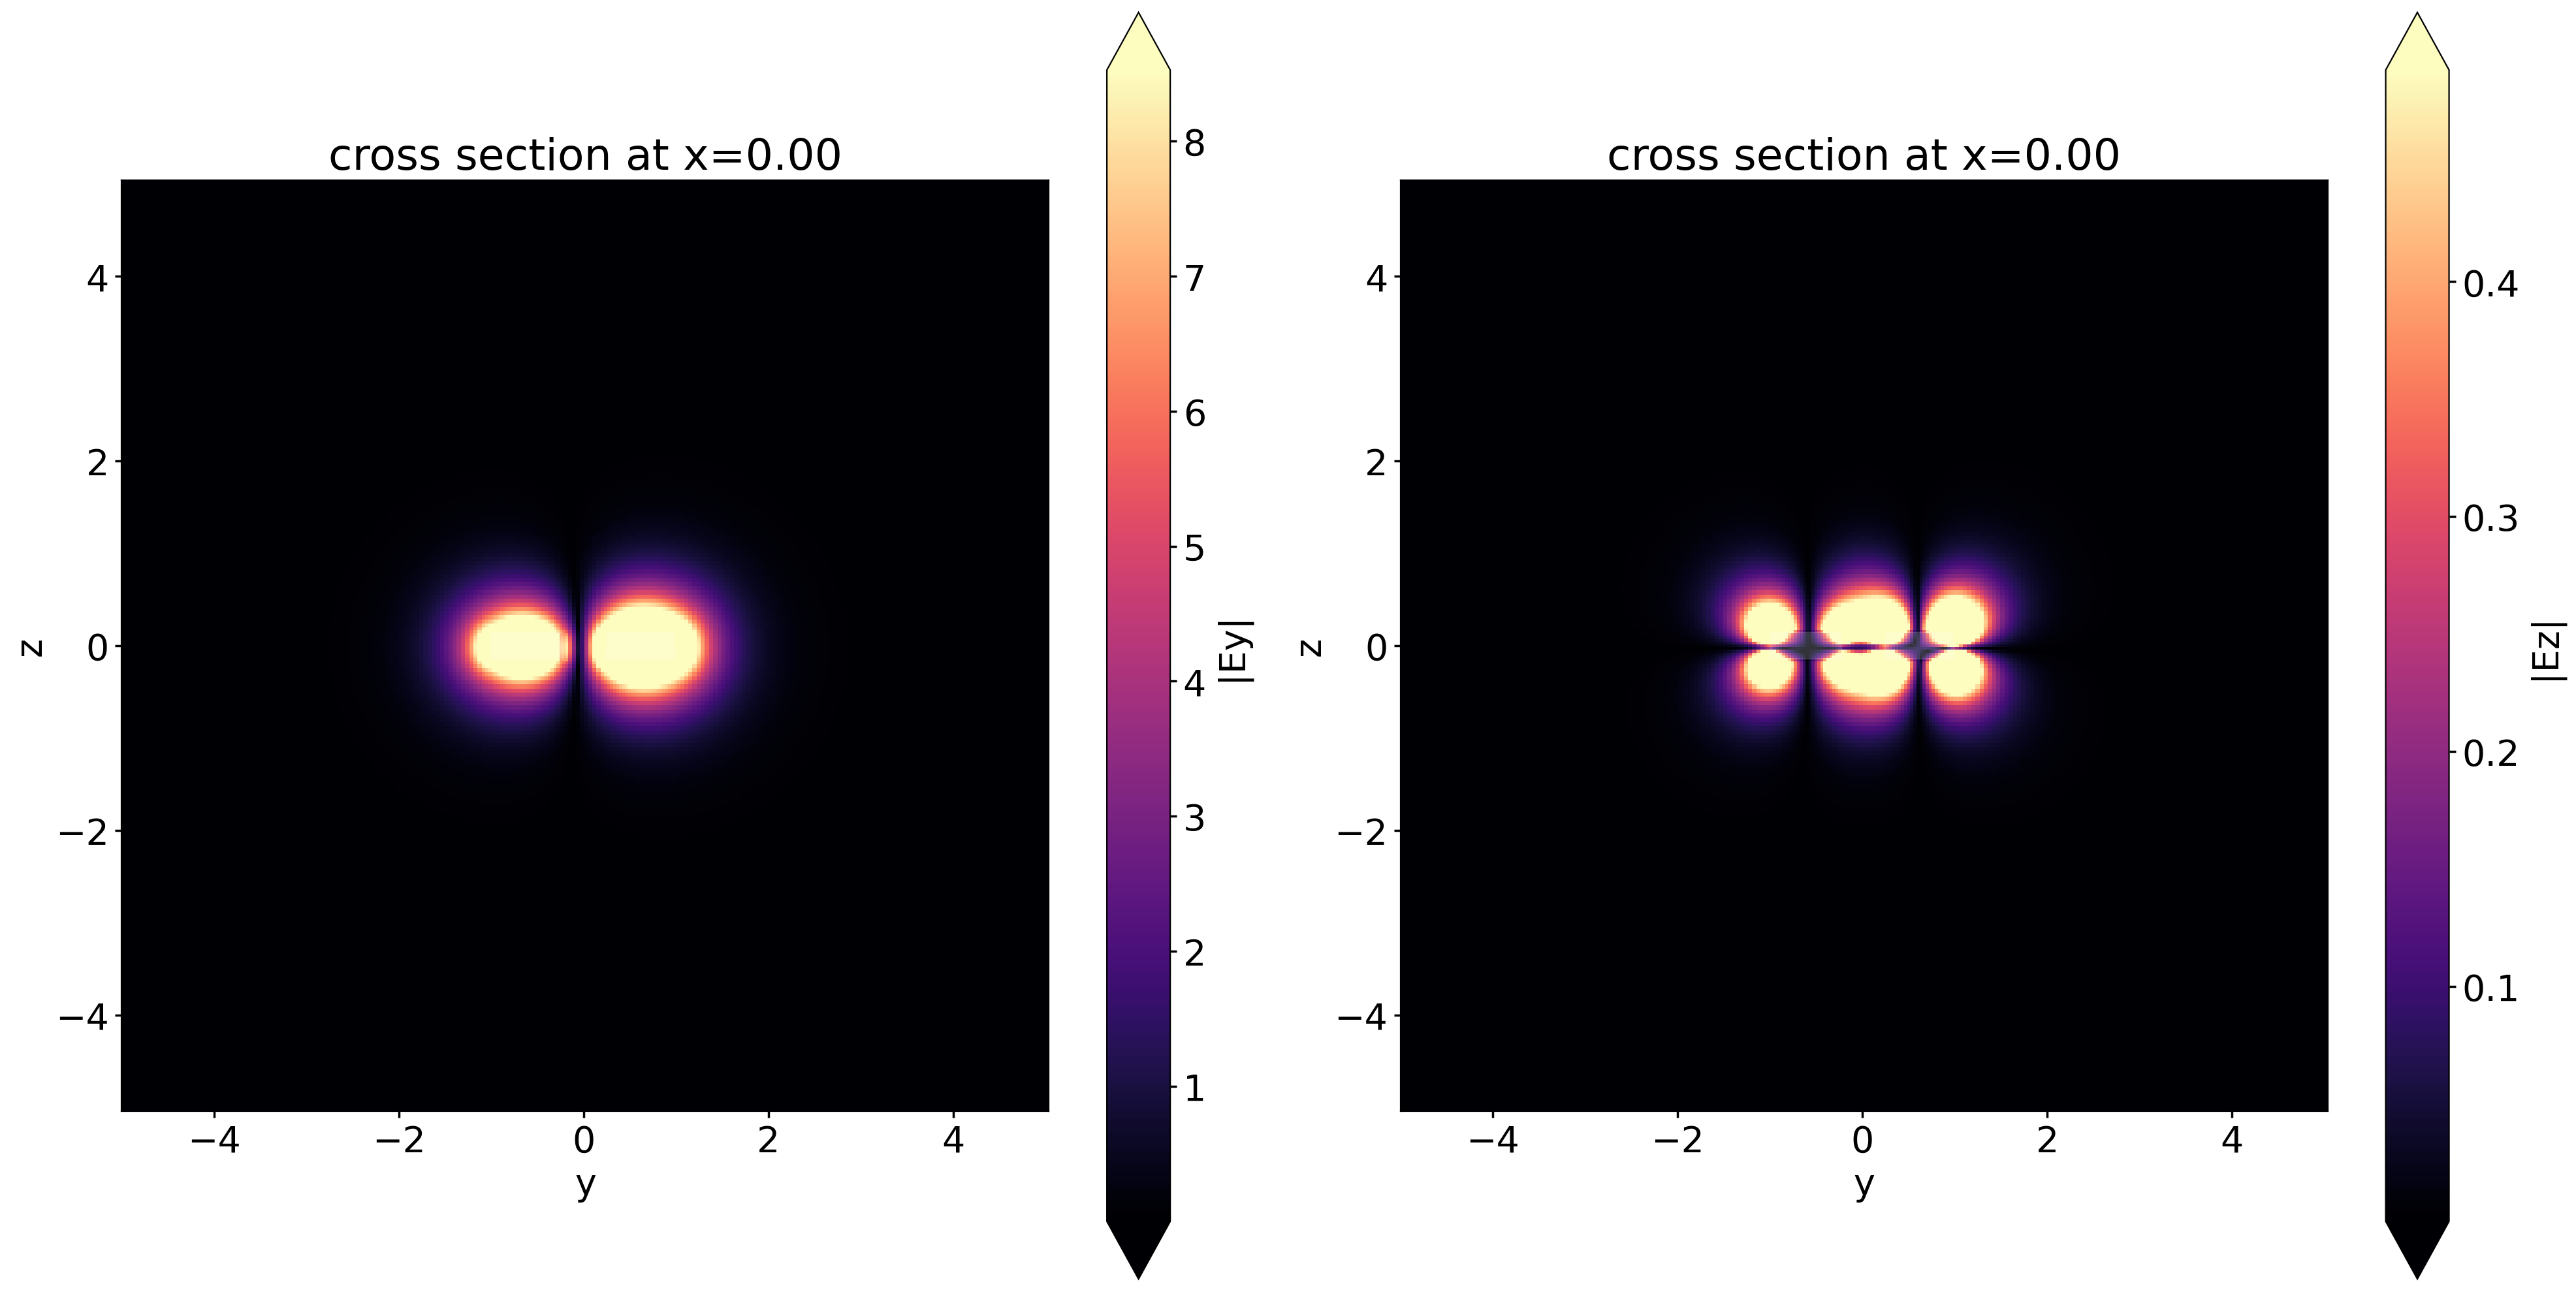

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
asymmetric_wg_2_coupled_mode_solver_0C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
asymmetric_wg_2_coupled_mode_solver_0C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
asymmetric_wg_2_coupled_mode_solver_0C.plot_field("Ey", "abs", mode_index=1, f=freq0, ax=ax1)
asymmetric_wg_2_coupled_mode_solver_0C.plot_field("Ez", "abs", mode_index=1, f=freq0, ax=ax2)
plt.tight_layout()
plt.show()

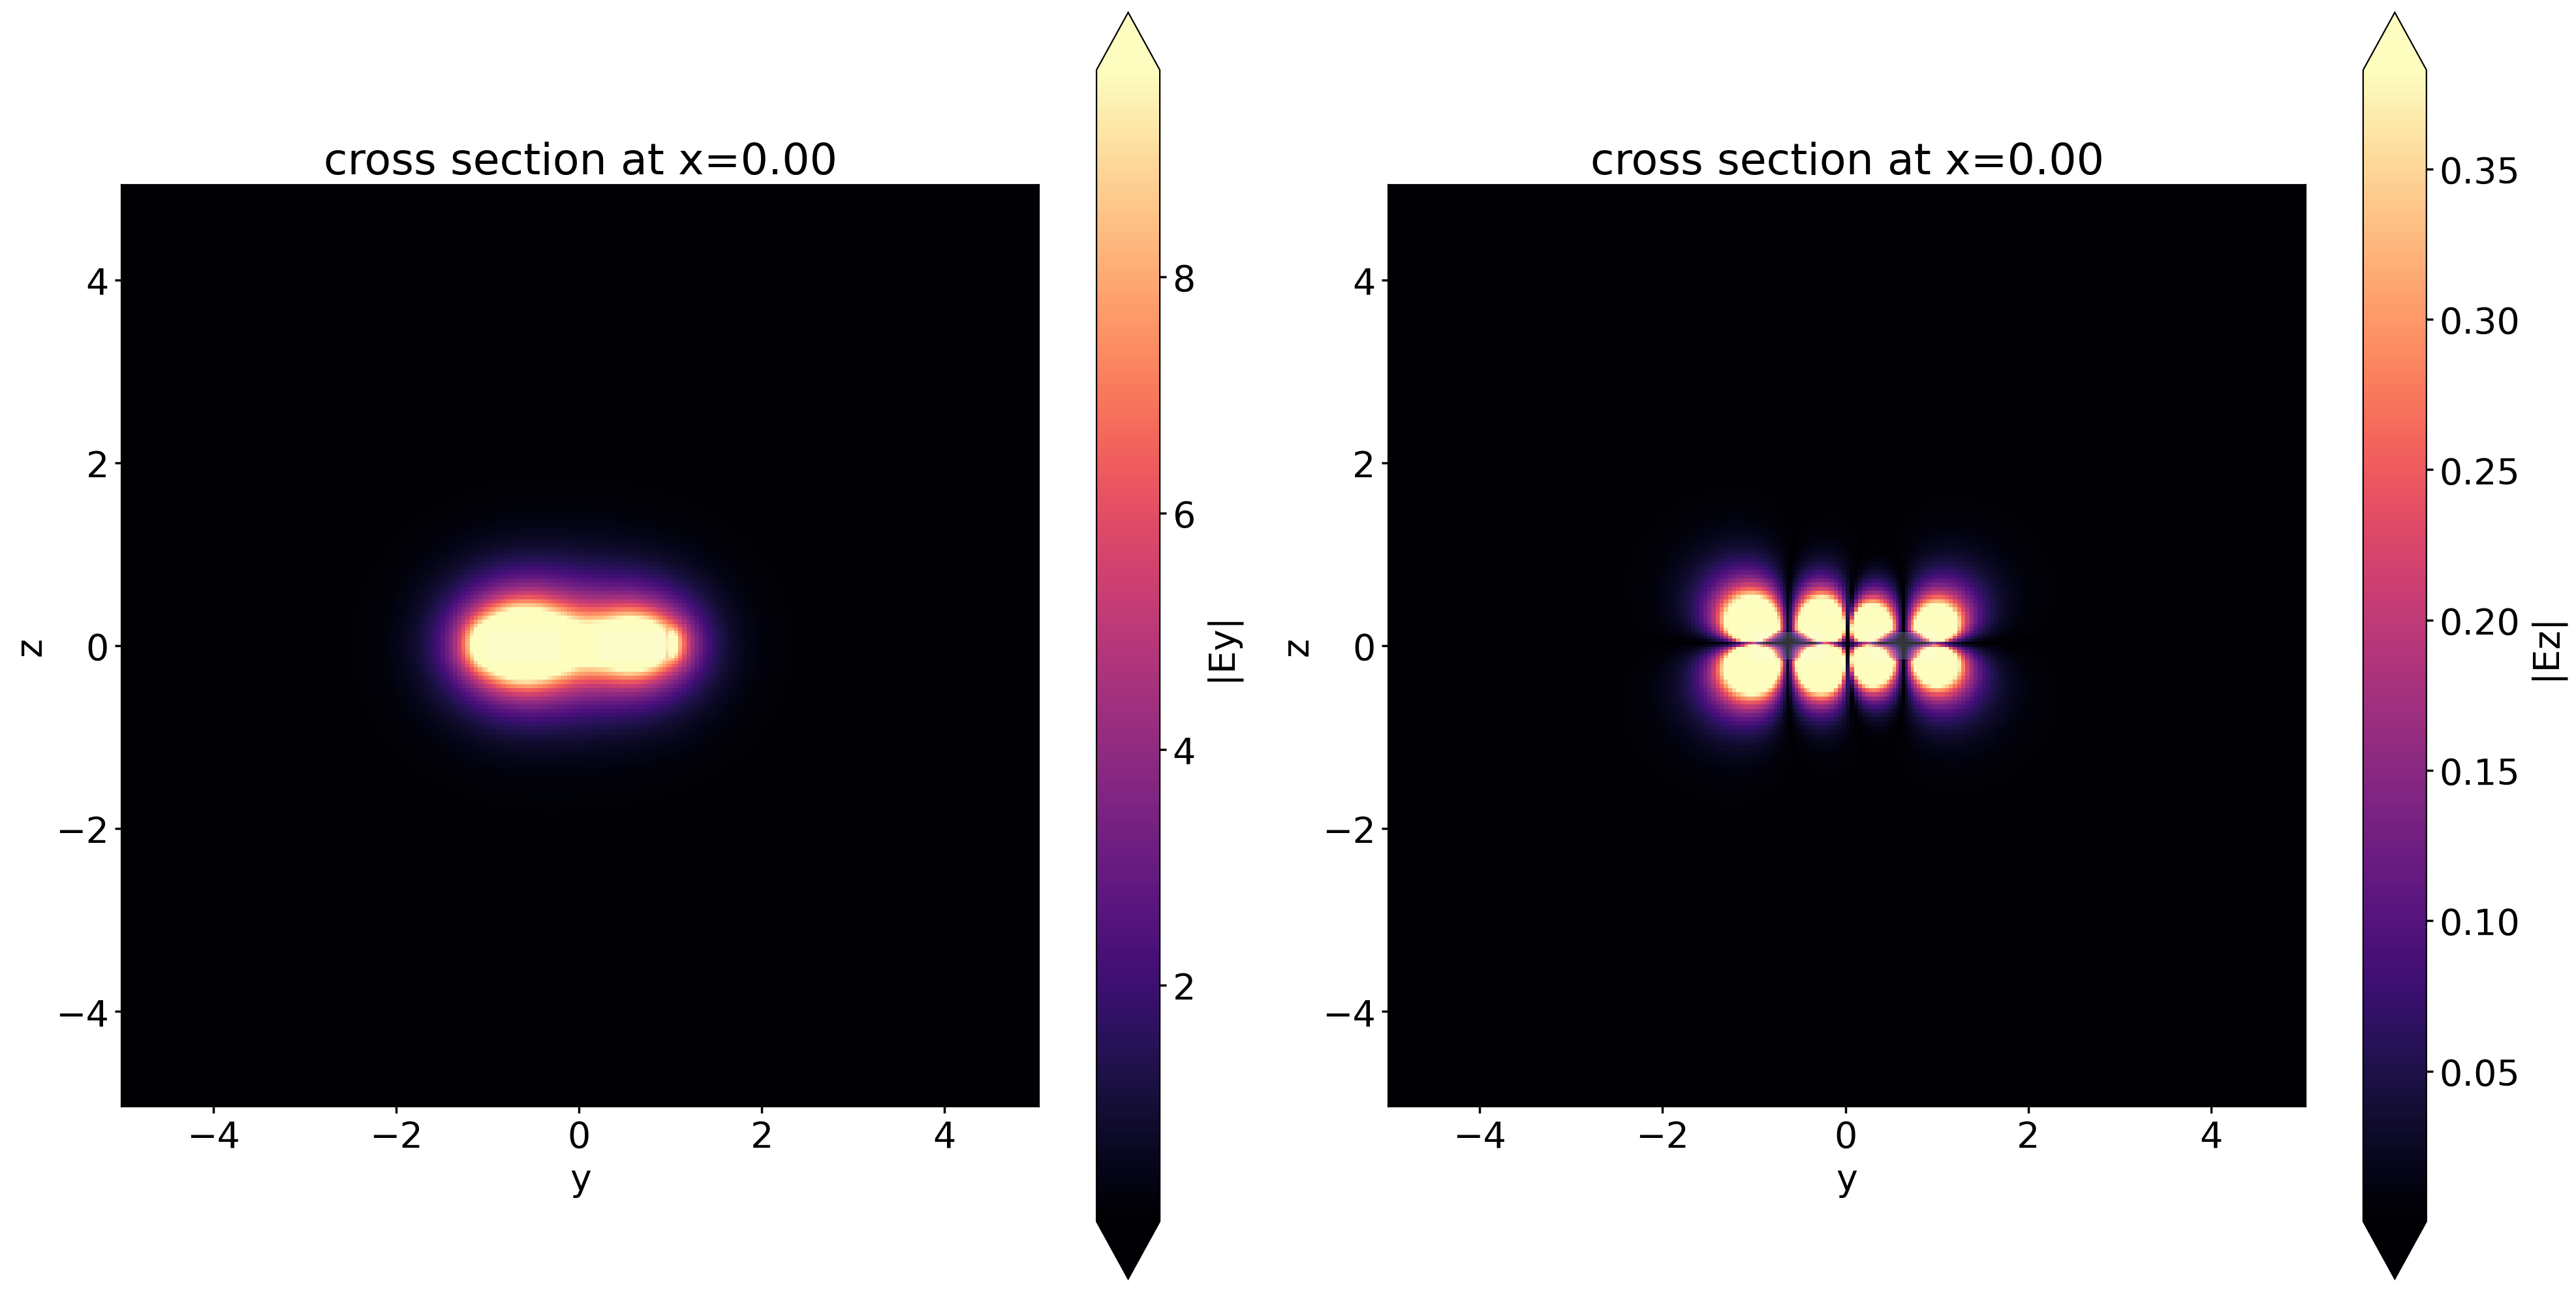

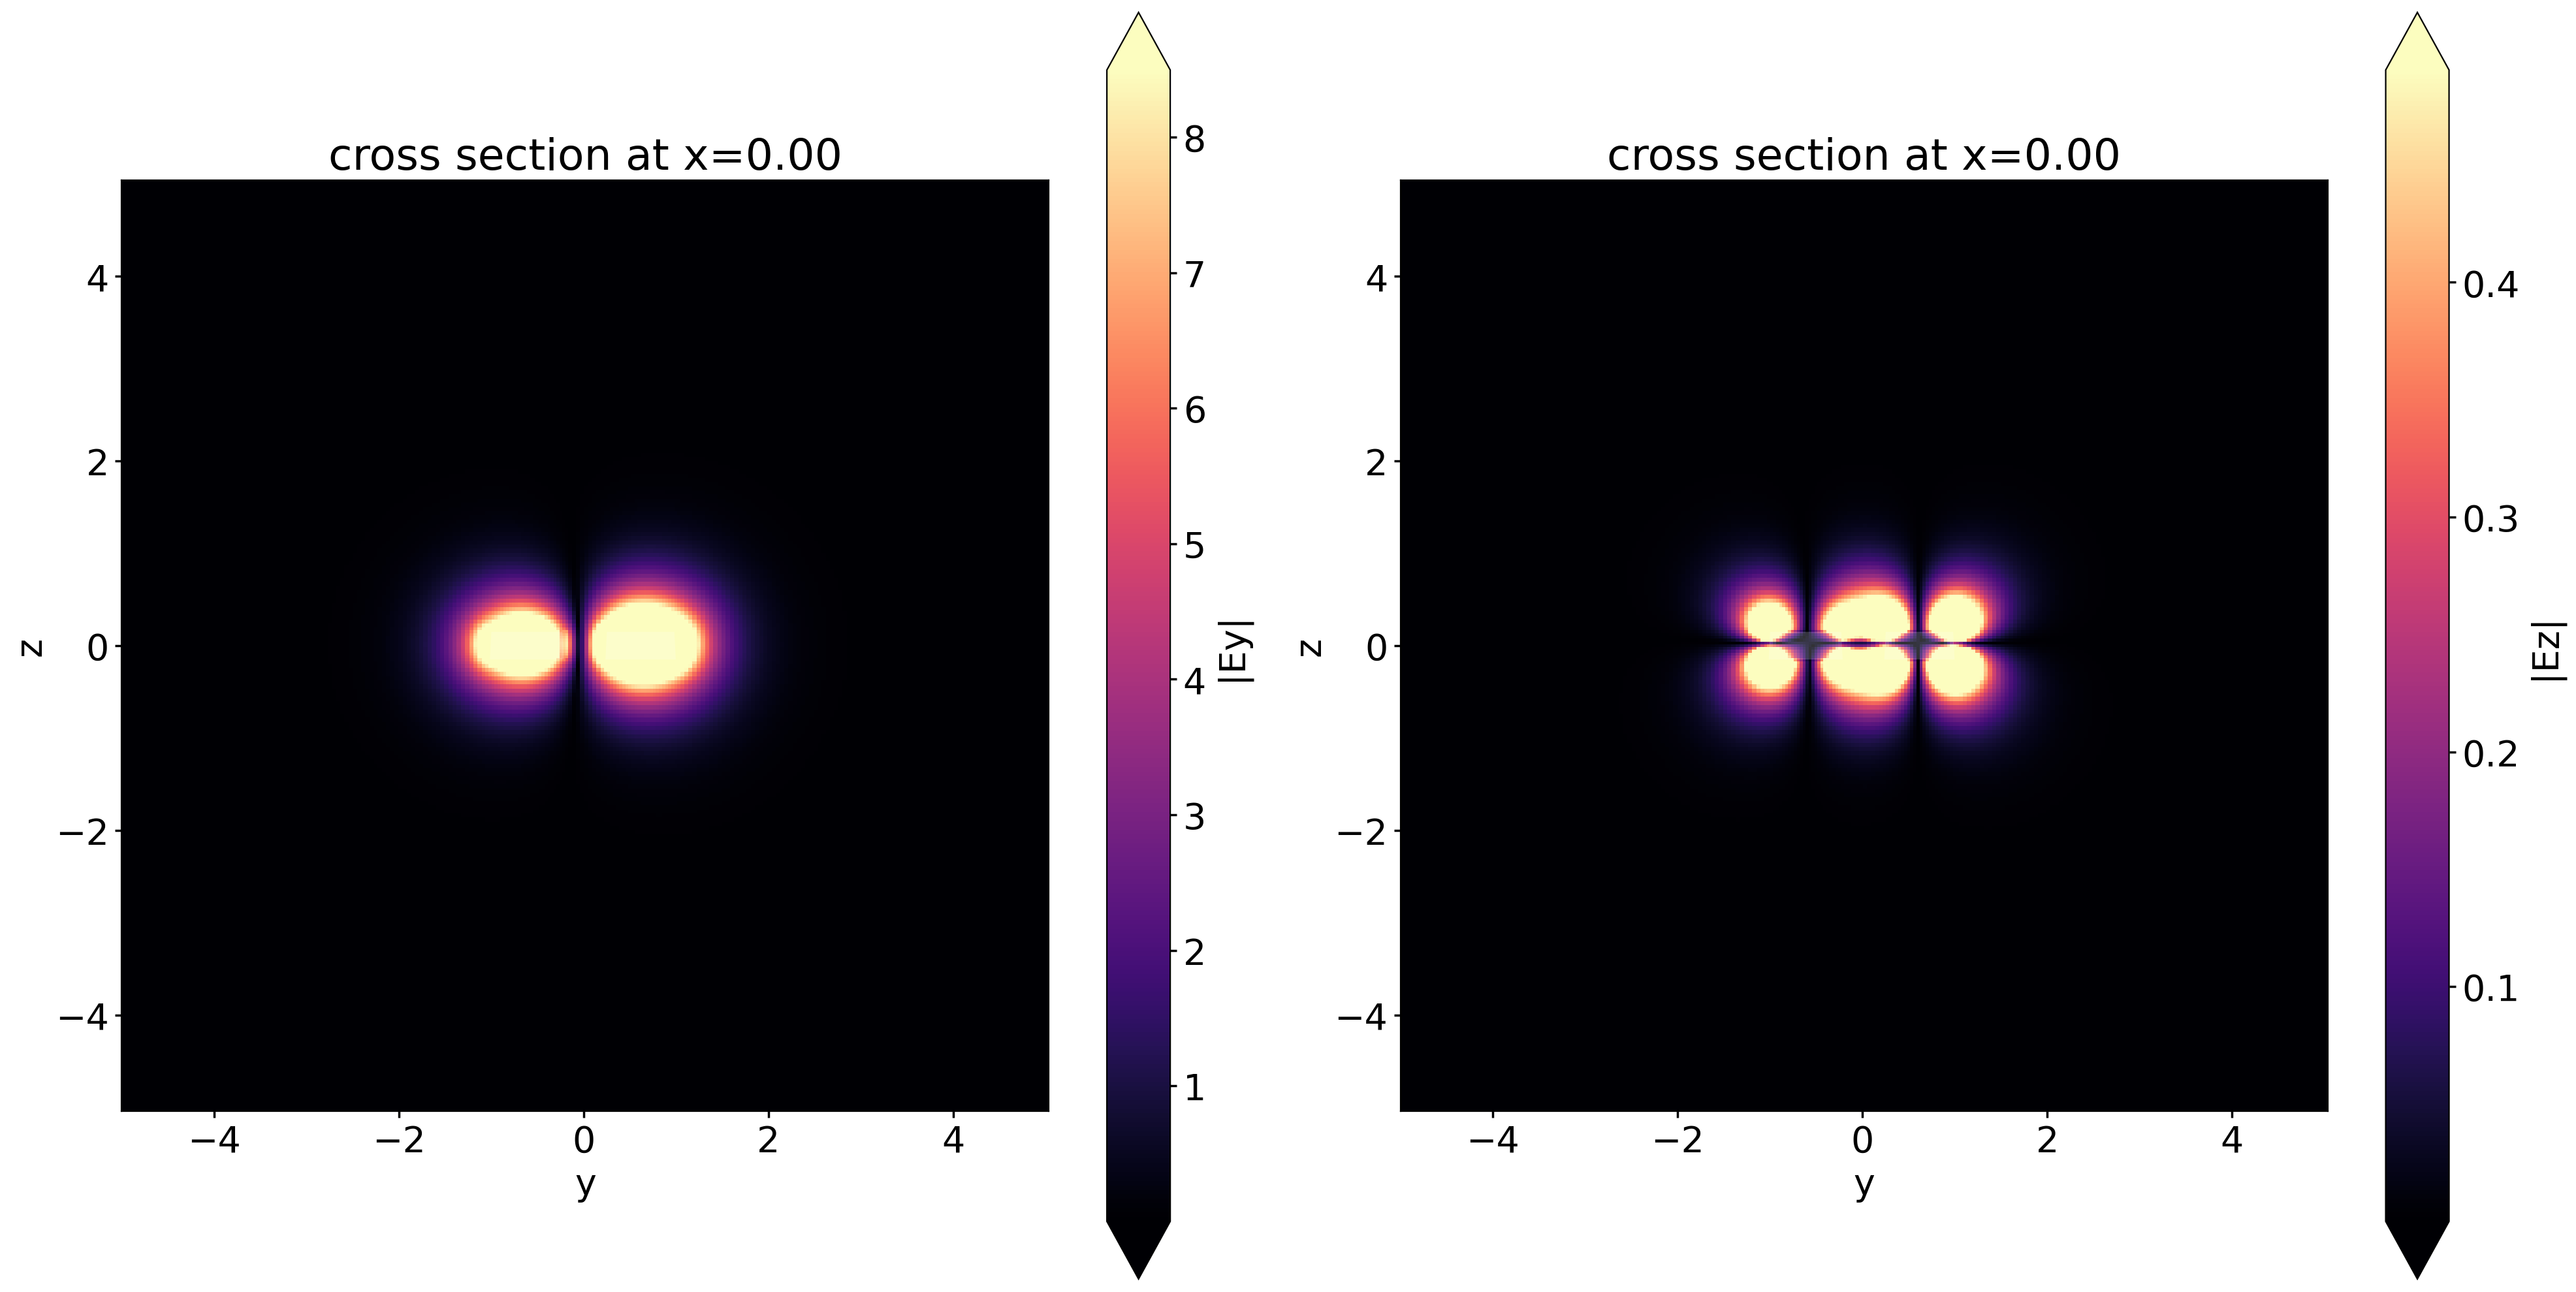

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
asymmetric_wg_2_coupled_mode_solver_120C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
asymmetric_wg_2_coupled_mode_solver_120C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
asymmetric_wg_2_coupled_mode_solver_120C.plot_field("Ey", "abs", mode_index=1, f=freq0, ax=ax1)
asymmetric_wg_2_coupled_mode_solver_120C.plot_field("Ez", "abs", mode_index=1, f=freq0, ax=ax2)
plt.tight_layout()
plt.show()

In [36]:
print("delta_neff_0C = ", asymmetric_wg_2_coupled_delta_neff_0C)
print("delta_neff_120C = ", asymmetric_wg_2_coupled_delta_neff_120C)

delta_neff_0C =  0.019774318
delta_neff_120C =  0.019712925


In [37]:
print((asymmetric_wg_2_coupled_delta_neff_120C-asymmetric_wg_2_coupled_delta_neff_0C)/asymmetric_wg_2_coupled_delta_neff_0C*100)

-0.31046727672219276


# Asymmetric coupled wg mode (wg width 1 = 800 nm, wg width 2 = 747 nm, gap = 405 nm) at 0C and 120C

In [38]:
Lx, Ly, Lz = 10, 10, 10
dl = 0.01

min_steps_per_wvl = 30

wg_width_1 = 0.8
wg_height_1 = 0.3
wg_sidewall_angle_1 = np.pi/2.0 - 87.0/180.0*np.pi

wg_width_2 = 0.747
wg_height_2 = 0.3
wg_sidewall_angle_2 = np.pi/2.0 - 87.0/180.0*np.pi

wg_gap = 0.405

gap = wg_gap + wg_width_1/2.0 + wg_width_2/2.0

target_neff = 1.587703

wg_n = 1.968
wg_k = 0

wvl_um = 1.31
freq0 = C_0/wvl_um

wg_medium = td.Medium.from_nk(n=1.968, k=0, freq=freq0)

wg_sidewall_angle_2 = np.pi/2.0 - 87.0/180.0*np.pi

num_freqs = 3

fwidth = 3200e9  # 3200 Ghz
freqs = np.linspace(freq0-fwidth/2.0, freq0+fwidth/2.0, num_freqs)

thickness_3sigma = 0.03
width_3sigma = 0.02
sidewall_angle_3sigma = 2/90*np.pi/2

num_samples = 1500

n_medium_0C = 1.968
n_background_0C = 1.45
n_medium_120C = 1.968 + 2.5e-5*120
n_background_120C = 1.45 + 1e-5*120

target_neff_0C = 1.587703
target_neff_120C = 1.5901577


In [39]:
asymmetric_wg_3_coupled_mode_solver_0C, asymmetric_wg_3_coupled_mode_data_0C, asymmetric_wg_3_coupled_n_eff_0C, asymmetric_wg_3_coupled_delta_neff_0C = coupled_wg_mode_data_calculator(
    wg_width_1, wg_height_1, wg_sidewall_angle_1, wg_width_2, wg_height_2, wg_sidewall_angle_2, gap, n_medium_0C, n_background_0C,target_neff_0C,  freqs, freq0, Lx = 20, Ly=20, Lz=20, num_modes = 2, dl=0.05, min_steps_per_wvl = 20
    )
asymmetric_wg_3_coupled_mode_solver_120C, asymmetric_wg_3_coupled_mode_data_120C, asymmetric_wg_3_coupled_n_eff_120C, asymmetric_wg_3_coupled_delta_neff_120C = coupled_wg_mode_data_calculator(
    wg_width_1, wg_height_1, wg_sidewall_angle_1, wg_width_2, wg_height_2, wg_sidewall_angle_2, gap, n_medium_120C, n_background_120C,target_neff_120C, freqs, freq0, Lx = 20, Ly=20, Lz=20, num_modes = 2, dl=0.05, min_steps_per_wvl = 20
    )

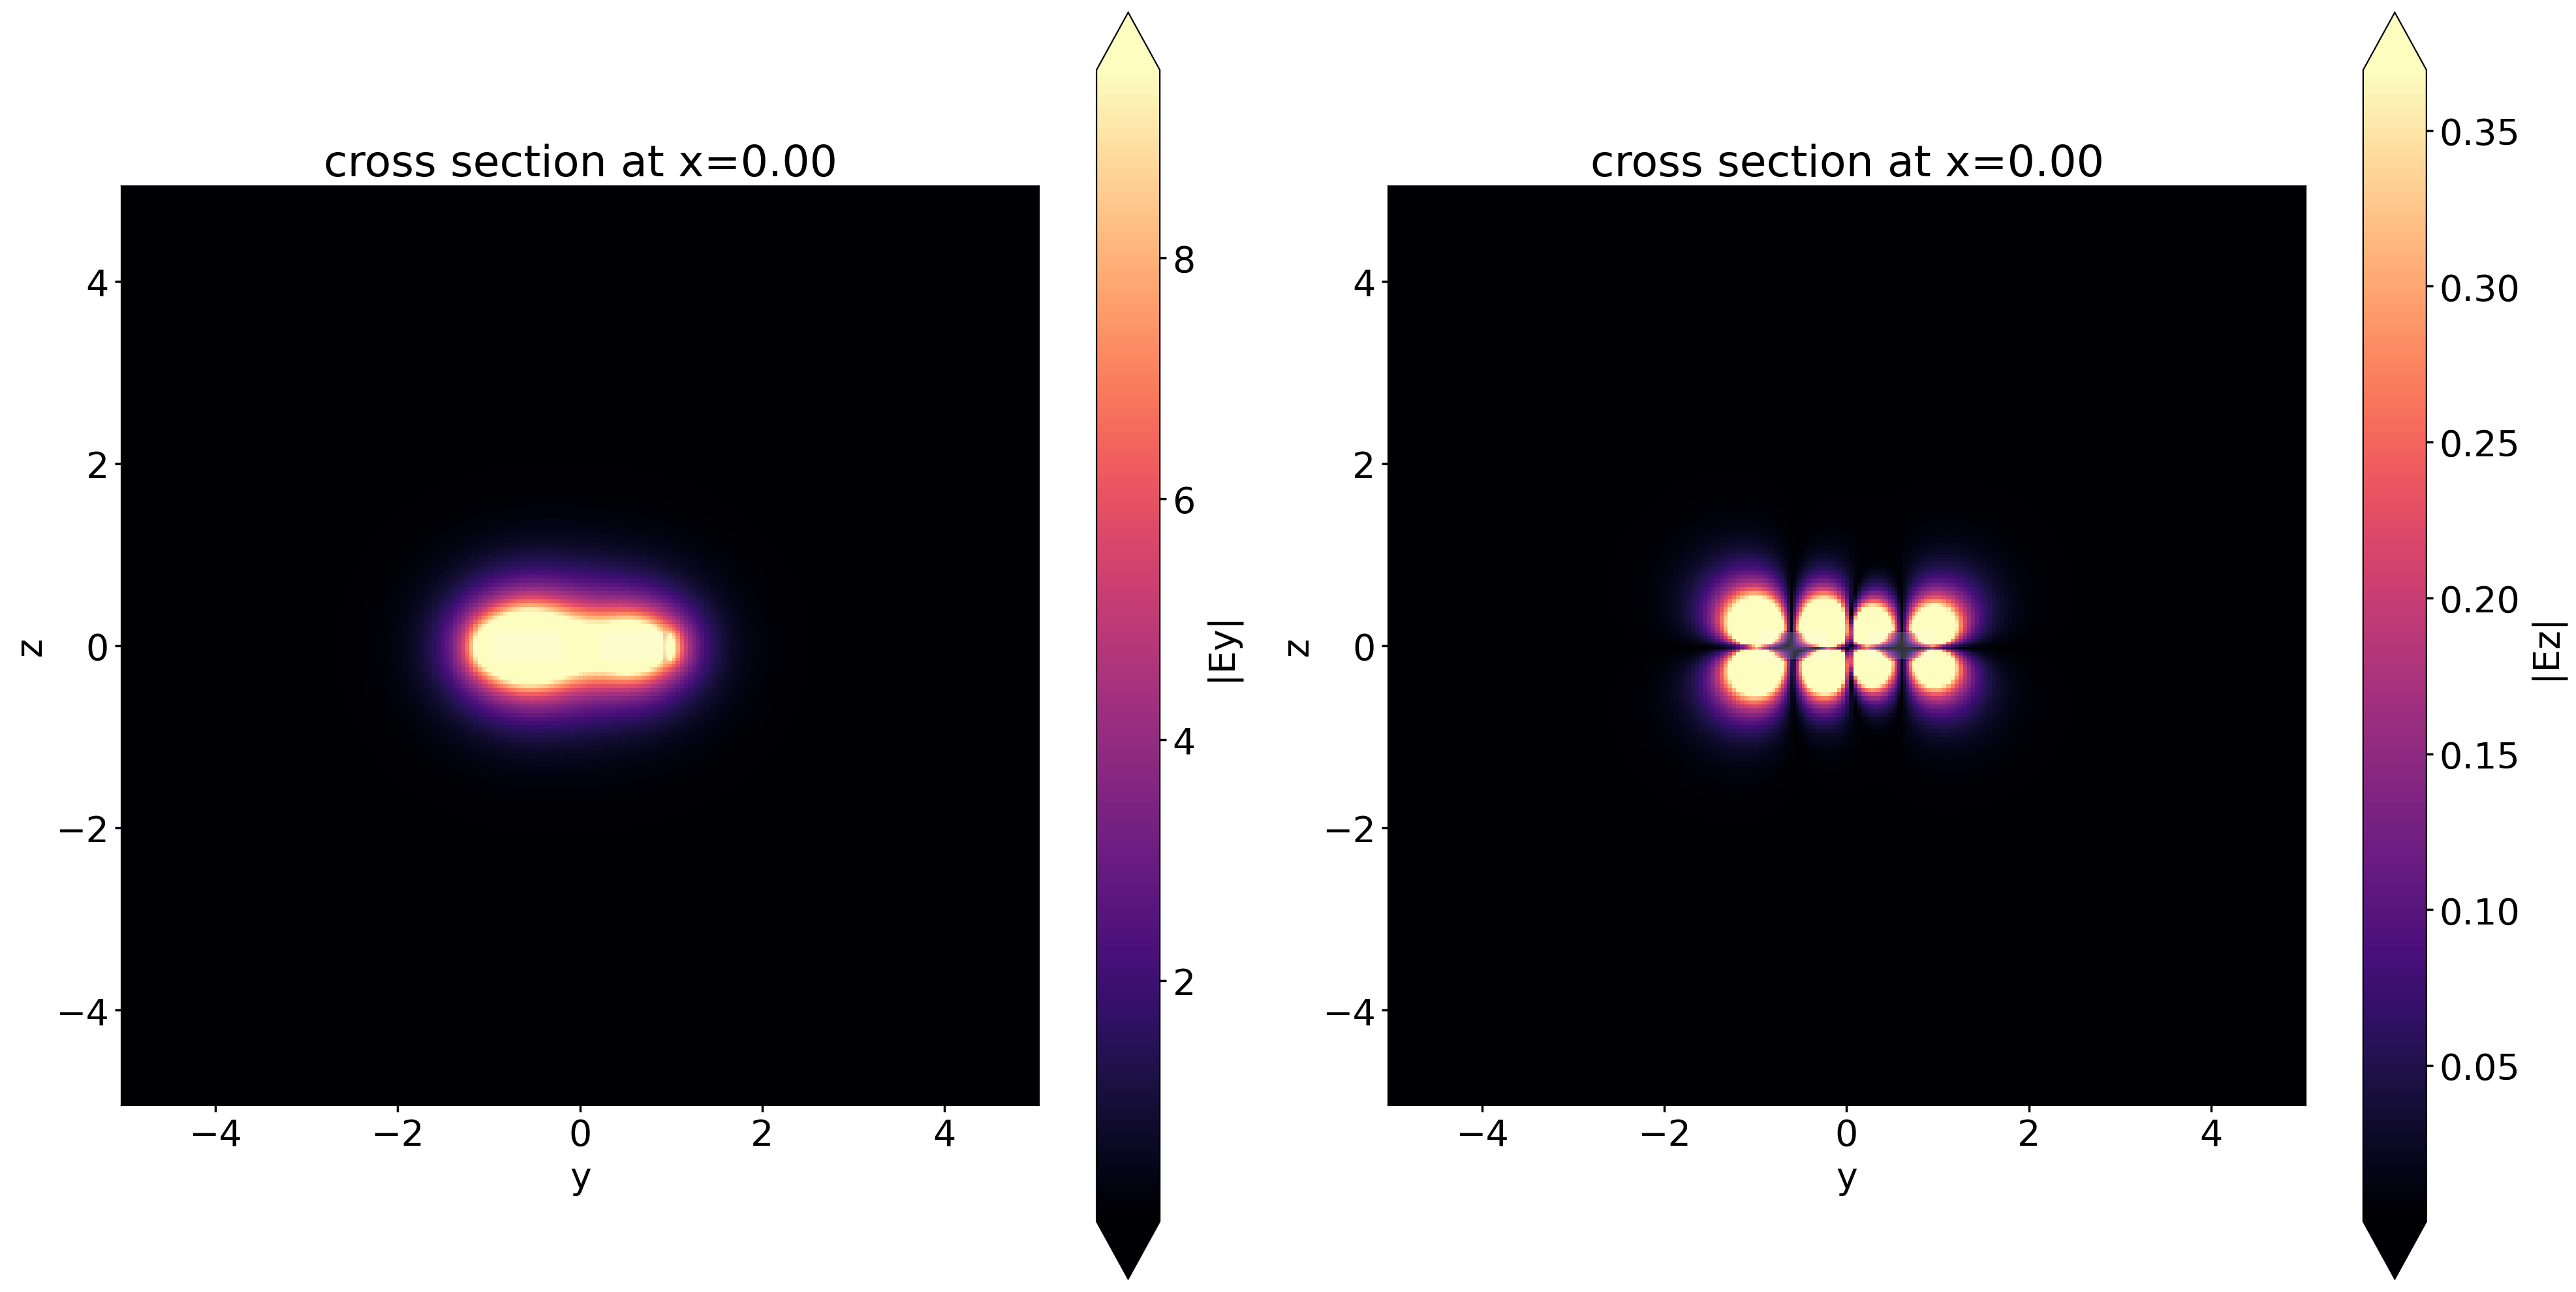

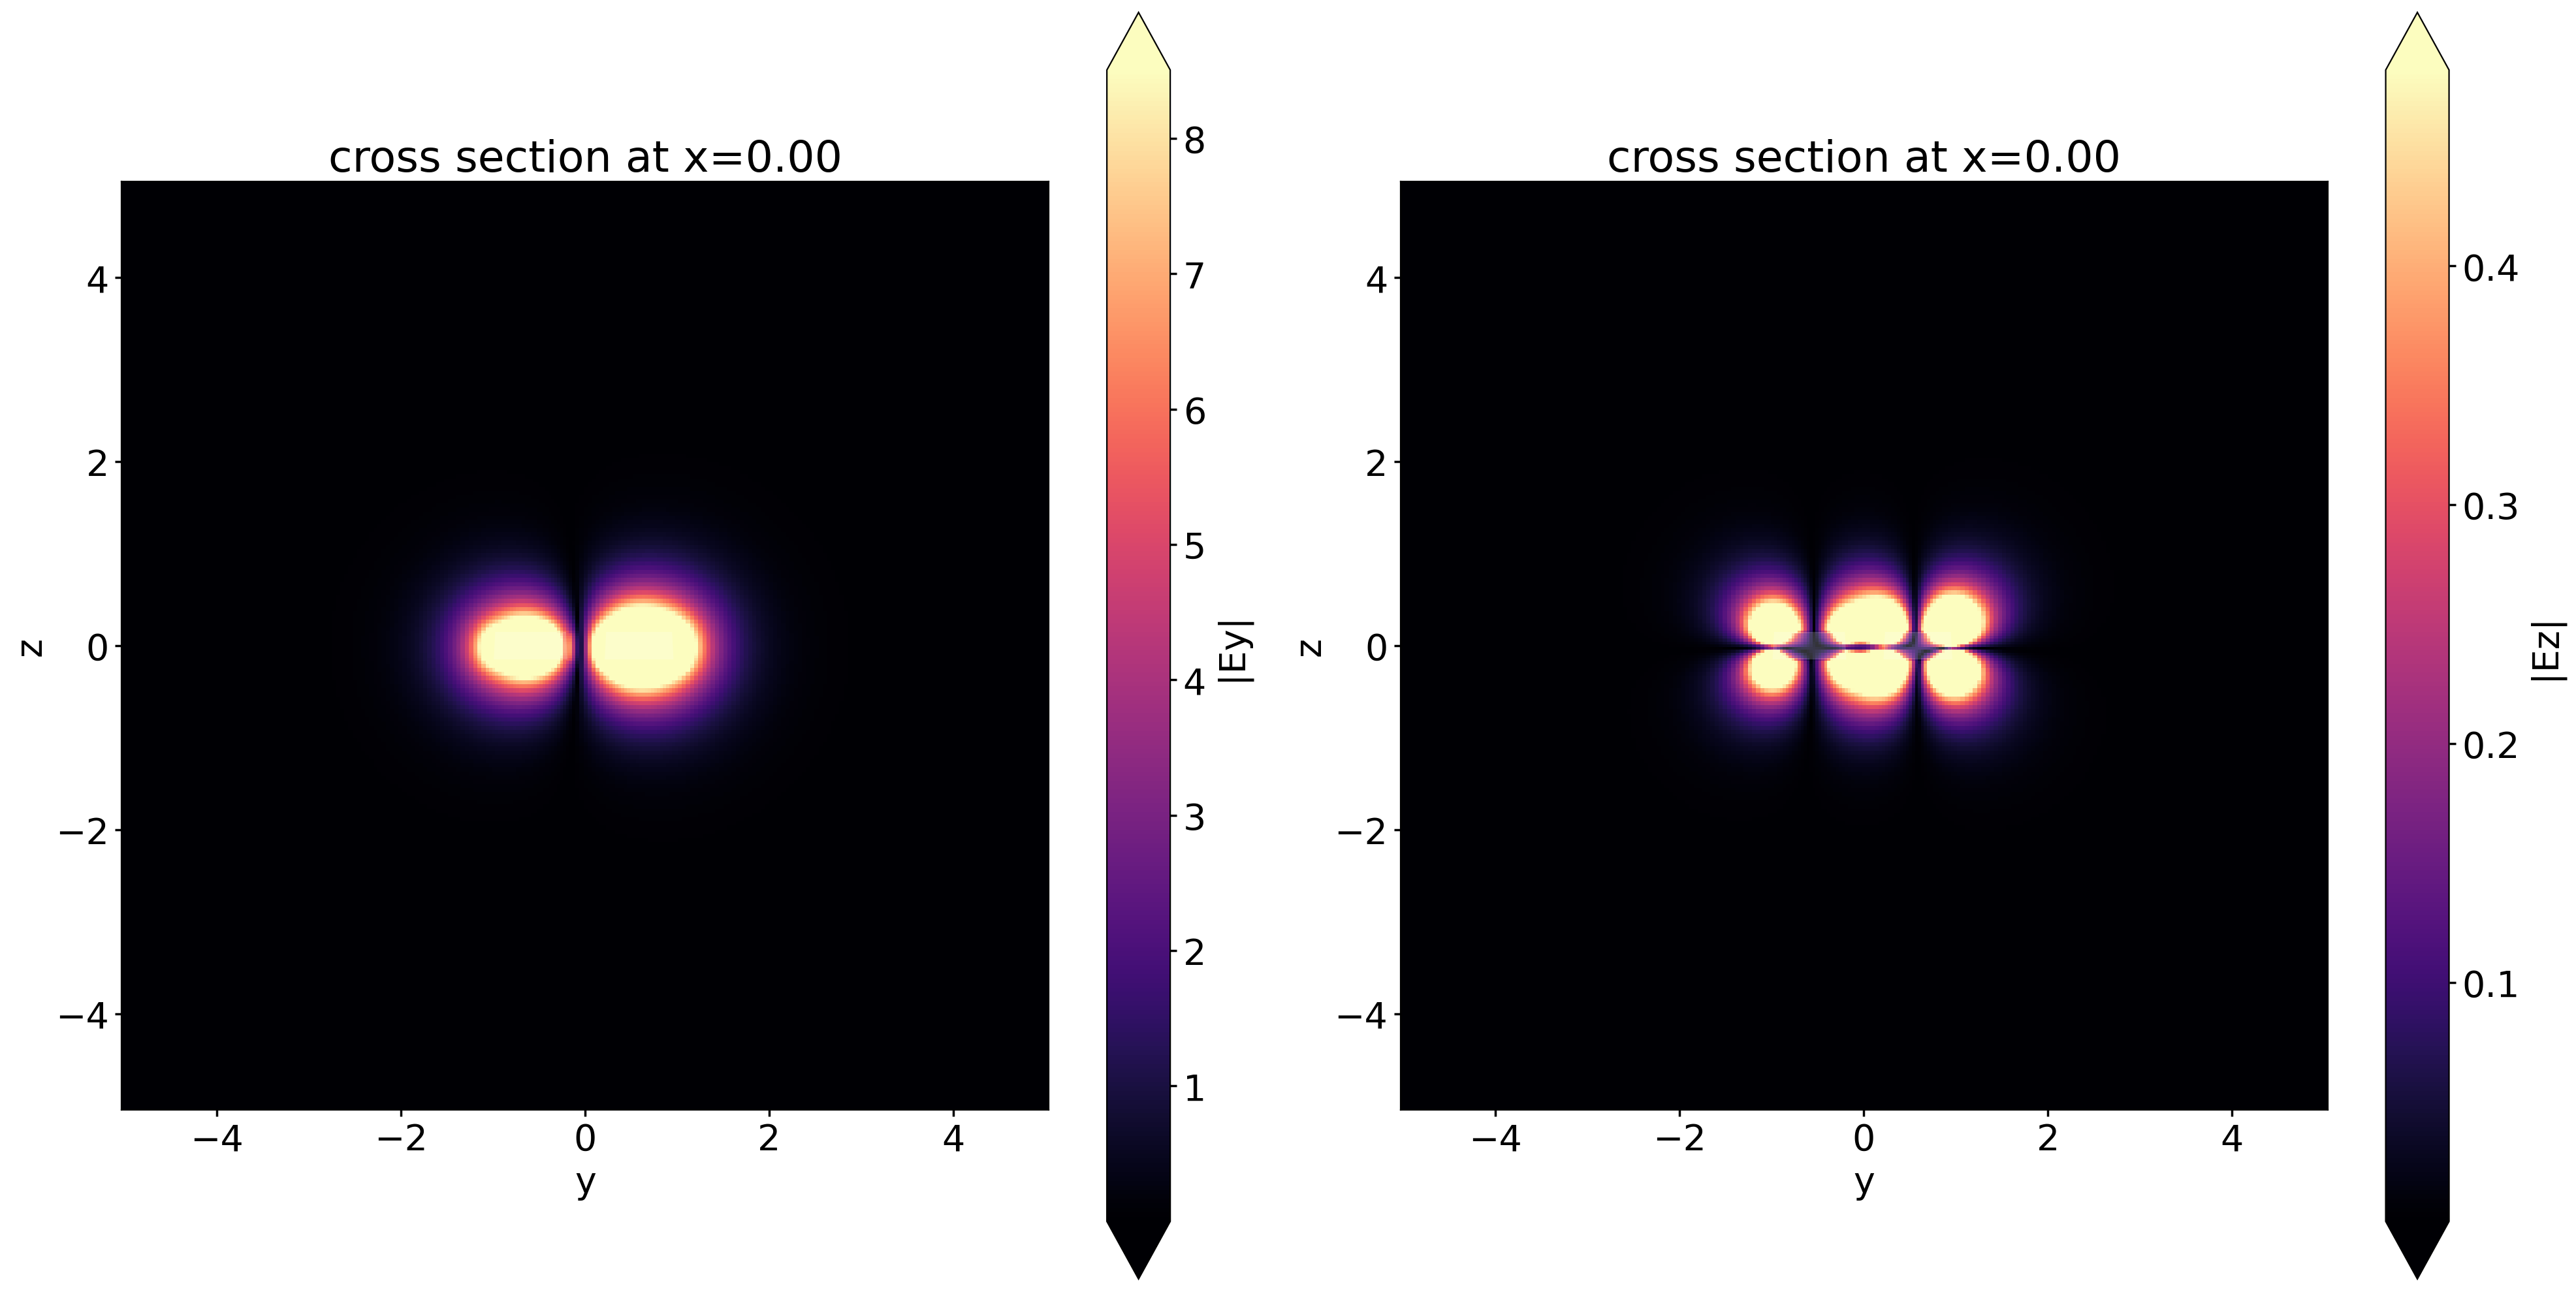

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
asymmetric_wg_3_coupled_mode_solver_0C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
asymmetric_wg_3_coupled_mode_solver_0C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
asymmetric_wg_3_coupled_mode_solver_0C.plot_field("Ey", "abs", mode_index=1, f=freq0, ax=ax1)
asymmetric_wg_3_coupled_mode_solver_0C.plot_field("Ez", "abs", mode_index=1, f=freq0, ax=ax2)
plt.tight_layout()
plt.show()

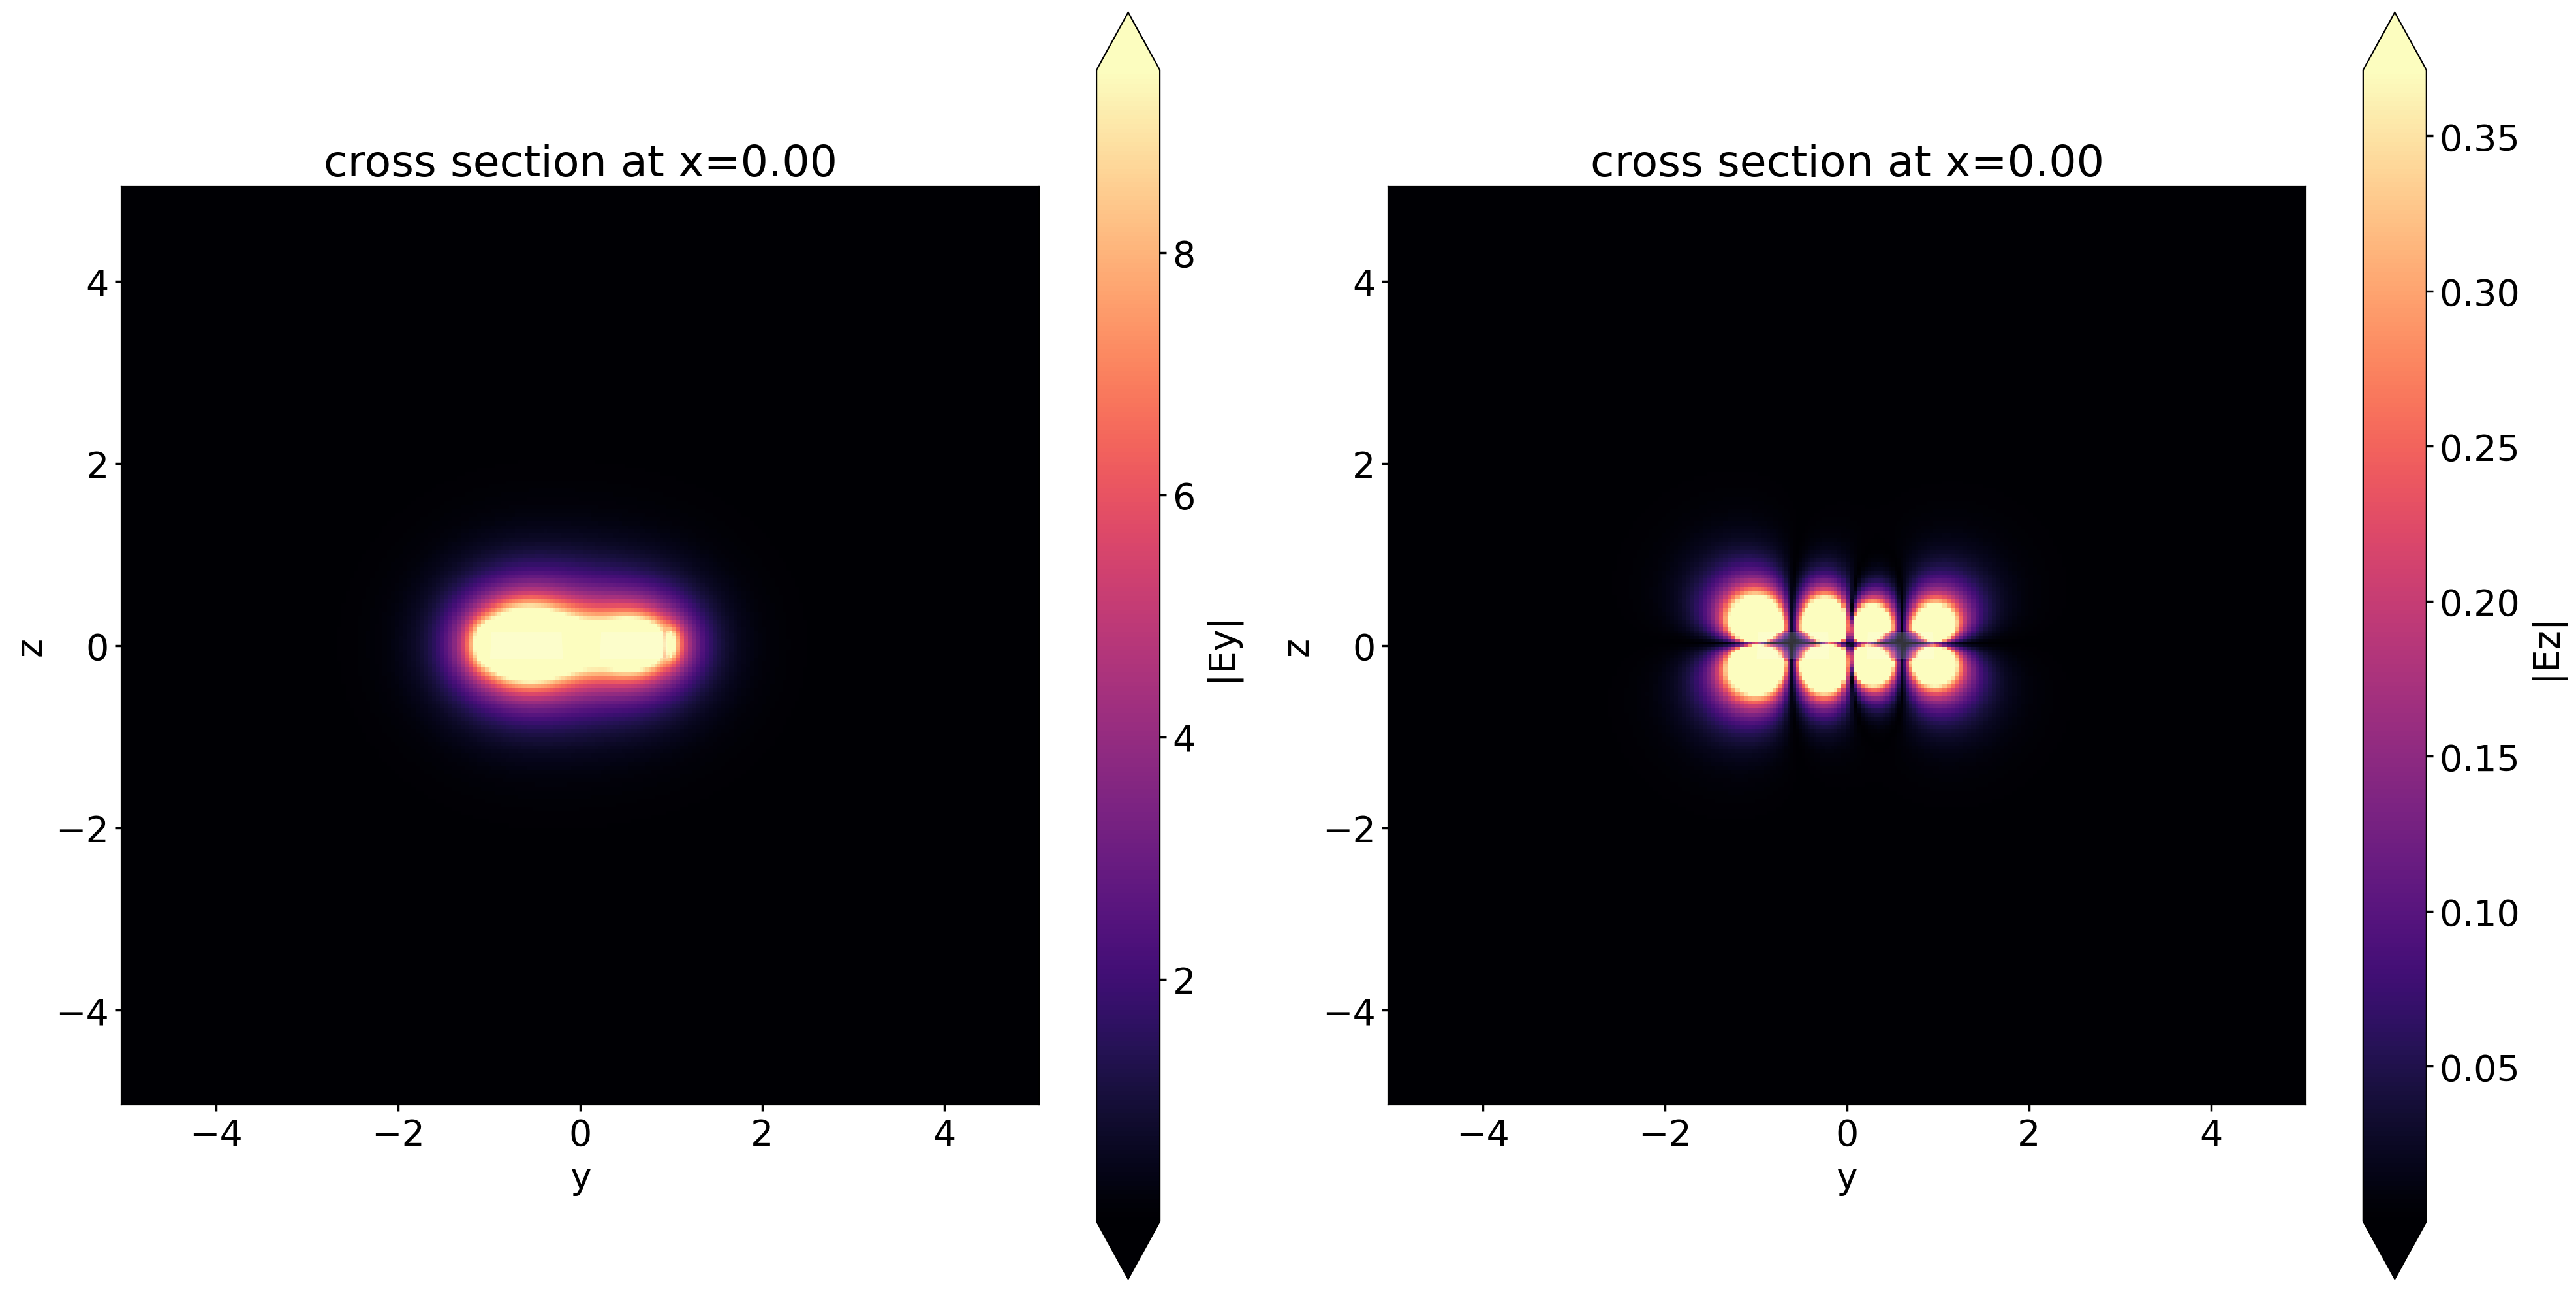

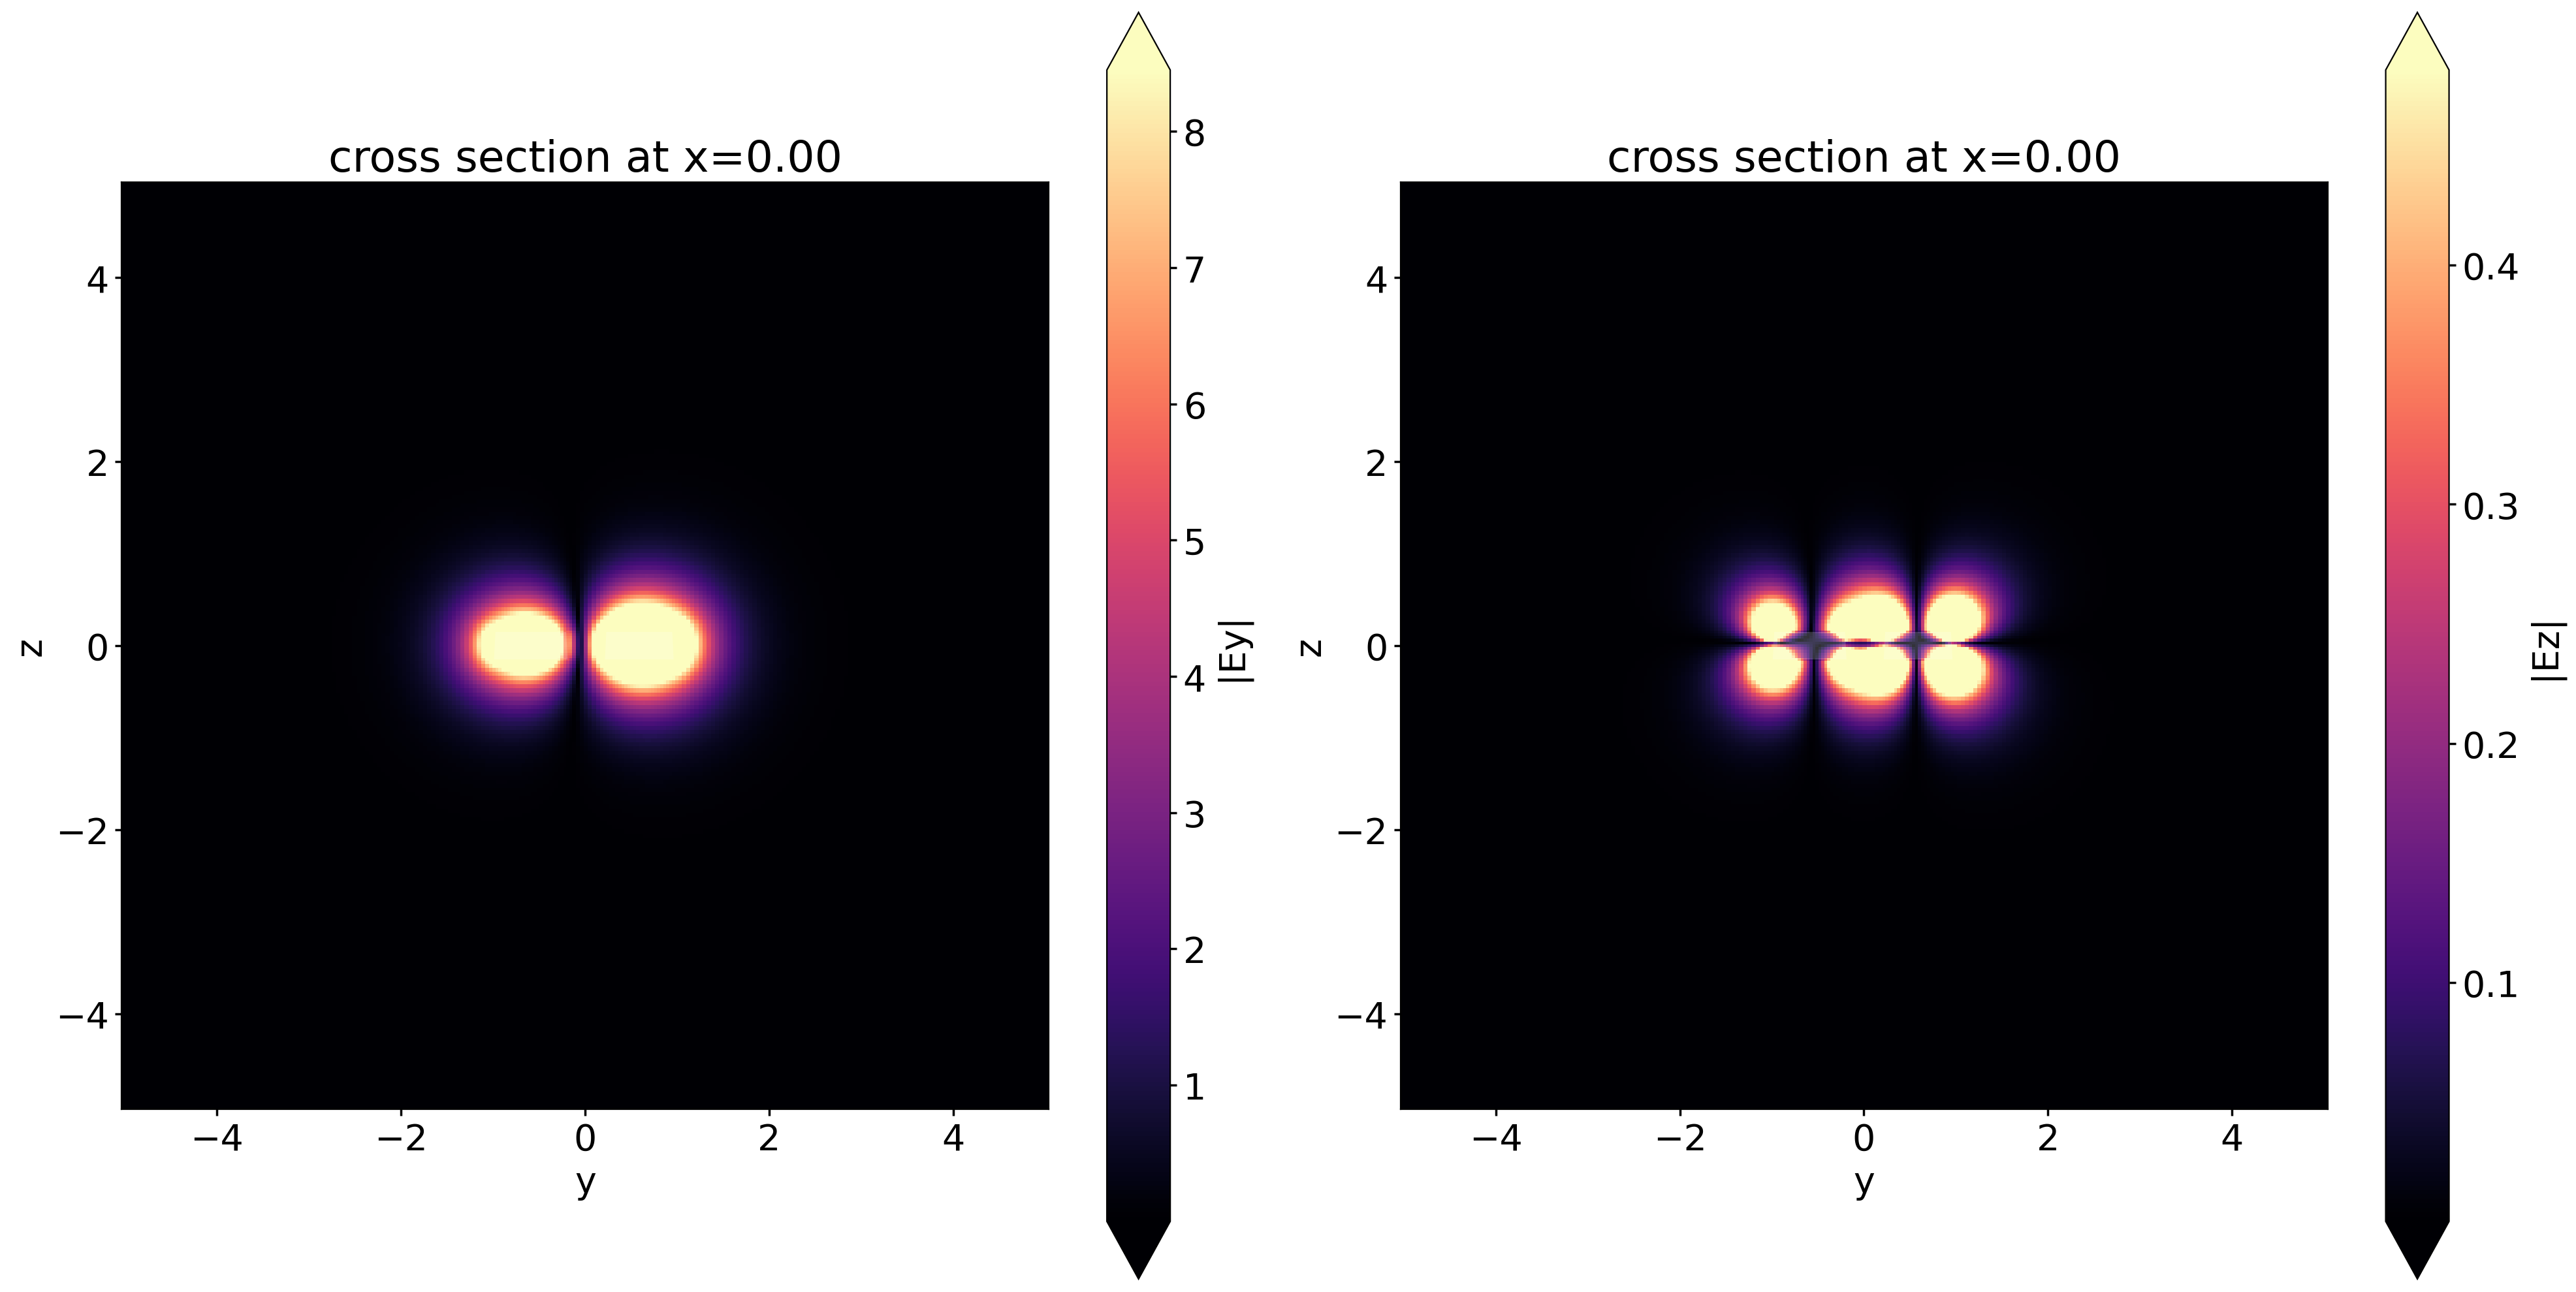

In [41]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20,10))
asymmetric_wg_3_coupled_mode_solver_120C.plot_field("Ey", "abs", mode_index=0, f=freq0, ax=ax1)
asymmetric_wg_3_coupled_mode_solver_120C.plot_field("Ez", "abs", mode_index=0, f=freq0, ax=ax2)
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(20, 10))
asymmetric_wg_3_coupled_mode_solver_120C.plot_field("Ey", "abs", mode_index=1, f=freq0, ax=ax1)
asymmetric_wg_3_coupled_mode_solver_120C.plot_field("Ez", "abs", mode_index=1, f=freq0, ax=ax2)
plt.tight_layout()
plt.show()

In [42]:
print("delta_neff_0C = ", asymmetric_wg_3_coupled_delta_neff_0C)
print("delta_neff_120C = ", asymmetric_wg_3_coupled_delta_neff_120C)

delta_neff_0C =  0.024275184
delta_neff_120C =  0.024225116


In [43]:
print((asymmetric_wg_3_coupled_delta_neff_120C-asymmetric_wg_3_coupled_delta_neff_0C)/asymmetric_wg_3_coupled_delta_neff_0C*100)

-0.20625137258321047
